In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import csv
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from torch.cuda.amp import GradScaler, autocast
from datetime import datetime
from pathlib import Path
import shutil
from matplotlib.colors import Normalize

class CustomLogger:
    def __init__(self, log_dir='logs'):
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(exist_ok=True, parents=True)
        self.metrics = {}
        
    def add_scalar(self, tag, scalar_value, global_step=None):
        if tag not in self.metrics:
            self.metrics[tag] = []
        self.metrics[tag].append((global_step, scalar_value))
        # บันทึกลง CSV 
        with open(self.log_dir / f"{tag.replace('/', '_')}.csv", 'a') as f:
            f.write(f"{global_step},{scalar_value}\n")
    
    def add_histogram(self, tag, values, global_step=None):
        # สำหรับ histogram จะบันทึกเพียงค่าสถิติพื้นฐาน
        try:
            if isinstance(values, torch.Tensor):
                values = values.detach().cpu().numpy()
            with open(self.log_dir / f"{tag.replace('/', '_')}_hist.csv", 'a') as f:
                stats = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'min': float(np.min(values)),
                    'max': float(np.max(values)),
                    'step': global_step
                }
                f.write(f"{global_step},{stats['mean']},{stats['std']},{stats['min']},{stats['max']}\n")
        except:
            pass  # ถ้ามีข้อผิดพลาด ให้ข้ามไป
    
    def add_image(self, tag, img_tensor, global_step=None):
        try:
            if isinstance(img_tensor, torch.Tensor):
                img_tensor = img_tensor.detach().cpu().numpy()
            
            img_dir = self.log_dir / "images"
            img_dir.mkdir(exist_ok=True, parents=True)
            
            fig = plt.figure()
            plt.imshow(np.transpose(img_tensor, (1, 2, 0)))
            plt.axis('off')
            plt.savefig(img_dir / f"{tag.replace('/', '_')}_{global_step}.png")
            plt.close(fig)
        except:
            pass  # ถ้ามีข้อผิดพลาด ให้ข้ามไป
    
    def close(self):
        # สร้างกราฟสรุปสำหรับทุกเมตริกที่บันทึกไว้
        for tag, values in self.metrics.items():
            try:
                steps, metrics = zip(*values)
                plt.figure()
                plt.plot(steps, metrics)
                plt.title(tag)
                plt.savefig(self.log_dir / f"{tag.replace('/', '_')}_summary.png")
                plt.close()
            except:
                continue

import matplotlib.gridspec as gridspec
# นำเข้าโมดูลเพิ่มประสิทธิภาพหน่วยความจำ
from memory_optimizations import (
    ENABLE_MEMORY_OPTIMIZATIONS, MEMORY_CONFIG, apply_memory_optimizations,
    clear_gpu_memory, print_gpu_memory_usage,
    optimized_load_data_and_split, optimized_train_model
)

# เพิ่มการ import checkpoint ก่อนเรียกใช้งาน
from torch.utils.checkpoint import checkpoint

# ตรวจสอบว่ามี CheckpointedModule หรือยัง ถ้าไม่มีให้สร้างใหม่
if 'CheckpointedModule' not in globals():
    class CheckpointedModule(nn.Module):
        """
        ครอบโมดูลด้วย gradient checkpoint เพื่อประหยัดหน่วยความจำ
        """
        def __init__(self, module):
            super().__init__()
            self.module = module
            self.use_checkpoint = MEMORY_CONFIG['use_model_checkpoint']
        
        def forward(self, x):
            if self.use_checkpoint and self.training:
                return checkpoint(self.module, x, use_reentrant=False)
            else:
                return self.module(x)

# เปิดใช้งานการปรับแต่งเพิ่มประสิทธิภาพหน่วยความจำ
apply_memory_optimizations()
# ตรวจสอบ GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# เพิ่มการจัดการหน่วยความจำ
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:128'
import gc
from torch.utils.checkpoint import checkpoint  # สำคัญ: ต้องเพิ่มบรรทัดนี้

# ฟังก์ชันช่วยล้างหน่วยความจำ
def clear_gpu_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ตั้งค่าการใช้หน่วยความจำของ GPU
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.95)  # ใช้ได้ 95% ของ GPU
    clear_gpu_memory()

Limited CUDA memory usage to 46GB
Enabled cuDNN benchmark mode
Memory optimizations applied with config: {'batch_size': 1, 'gradient_accumulation_steps': 8, 'input_downsample_factor': 0.75, 'use_model_checkpoint': True, 'mixed_precision_dtype': 'float16', 'monitor_memory_frequency': 5, 'save_checkpoint_frequency': 1, 'enable_volume_cropping': True, 'crop_margin': 2, 'enable_memory_cleanup': True, 'memory_cleanup_frequency': 1, 'reduced_feature_maps': True, 'pin_memory': False, 'use_amp': True, 'cudnn_benchmark': True, 'optimize_cache_size': True, 'limit_cuda_cache_size': 46}
Using device: cuda


In [2]:
# ตั้งค่า seed เพื่อความสามารถในการทำซ้ำผลลัพธ์
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
set_seed(42)

# โฟลเดอร์หลักของโปรเจค
BASE_DIR = Path(r'd:\ThesisMayn\Data_numpy\Data_preproceesing')  

# กำหนดพาธสำหรับโฟลเดอร์ข้อมูล
DATA_DIR = Path(r'd:\ThesisMayn\Data_numpy\Data_preproceesing')
TRAIN_DIR = Path(r'd:\ThesisMayn\Data_numpy\Data_preproceesing\Train-Val')  # โฟลเดอร์ที่มีข้อมูล train+val รวมกัน
TEST_DIR = Path(r'd:\ThesisMayn\Data_numpy\Data_preproceesing\Test')    # โฟลเดอร์ test 
METADATA_FILE = Path(r'd:\ThesisMayn\Data_numpy\Data_preproceesing\Train-Val\dose_metadata.csv')  # ไฟล์ metadata (หากมี)

# โฟลเดอร์สำหรับเก็บผลลัพธ์
OUTPUT_DIR = Path(r"d:\ThesisMayn\Data_numpy\results")
MODEL_DIR = Path(r"c:\Users\User\Desktop\ThesisMayn\model\new_model\Final")  # โฟลเดอร์สำหรับบันทึกโมเดล
LOG_DIR = Path(r"d:\ThesisMayn\Data_numpy\results")    # โฟลเดอร์สำหรับบันทึกประวัติการเทรน
RESULT_DIR = Path(r"d:\ThesisMayn\Data_numpy\results")  # โฟลเดอร์สำหรับบันทึกผลการทดสอบ
PREDICTION_DIR =  Path(r"d:\ThesisMayn\Data_numpy\results\predictions")  # โฟลเดอร์สำหรับเก็บผลการทำนาย
PUBLICATION_DIR = Path(r"d:\ThesisMayn\Data_numpy\results\predictions\publication")  # โฟลเดอร์สำหรับข้อมูลตีพิมพ์

# แก้ไขบรรทัดที่มีปัญหา
for folder_str in [DATA_DIR, OUTPUT_DIR, MODEL_DIR, LOG_DIR, RESULT_DIR, PREDICTION_DIR, PUBLICATION_DIR]:
    Path(folder_str).mkdir(parents=True, exist_ok=True)

# ชื่อไฟล์สำหรับโมเดลที่ดีที่สุด
BEST_MODEL_NAME = "best_model.pth"
BEST_MODEL_PATH = MODEL_DIR / BEST_MODEL_NAME

ENABLE_MEMORY_OPTIMIZATIONS

# กำหนดค่า timestamp สำหรับผลลัพธ์ที่ไม่ซ้ำกัน
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# Hyperparameters และการตั้งค่า
CONFIG = {
    # ข้อมูล
    'experiment_name': f'dose_prediction_{TIMESTAMP}',
    'val_ratio': 0.2,           # สัดส่วนข้อมูลสำหรับ validation
    'random_seed': 42,          # random seed สำหรับการแบ่งข้อมูล
    'normalize_data': False,    # ตั้งเป็น False หากข้อมูลผ่านการ normalize แล้ว
    
    # การฝึกโมเดล
    'batch_size': 1,
    'num_workers': 1,
    'max_epochs': 200,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'early_stopping_patience': 15,
    'early_stopping_metric': 'val_loss',  # 'val_loss', 'val_psnr', 'val_mae'
    'early_stopping_mode': 'min',         # 'min' หรือ 'max'
    'early_stopping_min_delta': 0.0001,
    'use_mixed_precision': True,          # ใช้ mixed precision หรือไม่
    
    'gradient_accumulation_steps': 4,

    # Cross-validation
    'do_cross_validation': True,
    'n_folds': 5,
    
    # โมเดล
    'model_type': 'Cascade3DUNet',        # เลือกประเภทโมเดล
    'in_channels': 2,                     # จำนวน input channels (CT + structure)
    'out_channels': 1,                    # จำนวน output channels (dose)
    
    # แฟล็กอื่นๆ
    'save_checkpoint_frequency': 10,     # บันทึก checkpoint ทุกๆ กี่ epochs
    'use_tensorboard': False,             # ใช้ TensorBoard หรือไม่
    'log_gradient_frequency': 10,        # บันทึกค่าเกรเดียนต์ทุกๆ กี่ epochs
    'save_best_metrics': ['val_loss', 'val_mae', 'val_psnr']  # เก็บโมเดลที่ดีที่สุดตามเมตริกเหล่านี้
}

# ปรับแต่งพาธให้สอดคล้องกับชื่อการทดลอง
EXPERIMENT_DIR = OUTPUT_DIR / CONFIG['experiment_name']
LOG_DIR = EXPERIMENT_DIR / 'logs'
MODEL_DIR = EXPERIMENT_DIR / 'models'
RESULT_DIR = EXPERIMENT_DIR / 'results'
PREDICTION_DIR = EXPERIMENT_DIR / 'predictions'
PUBLICATION_DIR = EXPERIMENT_DIR / 'publication'

# สร้างโฟลเดอร์ผลลัพธ์ตามชื่อการทดลอง
for folder in [EXPERIMENT_DIR, LOG_DIR, MODEL_DIR, RESULT_DIR, PREDICTION_DIR, PUBLICATION_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# บันทึกค่าการตั้งค่าเพื่อการอ้างอิงภายหลัง
with open(EXPERIMENT_DIR / 'config.json', 'w') as f:
    json.dump(CONFIG, f, indent=4)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)

# แก้ไข ResidualBlock เพื่อเพิ่ม SEBlock
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(SEResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.se = SEBlock(out_channels)  # เพิ่ม SE block
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # ใช้ SE block
        out += identity
        out = self.relu(out)
        return out
    
class Cascade3DUNet(nn.Module):
    def __init__(self, in_channels=6, num_classes=1):
        super(Cascade3DUNet, self).__init__()

        # Input projection
        self.input_projection = nn.Conv3d(in_channels, 32, kernel_size=1)

        # Encoder - เปลี่ยนจาก ResidualBlock เป็น SEResidualBlock
        self.encoder1 = SEResidualBlock(32, 32)
        self.encoder2 = SEResidualBlock(32, 64, downsample=nn.Conv3d(32, 64, kernel_size=1))
        self.encoder3 = SEResidualBlock(64, 128, downsample=nn.Conv3d(64, 128, kernel_size=1))
        self.encoder4 = SEResidualBlock(128, 256, downsample=nn.Conv3d(128, 256, kernel_size=1))
        self.encoder5 = SEResidualBlock(256, 512, downsample=nn.Conv3d(256, 512, kernel_size=1))

        # Decoder - คงเดิม
        self.decoder4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder4_conv = nn.Conv3d(256, 256, kernel_size=3, padding=1)
        self.decoder3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder3_conv = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.decoder2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder2_conv = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.decoder1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder1_conv = nn.Conv3d(32, 32, kernel_size=3, padding=1)

        # Projection layers for skip connections - คงเดิม
        self.proj4 = nn.Conv3d(256, 256, kernel_size=1)
        self.proj3 = nn.Conv3d(128, 128, kernel_size=1)
        self.proj2 = nn.Conv3d(64, 64, kernel_size=1)
        self.proj1 = nn.Conv3d(32, 32, kernel_size=1)

        # Final layer
        self.final_conv = nn.Conv3d(32, num_classes, kernel_size=1)


    def forward(self, x):
        # Input projection
        x = self.input_projection(x)

        # Encoder
        enc1 = self.encoder1(x)  # [B, 32, D, H, W]
        enc2 = self.encoder2(F.max_pool3d(enc1, 2))  # [B, 64, D/2, H/2, W/2]
        enc3 = self.encoder3(F.max_pool3d(enc2, 2))  # [B, 128, D/4, H/4, W/4]
        enc4 = self.encoder4(F.max_pool3d(enc3, 2))  # [B, 256, D/8, H/8, W/8]
        enc5 = self.encoder5(F.max_pool3d(enc4, 2))  # [B, 512, D/16, H/16, W/16]

        # Decoder
        x = self.decoder4(enc5)  # [B, 256, D/8, H/8, W/8]
        x = self.decoder4_conv(x)
        x = crop_to_match(x, enc4) + self.proj4(enc4)

        x = self.decoder3(x)  # [B, 128, D/4, H/4, W/4]
        x = self.decoder3_conv(x)
        x = crop_to_match(x, enc3) + self.proj3(enc3)

        x = self.decoder2(x)  # [B, 64, D/2, H/2, W/2]
        x = self.decoder2_conv(x)
        x = crop_to_match(x, enc2) + self.proj2(enc2)

        x = self.decoder1(x)  # [B, 32, D, H, W]
        x = self.decoder1_conv(x)
        x = crop_to_match(x, enc1) + self.proj1(enc1)

        x = self.final_conv(x)  # Final layer
        
        # เพิ่ม sigmoid เพื่อให้ค่าอยู่ระหว่าง 0-1
        x = torch.sigmoid(x)
        
        return x


In [ ]:
#################################
# 1. ฟังก์ชันโหลดและเตรียมข้อมูล
#################################
def load_data_and_split(train_dir, test_dir, val_ratio=0.2, random_seed=42):
    
    # โหลดข้อมูลจากโฟลเดอร์ train (ซึ่งมีทั้ง train+val รวมกัน)
    train_patient_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) 
                         if os.path.isdir(os.path.join(train_dir, d))]
    
    # โหลดข้อมูลจากโฟลเดอร์ test
    test_patient_dirs = [os.path.join(test_dir, d) for d in os.listdir(test_dir) 
                        if os.path.isdir(os.path.join(test_dir, d))]
    
    # ตรวจสอบจำนวนข้อมูล
    print(f"Found {len(train_patient_dirs)} patients in train directory")
    print(f"Found {len(test_patient_dirs)} patients in test directory")
    
    # รวบรวม paths ของไฟล์ในโฟลเดอร์ train
    train_val_ct_paths = []
    train_val_structure_paths = []
    train_val_dose_paths = []
    train_val_patient_ids = []  # เก็บ ID ของผู้ป่วยเพื่อการอ้างอิง
    
    for patient_dir in train_patient_dirs:
        try:
            patient_id = os.path.basename(patient_dir)
            ct_file = os.path.join(patient_dir, "CT_preprocessed.npy")
            structure_file = os.path.join(patient_dir, "Mask_preprocessed.npy") 
            dose_file = os.path.join(patient_dir, "Dose_preprocessed.npy")  
            # Load and print detailed info
            ct = np.load(ct_file)
            structure = np.load(structure_file)
            dose = np.load(dose_file)
            
            print(f"Patient {patient_id}:")
            print(f"  CT shape: {ct.shape}")
            print(f"  Structure shape: {structure.shape}")
            print(f"  Dose shape: {dose.shape}")
            
            # Rest of the existing validation code
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
        
        # ตรวจสอบว่าไฟล์ทั้งหมดมีอยู่จริง
        if os.path.exists(ct_file) and os.path.exists(structure_file) and os.path.exists(dose_file):
            train_val_ct_paths.append(ct_file)
            train_val_structure_paths.append(structure_file)
            train_val_dose_paths.append(dose_file)
            train_val_patient_ids.append(patient_id)
        else:
            missing = []
            if not os.path.exists(ct_file): missing.append("CT_preprocessed.npy")
            if not os.path.exists(structure_file): missing.append("Mask_preprocessed.npy") 
            if not os.path.exists(dose_file): missing.append("Dose_preprocessed.npy")
            print(f"Warning: Missing files for patient {os.path.basename(patient_dir)}: {', '.join(missing)}")
    
    # รวบรวม paths ของไฟล์ในโฟลเดอร์ test
    test_ct_paths = []
    test_structure_paths = []
    test_dose_paths = []
    test_patient_ids = []  # เก็บ ID ของผู้ป่วยเพื่อการอ้างอิง
    
    for patient_dir in test_patient_dirs:
        patient_id = os.path.basename(patient_dir)
        ct_file = os.path.join(patient_dir, "CT_preprocessed.npy")
        structure_file = os.path.join(patient_dir, "Mask_preprocessed.npy")
        dose_file = os.path.join(patient_dir, "Dose_preprocessed.npy")
        
        if os.path.exists(ct_file) and os.path.exists(structure_file) and os.path.exists(dose_file):
            test_ct_paths.append(ct_file)
            test_structure_paths.append(structure_file)
            test_dose_paths.append(dose_file)
            test_patient_ids.append(patient_id)
        else:
            missing = []
            if not os.path.exists(ct_file): missing.append("CT_preprocessed.npy")
            if not os.path.exists(structure_file): missing.append("Mask_preprocessed.npy") 
            if not os.path.exists(dose_file): missing.append("Dose_preprocessed.npy")
            print(f"Warning: Missing files for patient {os.path.basename(patient_dir)}: {', '.join(missing)}")
    
    # แบ่งข้อมูลใน train เป็น train/val
    train_indices, val_indices = train_test_split(
        range(len(train_val_ct_paths)), 
        test_size=val_ratio, 
        random_state=random_seed
    )
    
    # แยกข้อมูลตาม indices
    train_ct = [train_val_ct_paths[i] for i in train_indices]
    train_structure = [train_val_structure_paths[i] for i in train_indices]
    train_dose = [train_val_dose_paths[i] for i in train_indices]
    train_patient_ids = [train_val_patient_ids[i] for i in train_indices]
    
    val_ct = [train_val_ct_paths[i] for i in val_indices]
    val_structure = [train_val_structure_paths[i] for i in val_indices]
    val_dose = [train_val_dose_paths[i] for i in val_indices]
    val_patient_ids = [train_val_patient_ids[i] for i in val_indices]
    
    print(f"Split train/val: {len(train_ct)} train samples, {len(val_ct)} validation samples")
    print(f"Test: {len(test_ct_paths)} test samples")
    
    # บันทึกรายการไฟล์ในแต่ละชุดข้อมูลเพื่อความสะดวกในการอ้างอิง
    data_split_info = {
        "train": {
            "patient_ids": train_patient_ids,
            "ct_paths": train_ct,
            "structure_paths": train_structure,
            "dose_paths": train_dose
        },
        "val": {
            "patient_ids": val_patient_ids,
            "ct_paths": val_ct,
            "structure_paths": val_structure,
            "dose_paths": val_dose
        },
        "test": {
            "patient_ids": test_patient_ids,
            "ct_paths": test_ct_paths,
            "structure_paths": test_structure_paths,
            "dose_paths": test_dose_paths
        }
    }
    
    # บันทึกข้อมูลการแบ่งชุดข้อมูลเป็น JSON
    with open(EXPERIMENT_DIR / 'data_split.json', 'w') as f:
        # ต้องแปลง path objects เป็น strings ก่อนบันทึกเป็น JSON
        serializable_data = {}
        for key, value in data_split_info.items():
            serializable_data[key] = {
                "patient_ids": value["patient_ids"],
                "ct_paths": [str(path) for path in value["ct_paths"]],
                "structure_paths": [str(path) for path in value["structure_paths"]],
                "dose_paths": [str(path) for path in value["dose_paths"]]
            }
        json.dump(serializable_data, f, indent=4)
    
    return {
        "train": {"ct": train_ct, "structure": train_structure, "dose": train_dose, "patient_ids": train_patient_ids},
        "val": {"ct": val_ct, "structure": val_structure, "dose": val_dose, "patient_ids": val_patient_ids},
        "test": {"ct": test_ct_paths, "structure": test_structure_paths, "dose": test_dose_paths, "patient_ids": test_patient_ids}
    }

def pad_to_same_size(tensor, target_size):
    """
    Pads a tensor to the target size with zeros.
    """
    padding = []
    for current, target in zip(reversed(tensor.shape), reversed(target_size)):
        diff = target - current
        padding.extend([diff // 2, diff - diff // 2])
    return F.pad(tensor, padding, mode='constant', value=0)

def check_data_sample(ct_path, structure_path, dose_path):
    """
    ตรวจสอบขนาดและค่าของข้อมูลสำหรับตัวอย่างหนึ่งๆ
    """
    try:
        ct = np.load(ct_path)
        structure = np.load(structure_path)
        dose = np.load(dose_path)
        
        print(f"CT: shape={ct.shape}, min={ct.min():.4f}, max={ct.max():.4f}")
        print(f"Structure: shape={structure.shape}, min={structure.min():.4f}, max={structure.max():.4f}")
        print(f"Dose: shape={dose.shape}, min={dose.min():.4f}, max={dose.max():.4f}")
        
        # ตรวจสอบว่าข้อมูลทั้งหมดมีขนาดเท่ากันหรือไม่
        if ct.shape == structure.shape == dose.shape:
            print("✓ All data have the same shape")
        else:
            print("⚠ Data shapes don't match!")
        
        # ตรวจสอบว่าค่าใน mask อยู่ในช่วงที่คาดไว้หรือไม่ (0-1)
        if 0 <= structure.min() <= structure.max() <= 1:
            print("✓ Structure values are in expected range [0, 1]")
        else:
            print(f"⚠ Structure values are outside expected range: [{structure.min()}, {structure.max()}]")
        
        # ตรวจสอบว่าค่าใน dose อยู่ในช่วงที่คาดไว้หรือไม่ (0-1 หากผ่านการ normalize แล้ว)
        if 0 <= dose.min() <= dose.max() <= 1:
            print("✓ Dose values are in normalized range [0, 1]")
        else:
            print(f"⚠ Dose values might not be normalized: [{dose.min()}, {dose.max()}]")
        
        # ส่งคืนข้อมูลเพิ่มเติมเพื่อการวิเคราะห์
        stats = {
            "ct_shape": ct.shape,
            "ct_min": float(ct.min()),
            "ct_max": float(ct.max()),
            "ct_mean": float(ct.mean()),
            "ct_std": float(ct.std()),
            "structure_shape": structure.shape,
            "structure_min": float(structure.min()),
            "structure_max": float(structure.max()),
            "structure_mean": float(structure.mean()),
            "structure_std": float(structure.std()),
            "dose_shape": dose.shape,
            "dose_min": float(dose.min()),
            "dose_max": float(dose.max()),
            "dose_mean": float(dose.mean()),
            "dose_std": float(dose.std()),
            "same_shape": ct.shape == structure.shape == dose.shape,
            "structure_in_range": 0 <= structure.min() <= structure.max() <= 1,
            "dose_normalized": 0 <= dose.min() <= dose.max() <= 1
        }
            
        return True, stats
    except Exception as e:
        print(f"Error checking data: {e}")
        return False, {"error": str(e)}

def visualize_data_sample(ct_path, structure_path, dose_path, slice_idx=None, save_dir=None):
    try:
        ct = np.load(ct_path)
        structure = np.load(structure_path)
        dose = np.load(dose_path)
        
        # ใช้ patient_id จากพาธของไฟล์
        patient_id = os.path.basename(os.path.dirname(ct_path))
        
        if slice_idx is None:
            # หาสไลด์ที่มี structure และ dose
            structure_sum = np.sum(structure, axis=(1, 2))
            dose_sum = np.sum(dose, axis=(1, 2))
            valid_slices = np.where((structure_sum > 0) & (dose_sum > 0))[0]
            
            if len(valid_slices) > 0:
                slice_idx = valid_slices[len(valid_slices) // 2]
            else:
                slice_idx = ct.shape[0] // 2
        
        ct_display = ct[slice_idx].copy()
        ct_min, ct_max = -1000, 1000 
        ct_display = np.clip(ct_display, ct_min, ct_max)
        ct_display = (ct_display - ct_min) / (ct_max - ct_min)
        
        plt.figure(figsize=(20, 10))
        
        gs = gridspec.GridSpec(2, 3)
        
        # แสดงภาพแยกในแถวแรก
        ax1 = plt.subplot(gs[0, 0])
        ax1.imshow(ct_display, cmap='gray')
        ax1.set_title(f"CT (Slice {slice_idx})")
        plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=ct_min, vmax=ct_max), cmap='gray'), 
                    ax=ax1, fraction=0.046, pad=0.04)
        ax1.axis('off')
        
        ax2 = plt.subplot(gs[0, 1])
        im2 = ax2.imshow(structure[slice_idx], cmap='viridis')
        ax2.set_title(f"Structure Mask (Slice {slice_idx})")
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        ax2.axis('off')
        
        ax3 = plt.subplot(gs[0, 2])
        im3 = ax3.imshow(dose[slice_idx], cmap='hot')
        ax3.set_title(f"Dose (Slice {slice_idx})")
        plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
        ax3.axis('off')
        
        # แสดง overlay ในแถวที่สอง
        ax4 = plt.subplot(gs[1, 0])
        ax4.imshow(ct_display, cmap='gray')
        ax4.set_title(f"CT (Patient: {patient_id})")
        ax4.axis('off')
        
        ax5 = plt.subplot(gs[1, 1])
        ax5.imshow(ct_display, cmap='gray')
        ax5.imshow(structure[slice_idx], cmap='viridis', alpha=0.5)
        ax5.set_title(f"CT + Structure Overlay")
        ax5.axis('off')
        
        ax6 = plt.subplot(gs[1, 2])
        ax6.imshow(ct_display, cmap='gray')
        ax6.imshow(dose[slice_idx], cmap='hot', alpha=0.5)
        ax6.set_title(f"CT + Dose Overlay")
        ax6.axis('off')
        
        plt.suptitle(f"Patient: {patient_id} - Slice {slice_idx}/{ct.shape[0]}", fontsize=16)
        plt.tight_layout()
        
        # บันทึกภาพ
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"patient_{patient_id}_slice_{slice_idx}.png"), 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
        
        mid_slice = slice_idx
        plt.figure(figsize=(15, 10))
        
        # คำนวณสไลด์ก่อนและหลัง
        prev_slice = max(0, mid_slice - ct.shape[0]//6)
        next_slice = min(ct.shape[0]-1, mid_slice + ct.shape[0]//6)
        
        slices_to_show = [prev_slice, mid_slice, next_slice]
        
        for i, cur_slice in enumerate(slices_to_show):
            # CT แสดงเป็นพื้นหลัง
            ct_slice = ct[cur_slice].copy()
            ct_slice = np.clip(ct_slice, ct_min, ct_max)
            ct_slice = (ct_slice - ct_min) / (ct_max - ct_min)
            
            # Structure และ Dose overlay
            plt.subplot(3, 3, i*3 + 1)
            plt.imshow(ct_slice, cmap='gray')
            plt.title(f"CT (Slice {cur_slice})")
            plt.axis('off')
            
            plt.subplot(3, 3, i*3 + 2)
            plt.imshow(ct_slice, cmap='gray')
            plt.imshow(structure[cur_slice], cmap='viridis', alpha=0.5)
            plt.title(f"CT + Structure (Slice {cur_slice})")
            plt.axis('off')
            
            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(ct_slice, cmap='gray')
            plt.imshow(dose[cur_slice], cmap='hot', alpha=0.5)
            plt.title(f"CT + Dose (Slice {cur_slice})")
            plt.axis('off')
        
        plt.suptitle(f"Patient: {patient_id} - Multiple Slices", fontsize=16)
        plt.tight_layout()
        
        # บันทึกภาพหลายสไลด์
        if save_dir:
            plt.savefig(os.path.join(save_dir, f"patient_{patient_id}_multiple_slices.png"), 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return {
            "patient_id": patient_id,
            "selected_slice": slice_idx,
            "ct_shape": ct.shape,
            "structure_shape": structure.shape,
            "dose_shape": dose.shape
        }
        
    except Exception as e:
        print(f"Error visualizing data: {e}")
        return None

def convert_to_json_serializable(obj):
    """แปลงข้อมูลให้สามารถบันทึกเป็น JSON ได้"""
    import numpy as np
    
    if isinstance(obj, dict):
        return {k: convert_to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_json_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        return [convert_to_json_serializable(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif obj is None or isinstance(obj, (str, int, float, bool)):
        return obj
    else:
        return str(obj)

def analyze_dataset_statistics(data_dict, sample_limit=None):
    """
    วิเคราะห์สถิติของชุดข้อมูลทั้งหมดและบันทึกสรุปผล
    
    Args:
        data_dict: dictionary ที่มีข้อมูล paths ของ CT, structure และ dose
        sample_limit: จำกัดจำนวนตัวอย่างที่วิเคราะห์ (None = วิเคราะห์ทั้งหมด)
    """
    stats = {"train": [], "val": [], "test": []}
    summary = {"train": {}, "val": {}, "test": {}}
    
    for dataset in ["train", "val", "test"]:
        print(f"\nAnalyzing {dataset} dataset...")
        ct_paths = data_dict[dataset]["ct"]
        structure_paths = data_dict[dataset]["structure"]
        dose_paths = data_dict[dataset]["dose"]
        
        # จำกัดจำนวนตัวอย่างหากระบุ
        if sample_limit:
            ct_paths = ct_paths[:sample_limit]
            structure_paths = structure_paths[:sample_limit]
            dose_paths = dose_paths[:sample_limit]
        
        for i, (ct_path, structure_path, dose_path) in enumerate(zip(ct_paths, structure_paths, dose_paths)):
            print(f"Analyzing sample {i+1}/{len(ct_paths)}...")
            success, sample_stats = check_data_sample(ct_path, structure_path, dose_path)
            if success:
                stats[dataset].append(sample_stats)
        
        # คำนวณสถิติสรุป
        if stats[dataset]:
            summary[dataset] = {
                "num_samples": len(stats[dataset]),
                "ct_shape": stats[dataset][0]["ct_shape"],  # ใช้ตัวอย่างแรกสำหรับขนาด
                "ct_min_avg": np.mean([s["ct_min"] for s in stats[dataset]]),
                "ct_max_avg": np.mean([s["ct_max"] for s in stats[dataset]]),
                "ct_mean_avg": np.mean([s["ct_mean"] for s in stats[dataset]]),
                "ct_std_avg": np.mean([s["ct_std"] for s in stats[dataset]]),
                "structure_min_avg": np.mean([s["structure_min"] for s in stats[dataset]]),
                "structure_max_avg": np.mean([s["structure_max"] for s in stats[dataset]]),
                "structure_mean_avg": np.mean([s["structure_mean"] for s in stats[dataset]]),
                "structure_std_avg": np.mean([s["structure_std"] for s in stats[dataset]]),
                "dose_min_avg": np.mean([s["dose_min"] for s in stats[dataset]]),
                "dose_max_avg": np.mean([s["dose_max"] for s in stats[dataset]]),
                "dose_mean_avg": np.mean([s["dose_mean"] for s in stats[dataset]]),
                "dose_std_avg": np.mean([s["dose_std"] for s in stats[dataset]]),
                "all_same_shape": all([s["same_shape"] for s in stats[dataset]]),
                "all_structure_in_range": all([s["structure_in_range"] for s in stats[dataset]]),
                "all_dose_normalized": all([s["dose_normalized"] for s in stats[dataset]])
            }
    
    # บันทึกผลการวิเคราะห์
    os.makedirs(LOG_DIR, exist_ok=True)
    with open(LOG_DIR / 'dataset_statistics.json', 'w') as f:
        json.dump(convert_to_json_serializable(summary), f, indent=4)

    # บันทึกรายละเอียดของแต่ละตัวอย่าง
    with open(LOG_DIR / 'detailed_sample_statistics.json', 'w') as f:
        json.dump(convert_to_json_serializable(stats), f, indent=4)
    
    # สร้างรายงานสรุปในรูปแบบที่อ่านได้ง่าย
    with open(LOG_DIR / 'dataset_summary_report.txt', 'w') as f:
        f.write("========== DATASET STATISTICS SUMMARY ==========\n\n")
        
        for dataset in ["train", "val", "test"]:
            f.write(f"---------- {dataset.upper()} DATASET ----------\n")
            if summary[dataset]:
                f.write(f"Number of samples: {summary[dataset]['num_samples']}\n")
                f.write(f"Data shape: {summary[dataset]['ct_shape']}\n\n")
                
                f.write("CT Statistics:\n")
                f.write(f"  Min (avg): {summary[dataset]['ct_min_avg']:.4f}\n")
                f.write(f"  Max (avg): {summary[dataset]['ct_max_avg']:.4f}\n")
                f.write(f"  Mean (avg): {summary[dataset]['ct_mean_avg']:.4f}\n")
                f.write(f"  Std (avg): {summary[dataset]['ct_std_avg']:.4f}\n\n")
                
                f.write("Structure Statistics:\n")
                f.write(f"  Min (avg): {summary[dataset]['structure_min_avg']:.4f}\n")
                f.write(f"  Max (avg): {summary[dataset]['structure_max_avg']:.4f}\n")
                f.write(f"  Mean (avg): {summary[dataset]['structure_mean_avg']:.4f}\n")
                f.write(f"  Std (avg): {summary[dataset]['structure_std_avg']:.4f}\n\n")
                
                f.write("Dose Statistics:\n")
                f.write(f"  Min (avg): {summary[dataset]['dose_min_avg']:.4f}\n")
                f.write(f"  Max (avg): {summary[dataset]['dose_max_avg']:.4f}\n")
                f.write(f"  Mean (avg): {summary[dataset]['dose_mean_avg']:.4f}\n")
                f.write(f"  Std (avg): {summary[dataset]['dose_std_avg']:.4f}\n\n")
                
                f.write("Quality Checks:\n")
                f.write(f"  All same shape: {'✓' if summary[dataset]['all_same_shape'] else '✗'}\n")
                f.write(f"  All structure in range [0,1]: {'✓' if summary[dataset]['all_structure_in_range'] else '✗'}\n")
                f.write(f"  All dose normalized: {'✓' if summary[dataset]['all_dose_normalized'] else '✗'}\n\n")
            else:
                f.write("No data available.\n\n")
    
    print(f"\nDataset analysis completed. Reports saved to {LOG_DIR}")
    return summary, stats

def crop_to_nonzero_region(volume, margin=5):
    """
    ตัดเอาเฉพาะส่วนที่มีค่าไม่เป็นศูนย์ของ volume พร้อมใส่ margin
    
    Args:
        volume: numpy array 3D ที่ต้องการตัด
        margin: ขอบเขตเพิ่มเติมรอบบริเวณที่ไม่เป็นศูนย์ (หน่วยเป็น voxel)
        
    Returns:
        tuple: (volume ที่ถูกตัดแล้ว, พิกัดที่ใช้ในการตัด)
    """
    # หาตำแหน่งที่ไม่เป็นศูนย์ (เช่น บริเวณ ROI หรือ organs)
    nonzero = np.where(volume > 0)
    
    # ตรวจสอบว่ามีค่าที่ไม่เป็นศูนย์หรือไม่
    if len(nonzero[0]) == 0:
        return volume, None
    
    # หาขอบเขตต่ำสุดและสูงสุดในแต่ละมิติ (z, y, x)
    min_z, max_z = max(0, np.min(nonzero[0])-margin), min(volume.shape[0], np.max(nonzero[0])+margin+1)
    min_y, max_y = max(0, np.min(nonzero[1])-margin), min(volume.shape[1], np.max(nonzero[1])+margin+1)
    min_x, max_x = max(0, np.min(nonzero[2])-margin), min(volume.shape[2], np.max(nonzero[2])+margin+1)
    
    # ตัดเฉพาะส่วนที่สำคัญ
    crop_coordinates = (min_z, max_z, min_y, max_y, min_x, max_x)
    return volume[min_z:max_z, min_y:max_y, min_x:max_x], crop_coordinates

#################################
# 2. Dataset และ DataLoader
#################################
class RandomFlip3D:
    """
    ทำการสุ่มพลิกข้อมูล 3D (CT, structure, dose) ตามแกนที่กำหนด
    """
    def __init__(self, p=0.5, axes=(1, 2, 3)):  # เปลี่ยนจาก (2, 3, 4) เป็น (1, 2, 3)
        self.p = p
        self.axes = axes
        
    def __call__(self, sample):
        inputs, targets = sample
        
        if np.random.rand() < self.p:
            # สุ่มแกนที่จะทำการ flip
            axis = np.random.choice(self.axes)
            inputs = torch.flip(inputs, [axis])
            targets = torch.flip(targets, [axis])
        
        return inputs, targets

class RandomRotation90:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        inputs, targets = sample
        
        if np.random.rand() < self.p:
            k = np.random.randint(1, 4)  # หมุน 90, 180, หรือ 270 องศา
            inputs = torch.rot90(inputs, k, dims=[1, 2])  # ปรับตรงนี้
            targets = torch.rot90(targets, k, dims=[1, 2])  # ปรับตรงนี้
        
        return inputs, targets

class DosePredictionDataset(Dataset):
    def __init__(self, ct_paths, structure_paths, dose_paths=None, patient_ids=None, csv_path=None, mode="train", normalize=False, transforms_enabled=True):
        self.ct_paths = ct_paths
        self.structure_paths = structure_paths
        self.dose_paths = dose_paths
        self.patient_ids = patient_ids if patient_ids else [f"patient_{i}" for i in range(len(ct_paths))]
        self.mode = mode
        self.normalize = normalize
        self.enable_cropping = ENABLE_MEMORY_OPTIMIZATIONS and MEMORY_CONFIG['enable_volume_cropping']
        self.crop_margin = MEMORY_CONFIG['crop_margin']
        self.cropped_info = {}  # เก็บข้อมูลการ crop

        # ตั้งค่าการแปลงข้อมูล (data augmentation)
        self.transform = None
        if mode == "train" and transforms_enabled:
            self.use_transforms = True
            self.flip_transform = RandomFlip3D(p=0.5)
            self.rotation_transform = RandomRotation90(p=0.3)
        else:
            self.use_transforms = False
        
        # โหลด metadata หากมี
        if csv_path is not None and os.path.exists(csv_path):
            self.metadata = pd.read_csv(csv_path)
            print(f"Loaded metadata with {len(self.metadata)} entries")
        else:
            self.metadata = None
            print("No metadata file found or specified")
        
        # ตรวจหาขนาดสูงสุดของข้อมูล (เผื่อกรณีที่ข้อมูลมีขนาดไม่เท่ากัน)
        first_ct = np.load(self.ct_paths[0])
        self.target_size = first_ct.shape
        print(f"Target size: {self.target_size}")
        
        # ตรวจสอบโครงสร้างข้อมูล
        self.check_data_structure()
        
        # ลงทะเบียนข้อมูลตัวอย่าง
        self.sample_info = []
        for i, (ct_path, struct_path) in enumerate(zip(self.ct_paths, self.structure_paths)):
            dose_path = self.dose_paths[i] if self.dose_paths else None
            patient_id = self.patient_ids[i]
            self.sample_info.append({
                "index": i,
                "patient_id": patient_id,
                "ct_path": ct_path,
                "structure_path": struct_path,
                "dose_path": dose_path
            })
        
    def check_data_structure(self):
        """ตรวจสอบโครงสร้างข้อมูล"""
        # ตรวจสอบจำนวนไฟล์
        if len(self.ct_paths) != len(self.structure_paths):
            print(f"Warning: Number of CT files ({len(self.ct_paths)}) does not match number of structure files ({len(self.structure_paths)})")
        
        if self.mode == "train" and self.dose_paths is not None:
            if len(self.ct_paths) != len(self.dose_paths):
                print(f"Warning: Number of CT files ({len(self.ct_paths)}) does not match number of dose files ({len(self.dose_paths)})")
        
        # ตรวจสอบขนาดของตัวอย่างแรก
        print("Checking first sample...")
        if self.mode == "train" and self.dose_paths is not None:
            check_data_sample(self.ct_paths[0], self.structure_paths[0], self.dose_paths[0])

    def __len__(self):
        return len(self.ct_paths)

    def __getitem__(self, idx):
        try:
            # โหลด CT volume
            ct = np.load(self.ct_paths[idx])
            ct = torch.tensor(ct, dtype=torch.float32)
            
            patient_folder = os.path.dirname(self.structure_paths[idx])
            multi_channel_roi_path = os.path.join(patient_folder, "MultiChannel_ROIs.npy")
            
            if os.path.exists(multi_channel_roi_path):
                # โหลด multi-channel ROIs ที่บันทึกไว้ตอน preprocessing
                rois = np.load(multi_channel_roi_path)
                rois = torch.tensor(rois, dtype=torch.float32)
                
                # ตรวจสอบว่ามีไฟล์ channels info หรือไม่
                roi_info_path = os.path.join(patient_folder, "roi_channels.txt")
                if os.path.exists(roi_info_path):
                    with open(roi_info_path, 'r') as f:
                        print(f"Using ROI channels: {f.read()}")
            else:
                # ถ้าไม่พบ multi-channel ROIs ให้ลองโหลด structure ปกติ
                structure = np.load(self.structure_paths[idx])
                structure = torch.tensor(structure, dtype=torch.float32)
                
                # เพิ่มมิติ channel
                rois = structure.unsqueeze(0)  # [1, D, H, W]
                print(f"Using single channel structure with shape {rois.shape}")
            
            # โหลด distance map ถ้ามี
            distance_map_path = os.path.join(patient_folder, "Distance_map.npy")
            if os.path.exists(distance_map_path):
                distance_map = np.load(distance_map_path)
                distance_map = torch.tensor(distance_map, dtype=torch.float32)
                distance_map = distance_map.unsqueeze(0)  # [1, D, H, W]
                print(f"Using distance map with shape {distance_map.shape}")
            else:
                distance_map = None
            
            # เพิ่มมิติ channel ให้ CT
            ct = ct.unsqueeze(0)  # [1, D, H, W]
            
            # รวม input channels ทั้งหมด
            input_channels = [ct, rois]
            if distance_map is not None:
                input_channels.append(distance_map)
            
            # รวมเป็น input tensor
            input_tensor = torch.cat(input_channels, dim=0)  # [C, D, H, W] โดย C = 1+ROI_count(+1 ถ้ามี distance map)
            
            if idx == 0:
                print(f"Input tensor shape: {input_tensor.shape}")  # ควรแสดง [6, D, H, W]
            
            # ในโหมด train ต้องมี dose
            if self.mode == "train" and self.dose_paths is not None:
                dose = np.load(self.dose_paths[idx])
                dose = torch.tensor(dose, dtype=torch.float32)
                dose = dose.unsqueeze(0)  # เพิ่มมิติ channel [1, D, H, W]
                
                # ใช้ data augmentation หากเปิดใช้งาน
                sample = (input_tensor, dose)
                if self.use_transforms:
                    if np.random.rand() < 0.5:
                        sample = self.flip_transform(sample)
                    if np.random.rand() < 0.3:
                        sample = self.rotation_transform(sample)
                
                return sample
            else:
                # โหมด predict ไม่ต้องมี dose
                return input_tensor, self.patient_ids[idx]
            
        except Exception as e:
            print(f"Error loading data for index {idx} (patient: {self.patient_ids[idx]}): {e}")

            # Debug information
            if idx == 0:
                print(f"[Dataset] Sample {idx}: CT shape={ct.shape}, range=[{ct.min().item():.4f}, {ct.max().item():.4f}]")
                print(f"[Dataset] Sample {idx}: Structure shape={structure.shape}, range=[{structure.min().item():.4f}, {structure.max().item():.4f}]")

            # ลดขนาดข้อมูลหากต้องการประหยัดหน่วยความจำ
            if self.enable_cropping:
                # ใช้ structure เป็นตัวกำหนดขอบเขตที่สำคัญ
                structure_np = structure.numpy()
                cropped_structure, crop_coords = crop_to_nonzero_region(structure_np, margin=self.crop_margin)
                
                if crop_coords is not None:
                    # เก็บข้อมูลการ crop
                    self.cropped_info[idx] = {
                        'original_shape': structure.shape,
                        'crop_coords': crop_coords
                    }
                    
                    # crop CT ตามเงื่อนไขเดียวกัน
                    min_z, max_z, min_y, max_y, min_x, max_x = crop_coords
                    ct = ct[min_z:max_z, min_y:max_y, min_x:max_x]
                    structure = structure[min_z:max_z, min_y:max_y, min_x:max_x]

            # ตรวจสอบว่าข้อมูลมีขนาดเท่ากับขนาดเป้าหมายหรือไม่
            if ct.shape != self.target_size:
                ct = pad_to_same_size(ct, self.target_size)
            if structure.shape != self.target_size:
                structure = pad_to_same_size(structure, self.target_size)

            # สำคัญ: เพิ่มมิติ channel สำหรับทั้ง CT และ structure ก่อนรวมกัน
            #ct = ct.unsqueeze(0)  # เพิ่มมิติ channel
            #structure = structure.unsqueeze(0)  # เพิ่มมิติ channel

                # Debug information
                if idx == 0:
                    print(f"[Dataset] Sample {idx}: Dose shape={dose.shape}, range=[{dose.min().item():.4f}, {dose.max().item():.4f}]")
                    # ตรวจสอบความคล้ายคลึงกัน
                    similarity = torch.mean(torch.abs(structure - dose)).item()
                    print(f"[Dataset] Structure-Dose similarity: {similarity:.4f}")
                    if similarity < 0.1:
                        print("[WARNING] Structure and dose appear very similar! This may cause confusion during training.")
                
                # ตรวจสอบขนาดของ dose
                if dose.shape != self.target_size:
                    dose = pad_to_same_size(dose, self.target_size)
                
                # เพิ่มมิติ channel
                dose = dose.unsqueeze(0)
                
                # ใช้ data augmentation หากเปิดใช้งาน
                sample = (input_tensor, dose)
                if self.use_transforms:
                    if np.random.rand() < 0.5:
                        sample = self.flip_transform(sample)
                    if np.random.rand() < 0.3:
                        sample = self.rotation_transform(sample)
                
                return sample
            else:
                # โหมด predict ไม่ต้องมี dose
                return input_tensor, self.patient_ids[idx]
        except Exception as e:
            print(f"Error loading data for index {idx} (patient: {self.patient_ids[idx]}): {e}")
            # กรณีเกิดข้อผิดพลาด ให้ใช้ตัวอย่างที่สามารถโหลดได้
            if idx > 0:
                print(f"Using previous sample (index {idx-1}) instead.")
                return self.__getitem__(idx-1)
            else:
                print("Using random placeholder tensors as fallback.")
                
                # สร้าง tensor สุ่มที่มีค่าใกล้เคียงกับข้อมูลจริง
                random_ct = torch.zeros((1, *self.target_size), dtype=torch.float32) - 500  # ค่าเฉลี่ยของ CT
                random_structure = torch.zeros((1, *self.target_size), dtype=torch.float32)  # structure เป็น 0
                random_input = torch.cat([random_ct, random_structure], dim=0)
                
                if self.mode == "train" and self.dose_paths is not None:
                    random_dose = torch.zeros((1, *self.target_size), dtype=torch.float32)  # dose เป็น 0
                    return random_input, random_dose
                else:
                    return random_input, "placeholder_patient"
                
def create_datasets_and_loaders(data_dict, csv_path=None, batch_size=2, normalize=False, num_workers=0, transforms_enabled=True):
    # สร้าง datasets
    train_dataset = DosePredictionDataset(
        data_dict["train"]["ct"], 
        data_dict["train"]["structure"], 
        data_dict["train"]["dose"], 
        data_dict["train"]["patient_ids"],
        csv_path, 
        mode="train",
        normalize=normalize,
        transforms_enabled=transforms_enabled
    )
    
    val_dataset = DosePredictionDataset(
        data_dict["val"]["ct"], 
        data_dict["val"]["structure"], 
        data_dict["val"]["dose"], 
        data_dict["val"]["patient_ids"],
        csv_path, 
        mode="train",
        normalize=normalize,
        transforms_enabled=False  # ไม่ใช้ transforms กับชุดข้อมูล validation
    )
    
    test_dataset = DosePredictionDataset(
        data_dict["test"]["ct"], 
        data_dict["test"]["structure"], 
        data_dict["test"]["dose"], 
        data_dict["test"]["patient_ids"],
        csv_path, 
        mode="train",
        normalize=normalize,
        transforms_enabled=False  # ไม่ใช้ transforms กับชุดข้อมูล test
    )
    
    # สร้าง dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        pin_memory=False,  # ปิด pin_memory
        num_workers=0,     # ต้องเป็น 0
        drop_last=False,
        persistent_workers=False  # ไม่ใช้ persistent workers
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        pin_memory=False,  # ปิด pin_memory
        num_workers=0,     # ต้องเป็น 0
        drop_last=False,
        persistent_workers=False  # ไม่ใช้ persistent workers
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        pin_memory=False,  # ปิด pin_memory
        num_workers=0,     # ต้องเป็น 0
        drop_last=False,
        persistent_workers=False  # ไม่ใช้ persistent workers
    )
    
    
    return {
        "datasets": {
            "train": train_dataset,
            "val": val_dataset,
            "test": test_dataset
        },
        "loaders": {
            "train": train_loader,
            "val": val_loader,
            "test": test_loader
        }
    }

#################################
# 3. โมเดล Cascade3DUNet
#################################
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)

class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(SEResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.se = SEBlock(out_channels)  # เพิ่ม SE block
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # ใช้ SE block
        out += identity
        out = self.relu(out)
        return out

def crop_to_match(tensor, target_tensor):
    """
    Crops tensor to match the size of target_tensor along spatial dimensions (D, H, W).
    """
    diff_depth = tensor.size(2) - target_tensor.size(2)
    diff_height = tensor.size(3) - target_tensor.size(3)
    diff_width = tensor.size(4) - target_tensor.size(4)

    # Crop along each dimension
    tensor = tensor[:, :, 
                   diff_depth // 2:tensor.size(2) - diff_depth // 2,
                   diff_height // 2:tensor.size(3) - diff_height // 2,
                   diff_width // 2:tensor.size(4) - diff_width // 2]
    return tensor


def create_model(model_type, in_channels, out_channels):
    """
    สร้างโมเดลตามประเภทที่กำหนด
    """
    if model_type == "Cascade3DUNet":
        return Cascade3DUNet(in_channels=in_channels, num_classes=out_channels)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
#################################
# 4. ฟังก์ชันสำหรับการฝึกโมเดล
#################################
# ฟังก์ชัน PSNR (Peak Signal-to-Noise Ratio)
def compute_psnr(prediction, target, max_value=1.0):
    mse = nn.functional.mse_loss(prediction, target, reduction='mean').item()
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(torch.tensor(max_value)) - 10 * torch.log10(torch.tensor(mse))
    return psnr.item()

# ฟังก์ชัน MAE (Mean Absolute Error)
def compute_mae(prediction, target):
    return torch.mean(torch.abs(prediction - target)).item()

# ฟังก์ชัน Dice Score
def compute_dice_score(prediction, target, threshold=0.5):

    pred_binary = (prediction > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()
    
    dice = (2. * intersection) / (union + 1e-8)  # เพิ่ม epsilon เพื่อป้องกันการหารด้วย 0
    return dice.item()

# ฟังก์ชันสำหรับการ validation ที่ส่งคืน mae_list และ psnr_list
def validate_model_with_details(model, val_loader, criterion, device="cuda"):
    model.eval()
    val_loss = 0
    mae_list = []
    psnr_list = []
    dice_list = []
    sample_results = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # คำนวณ Loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # คำนวณ PSNR, MAE, และ Dice สำหรับแต่ละตัวอย่างในแบตช์
            for i in range(inputs.size(0)):
                pred_single = outputs[i:i+1]
                target_single = targets[i:i+1]
                
                # PSNR
                psnr = compute_psnr(pred_single, target_single)
                psnr_list.append(psnr)
                
                # MAE
                mae = torch.mean(torch.abs(pred_single - target_single)).item()
                mae_list.append(mae)
                
                # Dice scores ที่ threshold ต่างๆ
                dice_50 = compute_dice_score(pred_single, target_single, threshold=0.5)
                dice_75 = compute_dice_score(pred_single, target_single, threshold=0.75)
                dice_25 = compute_dice_score(pred_single, target_single, threshold=0.25)
                
                dice_list.append({
                    "dice_25": dice_25,
                    "dice_50": dice_50,
                    "dice_75": dice_75
                })
                
                # เก็บข้อมูลตัวอย่าง
                sample_results.append({
                    "batch_idx": i,
                    "mae": mae,
                    "psnr": psnr,
                    "dice_25": dice_25,
                    "dice_50": dice_50,
                    "dice_75": dice_75
                })
    
    # คำนวณค่าเฉลี่ย
    val_loss /= len(val_loader)
    psnr_avg = np.mean(psnr_list)
    mae_avg = np.mean(mae_list)
    dice_50_avg = np.mean([d["dice_50"] for d in dice_list])
    
    return val_loss, psnr_avg, mae_list, psnr_list, dice_list, sample_results

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001, metric='val_loss', mode='min', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.metric = metric
        self.mode = mode
        self.verbose = verbose
        
        self.counter = 0
        self.best_score = float('inf') if mode == 'min' else -float('inf')
        self.early_stop = False
        
    def __call__(self, metrics):
        # ตรวจสอบว่ามีเมตริกที่ต้องการหรือไม่
        if self.metric not in metrics:
            raise ValueError(f"Metric {self.metric} not found in {list(metrics.keys())}")
        
        score = metrics[self.metric]
        
        # ตรวจสอบว่าดีขึ้นหรือไม่
        if self.mode == 'min':
            is_better = score < self.best_score - self.min_delta
        else:
            is_better = score > self.best_score + self.min_delta
        
        if is_better:
            # โมเดลดีขึ้น: รีเซ็ต counter และบันทึกค่าที่ดีที่สุด
            self.counter = 0
            self.best_score = score
            return False
        else:
            # โมเดลไม่ดีขึ้น: เพิ่ม counter
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience} (best {self.metric}: {self.best_score:.4f})")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False

def print_training_progress(epoch, train_loss, val_loss, train_mae, val_mae, val_psnr, val_dice=None, lr=None, history=None):
    """แสดงความคืบหน้าของการเทรนในแต่ละ epoch"""
    print("\n" + "="*80)
    print(f"EPOCH {epoch} SUMMARY:")
    print("-"*80)
    print(f"LOSS: Train = {train_loss:.6f} | Val = {val_loss:.6f} | Δ = {val_loss-train_loss:.6f}")
    print(f"MAE:  Train = {train_mae:.6f} | Val = {val_mae:.6f} | Δ = {val_mae-train_mae:.6f}")
    print(f"PSNR: Val = {val_psnr:.2f} dB")
    
    if val_dice is not None:
        print(f"DICE: Val = {val_dice:.4f}")
    
    if lr is not None:
        print(f"Learning Rate: {lr:.6f}")
    
    # แสดงการเปลี่ยนแปลงจาก epoch ก่อนหน้า
    if history is not None and len(history['val_loss']) > 1:
        prev_val_loss = history['val_loss'][-2]
        prev_val_mae = history['val_mae'][-2]
        prev_val_psnr = history['val_psnr'][-2]
        
        loss_change = val_loss - prev_val_loss
        mae_change = val_mae - prev_val_mae
        psnr_change = val_psnr - prev_val_psnr
        
        print("-"*80)
        print("CHANGES FROM PREVIOUS EPOCH:")
        print(f"VAL LOSS: {loss_change:.6f} {'✅' if loss_change < 0 else '❌'}")
        print(f"VAL MAE:  {mae_change:.6f} {'✅' if mae_change < 0 else '❌'}")
        print(f"VAL PSNR: {psnr_change:.2f} {'✅' if psnr_change > 0 else '❌'}")
    
    print("="*80)

class DosePredictionLoss(nn.Module):
    def __init__(self, high_dose_weight=5.0, gradient_weight=0.3, smoothness_weight=0.1):
        super(DosePredictionLoss, self).__init__()
        self.high_dose_weight = high_dose_weight
        self.gradient_weight = gradient_weight
        self.smoothness_weight = smoothness_weight
        self.base_loss = nn.L1Loss(reduction='mean')
        
    def forward(self, pred, target):
        # ตรวจสอบว่า tensor มีค่าที่ถูกต้อง
        if not torch.isfinite(pred).all() or not torch.isfinite(target).all():
            print("Warning: Input tensors contain NaN or Inf values")
            return self.base_loss(pred.clamp(-1e6, 1e6), target.clamp(-1e6, 1e6))
        
        # Base L1 loss - เริ่มจาก loss พื้นฐานที่เสถียร
        base_loss = self.base_loss(pred, target)
        
        # ตรวจสอบขนาดของ tensor
        if pred.dim() < 5 or target.dim() < 5 or pred.size(2) <= 1 or pred.size(3) <= 1 or pred.size(4) <= 1:
            # tensor มีขนาดไม่พอสำหรับการคำนวณ gradient
            return base_loss
        
        try:
            # High-dose region weighting
            high_dose_mask = (target > 0.5).float()
            high_dose_diff = torch.abs(pred - target) * (1.0 + self.high_dose_weight * high_dose_mask)
            high_dose_loss = torch.mean(high_dose_diff)
            
            # Gradient loss - คำนวณเฉพาะ z และ y axes
            target_grad_z = target[:, :, 1:, :, :] - target[:, :, :-1, :, :]
            pred_grad_z = pred[:, :, 1:, :, :] - pred[:, :, :-1, :, :]
            gradient_z_loss = torch.mean(torch.abs(pred_grad_z - target_grad_z))
            
            target_grad_y = target[:, :, :, 1:, :] - target[:, :, :, :-1, :]
            pred_grad_y = pred[:, :, :, 1:, :] - pred[:, :, :, :-1, :]
            gradient_y_loss = torch.mean(torch.abs(pred_grad_y - target_grad_y))
            
            # Smoothness loss
            smoothness_z = torch.mean(torch.abs(pred_grad_z))
            smoothness_y = torch.mean(torch.abs(pred_grad_y))
            
            gradient_loss = gradient_z_loss + gradient_y_loss
            smoothness_loss = smoothness_z + smoothness_y
            
            total_loss = base_loss + self.high_dose_weight * (high_dose_loss - base_loss) + \
                      self.gradient_weight * gradient_loss + \
                      self.smoothness_weight * smoothness_loss
                      
            # ตรวจสอบว่า loss มีค่าที่เหมาะสม
            if not torch.isfinite(total_loss):
                print("Warning: Total loss is not finite. Falling back to base loss.")
                return base_loss
                
            return total_loss
        except Exception as e:
            print(f"Error in loss calculation: {e}. Using base loss instead.")
            return base_loss
        
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device="cuda",
    patience=10,
    save_model_path=None,
    use_mixed_precision=True,
    log_dir=None,
    early_stopping_metric='val_loss',
    early_stopping_mode='min',
    early_stopping_min_delta=0.0001,
    save_checkpoint_frequency=10,
    use_tensorboard=True,
    log_gradient_frequency=10,
    save_best_metrics=None
):
    # กำหนดโฟลเดอร์บันทึกประวัติถ้าไม่ได้ระบุ
    if log_dir is None:
        log_dir = os.path.dirname(save_model_path)
    os.makedirs(log_dir, exist_ok=True)

    # เพิ่มโค้ดตรงนี้ - ตรวจสอบโมเดลก่อนเริ่มเทรน
    print("Model structure:")
    print(model)
    print(f"Input channels: {model.input_channels if hasattr(model, 'input_channels') else 'Unknown'}")
    print(f"Output channels: {model.output_channels if hasattr(model, 'output_channels') else 'Unknown'}")
    if hasattr(model, 'feature_scale'):
        print(f"Feature scale: {model.feature_scale}")
    
    # กำหนดโฟลเดอร์ย่อยสำหรับ TensorBoard
    log_subdir = os.path.join(log_dir, "logs")
    os.makedirs(log_subdir, exist_ok=True)
    
    # กำหนดโฟลเดอร์สำหรับ checkpoints
    checkpoint_dir = os.path.join(log_dir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # กำหนดโฟลเดอร์สำหรับโมเดลที่ดีที่สุดตามเมตริกต่างๆ
    best_models_dir = os.path.join(log_dir, "best_models")
    os.makedirs(best_models_dir, exist_ok=True)
    
    # แทนที่โค้ดเดิมในการสร้าง writer
    if use_tensorboard and TENSORBOARD_AVAILABLE:
        writer = CustomLogger(log_dir=log_subdir)
    else:
        writer = CustomLogger(log_dir=log_subdir)
    
    # ตั้งค่า mixed precision training
    scaler = GradScaler() if use_mixed_precision else None
    
    # เริ่มต้น early stopping
    early_stopping = EarlyStopping(
        patience=patience,
        min_delta=early_stopping_min_delta,
        metric=early_stopping_metric,
        mode=early_stopping_mode
    )
    
    # ตั้งค่าเมตริกที่ใช้เก็บโมเดลที่ดีที่สุด
    if save_best_metrics is None:
        save_best_metrics = ['val_loss', 'val_mae', 'val_psnr']
    
    # ติดตามค่าที่ดีที่สุดสำหรับแต่ละเมตริก
    best_metrics = {
        'val_loss': float('inf'),
        'val_psnr': -float('inf'),
        'val_mae': float('inf'),
        'val_dice_50': -float('inf')
    }
    
    # ประวัติการเทรน
    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'train_mae_std': [],
        'val_mae': [],
        'val_mae_std': [],
        'val_psnr': [],
        'val_psnr_std': [],
        'val_dice_50': [],
        'val_dice_25': [],
        'val_dice_75': [],
        'learning_rate': []
    }
    
    # สร้างไฟล์ log เริ่มต้น (header เท่านั้น)
    detailed_log_file = os.path.join(log_dir, "detailed_training_log.csv")
    if not os.path.exists(detailed_log_file):
        with open(detailed_log_file, 'w', newline='') as f:
            writer_csv = csv.writer(f)
            writer_csv.writerow([
                'epoch', 'batch', 'train_loss', 'train_mae', 'sample_id', 
                'timestamp', 'learning_rate', 'time_elapsed_min'
            ])
    
    # สร้างไฟล์ log สำหรับ epoch summary
    epoch_log_file = os.path.join(log_dir, "epoch_summary.csv")
    if not os.path.exists(epoch_log_file):
        with open(epoch_log_file, 'w', newline='') as f:
            writer_csv = csv.writer(f)
            writer_csv.writerow([
                'epoch', 'train_loss', 'train_mae', 'train_mae_std', 'train_mae_min', 'train_mae_max',
                'val_loss', 'val_mae', 'val_mae_std', 'val_mae_min', 'val_mae_max', 
                'val_psnr', 'val_psnr_std', 'val_psnr_min', 'val_psnr_max',
                'val_dice_50', 'val_dice_25', 'val_dice_75',
                'learning_rate', 'epoch_time_sec', 'total_time_min', 'best_model', 'early_stop_counter'
            ])
    
    # ลูปฝึกโมเดล
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # ขั้นตอนการฝึก
        model.train()
        train_loss = 0
        train_mae_list = []
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            if batch_idx == 0 or batch_idx % 10 == 0:  # ตรวจสอบทุก 10 batch

                print(f"Input shape: {inputs.shape}")  # ควรเป็น [B, C, D, H, W] โดย C คือจำนวน channels
                print(f"Target shape: {targets.shape}")  # ควรเป็น [B, 1, D, H, W]
                
                print(f"Input channels: {inputs.shape[1]}")
                if inputs.shape[1] > 2:
                    print(f"Using multiple ROI channels: {inputs.shape[1]-1} ROIs")
                    
                # ตรวจสอบความถูกต้องของข้อมูล
                print(f"Input range: [{inputs.min().item():.4f}, {inputs.max().item():.4f}]")
                print(f"Target range: [{targets.min().item():.4f}, {targets.max().item():.4f}]")
                
                for i in range(min(inputs.shape[1], 5)):  # แสดงแค่ 5 channels แรก
                    channel_name = "CT" if i == 0 else f"Channel {i}"
                    print(f"{channel_name} range: [{inputs[:, i].min().item():.4f}, {inputs[:, i].max().item():.4f}]")
                
                # ตรวจสอบความคล้ายคลึงระหว่าง structure และ dose
                structure = inputs[:, 1:2]  # channel ที่ 1 คือ structure
                similarity = torch.mean(torch.abs(structure - targets)).item()
                print(f"Structure-Dose similarity: {similarity:.4f}")
                if similarity < 0.1:
                    print("WARNING: Structure and dose appear very similar! Possible data mix-up.")
            
            batch_start_time = time.time()
            inputs, targets = inputs.to(device), targets.to(device)
            if epoch == 0 and batch_idx == 0:
                print("\n===== DEBUGGING FIRST BATCH =====")
                print(f"Inputs shape: {inputs.shape}")  # ควรได้ [B, 2, D, H, W]
                print(f"Targets shape: {targets.shape}")  # ควรได้ [B, 1, D, H, W]
                
                # แสดงค่าสถิติของ inputs และ targets
                print(f"Input CT (channel 0) range: [{inputs[:, 0].min().item():.4f}, {inputs[:, 0].max().item():.4f}]")
                print(f"Input Structure (channel 1) range: [{inputs[:, 1].min().item():.4f}, {inputs[:, 1].max().item():.4f}]")
                print(f"Target Dose range: [{targets.min().item():.4f}, {targets.max().item():.4f}]")
                
                # ตรวจสอบความคล้ายคลึงระหว่าง structure mask และ dose
                structure = inputs[:, 1]  # channel ที่ 1 คือ structure 
                similarity = torch.mean(torch.abs(structure - targets)).item()
                print(f"Structure-Dose similarity: {similarity:.4f}")
                if similarity < 0.1:
                    print("WARNING: Structure and dose appear VERY similar! Possible data mix-up.")
                    
                # บันทึกภาพเพื่อตรวจสอบ
                sample_idx = 0  # ตัวอย่างแรกในแบตช์
                slice_idx = inputs.shape[2] // 2  # สไลด์กลาง
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(inputs[sample_idx, 0, slice_idx].cpu().numpy(), cmap='gray')
                plt.title("CT")
                plt.subplot(132)
                plt.imshow(inputs[sample_idx, 1, slice_idx].cpu().numpy(), cmap='viridis')
                plt.title("Structure")
                plt.subplot(133)
                plt.imshow(targets[sample_idx, 0, slice_idx].cpu().numpy(), cmap='hot')
                plt.title("Dose (Target)")
                plt.savefig(os.path.join(log_dir, "debug_batch_0.png"))
                plt.close()
                
                print("===== END DEBUGGING =====\n") 

            batch_start_time = time.time()
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            if use_mixed_precision:
                # Forward pass with mixed precision
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Standard backward pass
                loss.backward()
                optimizer.step()
            
            # เก็บค่า metrics
            batch_loss = loss.item()
            train_loss += batch_loss
            
            # คำนวณ MAE สำหรับแต่ละตัวอย่างในแบตช์
            with torch.no_grad():
                # คำนวณ MAE รายตัวอย่าง
                batch_mae = torch.mean(torch.abs(outputs - targets), dim=(1, 2, 3, 4))
                batch_mae_list = batch_mae.cpu().numpy()
                
                # เก็บค่า MAE รวมของแบตช์
                batch_mean_mae = batch_mae.mean().item()
                train_mae_list.extend(batch_mae_list)
            
            # อัพเดท progress bar
            progress_bar.set_postfix({
                "Loss": f"{batch_loss:.4f}", 
                "MAE": f"{batch_mean_mae:.4f}",
                "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
            })
            
            # บันทึกข้อมูลละเอียดรายแบตช์
            for i, sample_mae in enumerate(batch_mae_list):
                # สร้าง sample_id จาก batch_idx และ sample_idx
                sample_id = f"e{epoch+1}_b{batch_idx}_s{i}"
                
                # บันทึกรายละเอียดลงไฟล์ CSV
                with open(detailed_log_file, 'a', newline='') as f:
                    writer_csv = csv.writer(f)
                    writer_csv.writerow([
                        epoch+1,  # epoch
                        batch_idx,  # batch
                        batch_loss,  # train_loss
                        sample_mae,  # train_mae (รายตัวอย่าง)
                        sample_id,  # sample_id
                        time.strftime('%Y-%m-%d %H:%M:%S'),  # timestamp
                        optimizer.param_groups[0]['lr'],  # learning_rate
                        (time.time() - start_time) / 60  # time_elapsed_min
                    ])
        
        # คำนวณค่าเฉลี่ย metrics
        train_loss /= len(train_loader)
        train_mae_mean = np.mean(train_mae_list)
        train_mae_std = np.std(train_mae_list)
        train_mae_min = np.min(train_mae_list)
        train_mae_max = np.max(train_mae_list)
        
        # ขั้นตอนการ validation
        val_loss, val_psnr, val_mae_list, val_psnr_list, val_dice_list, val_sample_results = validate_model_with_details(
            model, val_loader, criterion, device
        )
        val_mae_mean = np.mean(val_mae_list)
        val_mae_std = np.std(val_mae_list)
        val_mae_min = np.min(val_mae_list)
        val_mae_max = np.max(val_mae_list)
        val_psnr_mean = val_psnr
        val_psnr_std = np.std(val_psnr_list)
        val_psnr_min = np.min(val_psnr_list)
        val_psnr_max = np.max(val_psnr_list)
        
        # คำนวณค่า Dice score เฉลี่ย
        val_dice_50_mean = np.mean([d["dice_50"] for d in val_dice_list])
        val_dice_25_mean = np.mean([d["dice_25"] for d in val_dice_list])
        val_dice_75_mean = np.mean([d["dice_75"] for d in val_dice_list])
        
        print_training_progress(
            epoch=epoch+1,
            train_loss=train_loss,
            val_loss=val_loss,
            train_mae=train_mae_mean,
            val_mae=val_mae_mean,
            val_psnr=val_psnr_mean,
            val_dice=val_dice_50_mean,
            lr=optimizer.param_groups[0]['lr'],
            history=history
        )

        # อัพเดท scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # คำนวณเวลาที่ใช้ไป
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        
        # ตรวจสอบว่าโมเดลนี้ดีที่สุดหรือไม่
        current_metrics = {
            'val_loss': val_loss,
            'val_psnr': val_psnr_mean,
            'val_mae': val_mae_mean,
            'val_dice_50': val_dice_50_mean
        }
        
        # บันทึกโมเดลสำหรับแต่ละเมตริกที่ดีขึ้น
        is_best = {metric: False for metric in save_best_metrics}
        
        for metric in save_best_metrics:
            if metric in ['val_loss', 'val_mae']:  # เมตริกที่ยิ่งน้อยยิ่งดี
                if current_metrics[metric] < best_metrics[metric]:
                    best_metrics[metric] = current_metrics[metric]
                    is_best[metric] = True
                    
                    # บันทึกโมเดลที่ดีที่สุดตามเมตริกนี้
                    best_model_path = os.path.join(best_models_dir, f"best_{metric}_model.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'loss': val_loss,
                        'val_mae': val_mae_mean,
                        'val_psnr': val_psnr_mean,
                        'val_dice_50': val_dice_50_mean,
                        'best_metric': metric,
                        'best_value': current_metrics[metric]
                    }, best_model_path)
                    print(f"Model saved at Epoch {epoch+1} with best {metric}: {current_metrics[metric]:.4f}")
            
            else:  # เมตริกที่ยิ่งมากยิ่งดี (val_psnr, val_dice)
                if current_metrics[metric] > best_metrics[metric]:
                    best_metrics[metric] = current_metrics[metric]
                    is_best[metric] = True
                    
                    # บันทึกโมเดลที่ดีที่สุดตามเมตริกนี้
                    best_model_path = os.path.join(best_models_dir, f"best_{metric}_model.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'loss': val_loss,
                        'val_mae': val_mae_mean,
                        'val_psnr': val_psnr_mean,
                        'val_dice_50': val_dice_50_mean,
                        'best_metric': metric,
                        'best_value': current_metrics[metric]
                    }, best_model_path)
                    print(f"Model saved at Epoch {epoch+1} with best {metric}: {current_metrics[metric]:.4f}")
        
        # บันทึกโมเดลหลักตามเมตริกที่ใช้ในการ early stopping
        is_best_main = False
        if early_stopping_mode == 'min' and current_metrics[early_stopping_metric] < best_metrics[early_stopping_metric]:
            best_metrics[early_stopping_metric] = current_metrics[early_stopping_metric]
            is_best_main = True
        elif early_stopping_mode == 'max' and current_metrics[early_stopping_metric] > best_metrics[early_stopping_metric]:
            best_metrics[early_stopping_metric] = current_metrics[early_stopping_metric]
            is_best_main = True
        
        if is_best_main and save_model_path is not None:
            # บันทึกโมเดลที่ดีที่สุด
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': val_loss,
                'val_mae': val_mae_mean,
                'val_psnr': val_psnr_mean,
                'val_dice_50': val_dice_50_mean,
                'best_metric': early_stopping_metric,
                'best_value': current_metrics[early_stopping_metric]
            }, save_model_path)
            print(f"Main best model saved at Epoch {epoch+1} with {early_stopping_metric}: {current_metrics[early_stopping_metric]:.4f}")
        
        # บันทึก checkpoint ตามรอบที่กำหนด
        if (epoch + 1) % save_checkpoint_frequency == 0 or epoch == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': val_loss,
                'val_mae': val_mae_mean,
                'val_psnr': val_psnr_mean,
                'val_dice_50': val_dice_50_mean
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")
        
        # บันทึกสรุปของ epoch
        with open(epoch_log_file, 'a', newline='') as f:
            writer_csv = csv.writer(f)
            writer_csv.writerow([
                epoch+1,  # epoch
                train_loss,  # train_loss
                train_mae_mean,  # train_mae
                train_mae_std,  # train_mae_std
                train_mae_min,  # train_mae_min
                train_mae_max,  # train_mae_max
                val_loss,  # val_loss
                val_mae_mean,  # val_mae
                val_mae_std,  # val_mae_std
                val_mae_min,  # val_mae_min
                val_mae_max,  # val_mae_max
                val_psnr_mean,  # val_psnr
                val_psnr_std,  # val_psnr_std
                val_psnr_min,  # val_psnr_min
                val_psnr_max,  # val_psnr_max
                val_dice_50_mean,  # val_dice_50
                val_dice_25_mean,  # val_dice_25
                val_dice_75_mean,  # val_dice_75
                optimizer.param_groups[0]['lr'],  # learning_rate
                epoch_time,  # epoch_time_sec
                total_time / 60,  # total_time_min
                any(is_best.values()) or is_best_main,  # best_model
                early_stopping.counter  # early_stop_counter
            ])
        
        # เก็บประวัติสำหรับพล็อตกราฟ
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae_mean)
        history['train_mae_std'].append(train_mae_std)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae_mean)
        history['val_mae_std'].append(val_mae_std)
        history['val_psnr'].append(val_psnr_mean)
        history['val_psnr_std'].append(val_psnr_std)
        history['val_dice_50'].append(val_dice_50_mean)
        history['val_dice_25'].append(val_dice_25_mean)
        history['val_dice_75'].append(val_dice_75_mean)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # บันทึกข้อมูลลง TensorBoard
        if writer:
            writer.add_scalar('Loss/Train', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('MAE/Train', train_mae_mean, epoch)
            writer.add_scalar('MAE/Validation', val_mae_mean, epoch)
            writer.add_scalar('PSNR/Validation', val_psnr_mean, epoch)
            writer.add_scalar('Dice/Validation/50', val_dice_50_mean, epoch)
            writer.add_scalar('Dice/Validation/25', val_dice_25_mean, epoch)
            writer.add_scalar('Dice/Validation/75', val_dice_75_mean, epoch)
            writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
            
            # บันทึกเกรเดียนต์ถ้าถึงรอบที่กำหนด
            if (epoch + 1) % log_gradient_frequency == 0:
                grad_norms = []
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norms.append((name, param.grad.norm().item()))
                        writer.add_histogram(f'Gradients/{name}', param.grad, epoch)
                        writer.add_histogram(f'Weights/{name}', param, epoch)
                
                # บันทึกค่าเกรเดียนต์
                with open(os.path.join(log_dir, f"gradients_epoch_{epoch+1}.csv"), 'w', newline='') as f:
                    writer_csv = csv.writer(f)
                    writer_csv.writerow(['parameter', 'gradient_norm'])
                    writer_csv.writerows(grad_norms)
            
        # แสดงผลลัพธ์ของ epoch
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss = {train_loss:.4f}, Train MAE = {train_mae_mean:.4f} ± {train_mae_std:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val MAE = {val_mae_mean:.4f} ± {val_mae_std:.4f}, "
              f"PSNR = {val_psnr_mean:.2f} ± {val_psnr_std:.2f}, "
              f"Dice@50% = {val_dice_50_mean:.4f}, "
              f"Time = {epoch_time:.1f}s, Total = {total_time/60:.1f}m")
            
        # แสดงกราฟเมื่อครบ 5 epochs หรือ epoch แรก
        if (epoch + 1) % 5 == 0 or epoch == 0:
            # สร้าง DataFrame จาก history และจัดเก็บเป็น CSV
            pd.DataFrame(history).to_csv(os.path.join(log_dir, "training_history.csv"), index=False)
            # สร้างและบันทึกกราฟ
            plot_training_history(history, save_path=os.path.join(log_dir, "training_history.png"))
            
        # ตรวจสอบ early stopping
        if early_stopping(current_metrics):
            print(f"Early stopping triggered. Best {early_stopping_metric}: {early_stopping.best_score:.4f}")
            break
    
    # สรุปการเทรน
    print(f"\nTraining completed in {total_time/60:.2f} minutes")
    print(f"Best {early_stopping_metric}: {early_stopping.best_score:.4f}")
    
    # บันทึกประวัติการเทรนอีกครั้งเพื่อความแน่ใจ
    pd.DataFrame(history).to_csv(os.path.join(log_dir, "final_training_history.csv"), index=False)

    
    # โหลดโมเดลที่ดีที่สุดก่อนส่งคืน
    if os.path.exists(save_model_path):
        checkpoint = torch.load(save_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    # สร้างรายงานวิเคราะห์การเทรน
    log_files = {
        'detailed_log': detailed_log_file,
        'epoch_summary': epoch_log_file,
        'training_history': os.path.join(log_dir, "final_training_history.csv")
    }
    
    try:
        analyze_training_logs(log_files, save_dir=log_dir)
    except Exception as e:
        print(f"Warning: Could not analyze training logs: {e}")
    
    return model, history, log_files, best_metrics

#########################################
# ฟังก์ชันบันทึกและแสดงผล
#########################################
# ฟังก์ชันบันทึกเมตริกการเทรนลงไฟล์ CSV
def log_training_metrics(metrics, log_dir, filename="training_log.csv", append=True):
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, filename)
    
    # แปลง dictionary เป็น DataFrame แถวเดียว
    metrics_df = pd.DataFrame([metrics])
    
    # ตรวจสอบว่าต้องการต่อท้ายไฟล์เดิมหรือไม่
    if append and os.path.exists(log_file):
        # อ่านไฟล์เดิมและเพิ่มข้อมูลใหม่
        with open(log_file, 'a', newline='') as f:
            metrics_df.to_csv(f, header=False, index=False)
    else:
        # สร้างไฟล์ใหม่
        metrics_df.to_csv(log_file, index=False)
        
    return log_file

# ฟังก์ชันสร้างกราฟประวัติการเทรน
def plot_training_history(history, save_path="training_history.png"):
    """สร้างกราฟแสดงประวัติการฝึก"""
    plt.figure(figsize=(20, 15))
    
    # กราฟ Loss
    plt.subplot(3, 2, 1)
    plt.plot(history['epoch'], history['train_loss'], 'b-', label='Training Loss')
    plt.plot(history['epoch'], history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # กราฟ MAE
    plt.subplot(3, 2, 2)
    plt.plot(history['epoch'], history['train_mae'], 'b-', label='Training MAE')
    plt.plot(history['epoch'], history['val_mae'], 'r-', label='Validation MAE')
    plt.fill_between(
        history['epoch'], 
        np.array(history['train_mae']) - np.array(history['train_mae_std']), 
        np.array(history['train_mae']) + np.array(history['train_mae_std']), 
        color='b', 
        alpha=0.2
    )
    plt.fill_between(
        history['epoch'], 
        np.array(history['val_mae']) - np.array(history['val_mae_std']), 
        np.array(history['val_mae']) + np.array(history['val_mae_std']), 
        color='r', 
        alpha=0.2
    )
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    
    # กราฟ PSNR
    plt.subplot(3, 2, 3)
    plt.plot(history['epoch'], history['val_psnr'], 'g-')
    if 'val_psnr_std' in history:
        plt.fill_between(
            history['epoch'], 
            np.array(history['val_psnr']) - np.array(history['val_psnr_std']), 
            np.array(history['val_psnr']) + np.array(history['val_psnr_std']), 
            color='g', 
            alpha=0.2
        )
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.title('Validation PSNR')
    plt.grid(True)
    
    # กราฟ Dice Scores
    plt.subplot(3, 2, 4)
    if 'val_dice_50' in history and len(history['val_dice_50']) > 0:
        plt.plot(history['epoch'], history['val_dice_25'], 'y-', label='Dice@25%')
        plt.plot(history['epoch'], history['val_dice_50'], 'g-', label='Dice@50%')
        plt.plot(history['epoch'], history['val_dice_75'], 'c-', label='Dice@75%')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        plt.title('Validation Dice Scores')
        plt.legend()
        plt.grid(True)
    
    # กราฟ Learning Rate
    plt.subplot(3, 2, 5)
    plt.plot(history['epoch'], history['learning_rate'], 'm-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate over Training')
    plt.yscale('log')
    plt.grid(True)
    
    # กราฟ MAE vs PSNR (scatter plot)
    plt.subplot(3, 2, 6)
    plt.scatter(history['val_mae'], history['val_psnr'], c=history['epoch'], cmap='viridis', alpha=0.8)
    plt.colorbar(label='Epoch')
    plt.xlabel('Validation MAE')
    plt.ylabel('Validation PSNR (dB)')
    plt.title('MAE vs PSNR Relationship')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    
    # สร้างกราฟเพิ่มเติมที่แสดงรายละเอียดมากขึ้น
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    # แสดงการกระจายของ MAE
    if len(history['val_mae']) > 1:
        plt.plot(history['epoch'], history['val_mae'], 'ro-', label='Validation Mean')
        plt.fill_between(
            history['epoch'], 
            np.array(history['val_mae']) - np.array(history['val_mae_std']), 
            np.array(history['val_mae']) + np.array(history['val_mae_std']), 
            color='r', 
            alpha=0.2,
            label='±1 Std Dev'
        )
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('MAE Distribution')
        plt.legend()
        plt.grid(True)
    
    plt.subplot(1, 3, 2)
    # แสดงการเปลี่ยนแปลงของ loss ในระดับ log scale
    plt.semilogy(history['epoch'], history['train_loss'], 'b-', label='Train')
    plt.semilogy(history['epoch'], history['val_loss'], 'r-', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    # แสดงสัดส่วน val_loss / train_loss
    if len(history['train_loss']) > 0 and len(history['val_loss']) > 0:
        loss_ratio = np.array(history['val_loss']) / np.array(history['train_loss'])
        plt.plot(history['epoch'], loss_ratio, 'g-')
        plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('Val Loss / Train Loss')
        plt.title('Overfitting Indicator')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.splitext(save_path)[0] + "_detailed.png", dpi=300)
    plt.close()
    
    return save_path

# ฟังก์ชันวิเคราะห์ข้อมูลการเทรน
def analyze_training_logs(log_files, save_dir=None):
    """
    วิเคราะห์และแสดงผลข้อมูลการเทรนอย่างละเอียด
    
    Args:
        log_files (dict): Dictionary ที่มี path ของไฟล์ log ต่างๆ
        save_dir (str): โฟลเดอร์สำหรับบันทึกกราฟและรายงาน
    """
    if save_dir is None:
        save_dir = os.path.dirname(list(log_files.values())[0])
    os.makedirs(save_dir, exist_ok=True)
    
    try:
        # โหลดข้อมูล
        detailed_log = pd.read_csv(log_files['detailed_log'])
        epoch_summary = pd.read_csv(log_files['epoch_summary'])
        
        # 1. กราฟเปรียบเทียบ MAE ของแต่ละ batch ในแต่ละ epoch
        plt.figure(figsize=(15, 6))
        sns.boxplot(x='epoch', y='train_mae', data=detailed_log)
        plt.title('MAE Distribution by Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'mae_distribution_by_epoch.png'), dpi=300)
        plt.close()
        
        # 2. กราฟแสดงเวลาที่ใช้ในแต่ละ epoch
        plt.figure(figsize=(12, 5))
        plt.plot(epoch_summary['epoch'], epoch_summary['epoch_time_sec'], 'bo-')
        plt.title('Time per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'time_per_epoch.png'), dpi=300)
        plt.close()
        
        # 3. กราฟแสดงค่า MAE ต่ำสุดและสูงสุดในแต่ละ epoch
        plt.figure(figsize=(12, 5))
        plt.plot(epoch_summary['epoch'], epoch_summary['val_mae'], 'ro-', label='Validation MAE')
        plt.fill_between(
            epoch_summary['epoch'],
            epoch_summary['val_mae'] - epoch_summary['val_mae_std'],
            epoch_summary['val_mae'] + epoch_summary['val_mae_std'],
            color='r', alpha=0.2
        )
        plt.plot(epoch_summary['epoch'], epoch_summary['train_mae'], 'bo-', label='Training MAE')
        plt.fill_between(
            epoch_summary['epoch'],
            epoch_summary['train_mae_min'],
            epoch_summary['train_mae_max'],
            color='b', alpha=0.1
        )
        plt.title('MAE Range by Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'mae_range_by_epoch.png'), dpi=300)
        plt.close()
        
        # 4. กราฟแสดง PSNR ในแต่ละ epoch
        plt.figure(figsize=(12, 5))
        plt.plot(epoch_summary['epoch'], epoch_summary['val_psnr'], 'go-')
        plt.fill_between(
            epoch_summary['epoch'],
            epoch_summary['val_psnr'] - epoch_summary['val_psnr_std'],
            epoch_summary['val_psnr'] + epoch_summary['val_psnr_std'],
            color='g', alpha=0.2
        )
        plt.title('PSNR by Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('PSNR (dB)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'psnr_by_epoch.png'), dpi=300)
        plt.close()
        
        # 5. กราฟแสดง Dice Scores ในแต่ละ epoch
        if 'val_dice_50' in epoch_summary.columns:
            plt.figure(figsize=(12, 5))
            plt.plot(epoch_summary['epoch'], epoch_summary['val_dice_25'], 'y-', label='Dice@25%')
            plt.plot(epoch_summary['epoch'], epoch_summary['val_dice_50'], 'g-', label='Dice@50%')
            plt.plot(epoch_summary['epoch'], epoch_summary['val_dice_75'], 'c-', label='Dice@75%')
            plt.title('Dice Scores by Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Dice Score')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, 'dice_scores_by_epoch.png'), dpi=300)
            plt.close()
        
        # 6. สร้างรายงานสรุป
        with open(os.path.join(save_dir, 'training_report.txt'), 'w') as f:
            f.write("===== TRAINING REPORT =====\n\n")
            
            # ข้อมูลการเทรน
            f.write("Training Information:\n")
            f.write(f"Total Epochs: {epoch_summary['epoch'].max()}\n")
            
            best_epoch_idx = epoch_summary[epoch_summary['best_model'] == True].index
            if len(best_epoch_idx) > 0:
                best_epoch = epoch_summary.iloc[best_epoch_idx[0]]
                f.write(f"Best Epoch: {best_epoch['epoch']}\n")
            else:
                f.write("Best Epoch: Not found\n")
                
            f.write(f"Total Training Time: {epoch_summary['total_time_min'].max():.2f} minutes\n\n")
            
            # ผลลัพธ์ที่ดีที่สุด
            if len(best_epoch_idx) > 0:
                f.write("Best Model Performance:\n")
                f.write(f"Validation Loss: {best_epoch['val_loss']:.6f}\n")
                f.write(f"Validation MAE: {best_epoch['val_mae']:.6f} ± {best_epoch['val_mae_std']:.6f}\n")
                f.write(f"Validation PSNR: {best_epoch['val_psnr']:.2f} ± {best_epoch['val_psnr_std']:.2f} dB\n")
                if 'val_dice_50' in epoch_summary.columns:
                    f.write(f"Validation Dice@50%: {best_epoch['val_dice_50']:.4f}\n")
                f.write("\n")
            
            # สถิติเพิ่มเติม
            f.write("Additional Statistics:\n")
            f.write(f"Lowest Training MAE: {epoch_summary['train_mae'].min():.6f} (Epoch {epoch_summary.iloc[epoch_summary['train_mae'].idxmin()]['epoch']})\n")
            f.write(f"Lowest Validation MAE: {epoch_summary['val_mae'].min():.6f} (Epoch {epoch_summary.iloc[epoch_summary['val_mae'].idxmin()]['epoch']})\n")
            f.write(f"Highest PSNR: {epoch_summary['val_psnr'].max():.2f} dB (Epoch {epoch_summary.iloc[epoch_summary['val_psnr'].idxmax()]['epoch']})\n")
            if 'val_dice_50' in epoch_summary.columns:
                f.write(f"Highest Dice@50%: {epoch_summary['val_dice_50'].max():.4f} (Epoch {epoch_summary.iloc[epoch_summary['val_dice_50'].idxmax()]['epoch']})\n")
        
        print(f"Analysis completed. Reports saved to {save_dir}")
        return epoch_summary, detailed_log
    except Exception as e:
        print(f"Error during analysis: {e}")
        return None, None

#########################################
# ฟังก์ชันสำหรับการประเมินผลและการทำนาย
#########################################

def test_model(model, test_loader, criterion, device="cuda", save_dir=None, save_predictions=False):

    if save_dir is None:
        save_dir = Path("./test_results")
    os.makedirs(save_dir, exist_ok=True)
    
    # โฟลเดอร์สำหรับเก็บผลการทำนาย
    predictions_dir = os.path.join(save_dir, "predictions")
    if save_predictions:
        os.makedirs(predictions_dir, exist_ok=True)
    
    model.eval()
    test_loss = 0
    mae_list = []
    psnr_list = []
    dice_list = []
    sample_results = []
    
    # เก็บผลการทำนายและค่าจริงเพื่อวิเคราะห์
    predictions = []
    targets = []
    patient_ids = []
    
    with torch.no_grad():
        for batch_idx, (inputs, targets_batch) in enumerate(tqdm(test_loader, desc="Testing")):
            inputs = inputs.to(device)
            targets_batch = targets_batch.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # คำนวณ Loss
            loss = criterion(outputs, targets_batch)
            test_loss += loss.item()
            
            # คำนวณ PSNR, MAE, และ Dice สำหรับแต่ละตัวอย่างในแบตช์
            for i in range(inputs.size(0)):
                pred_single = outputs[i:i+1]
                target_single = targets_batch[i:i+1]
                
                # เก็บผลการทำนายและค่าจริง
                predictions.append(pred_single.cpu().numpy())
                targets.append(target_single.cpu().numpy())
                
                # PSNR
                psnr = compute_psnr(pred_single, target_single)
                psnr_list.append(psnr)
                
                # MAE
                mae = torch.mean(torch.abs(pred_single - target_single)).item()
                mae_list.append(mae)
                
                # Dice scores ที่ threshold ต่างๆ
                dice_50 = compute_dice_score(pred_single, target_single, threshold=0.5)
                dice_75 = compute_dice_score(pred_single, target_single, threshold=0.75)
                dice_25 = compute_dice_score(pred_single, target_single, threshold=0.25)
                
                dice_list.append({
                    "dice_25": dice_25,
                    "dice_50": dice_50,
                    "dice_75": dice_75
                })
                
                # หา Patient ID (ถ้าเป็น string ก็ใช้เลย ถ้าเป็น tensor ให้แปลงเป็น string)
                try:
                    patient_id = test_loader.dataset.patient_ids[batch_idx * test_loader.batch_size + i]
                except (AttributeError, IndexError):
                    patient_id = f"patient_{batch_idx}_{i}"
                
                patient_ids.append(patient_id)
                
                # เก็บข้อมูลตัวอย่าง
                sample_result = {
                    "batch_idx": batch_idx,
                    "sample_idx": i,
                    "patient_id": patient_id,
                    "mae": mae,
                    "psnr": psnr,
                    "dice_25": dice_25,
                    "dice_50": dice_50,
                    "dice_75": dice_75
                }
                sample_results.append(sample_result)
                
                # บันทึกผลการทำนายหากต้องการ
                if save_predictions:
                    # แปลงเป็น numpy array และลบมิติที่ไม่จำเป็น
                    pred_np = pred_single.squeeze().cpu().numpy()
                    target_np = target_single.squeeze().cpu().numpy()
                    
                    # บันทึกลงไฟล์
                    np.save(os.path.join(predictions_dir, f"{patient_id}_pred.npy"), pred_np)
                    np.save(os.path.join(predictions_dir, f"{patient_id}_target.npy"), target_np)
    
    # คำนวณค่าเฉลี่ย
    test_loss /= len(test_loader)
    psnr_avg = np.mean(psnr_list)
    psnr_std = np.std(psnr_list)
    mae_avg = np.mean(mae_list)
    mae_std = np.std(mae_list)
    dice_50_avg = np.mean([d["dice_50"] for d in dice_list])
    dice_25_avg = np.mean([d["dice_25"] for d in dice_list])
    dice_75_avg = np.mean([d["dice_75"] for d in dice_list])
    
    # บันทึกผลการวิเคราะห์เพิ่มเติม
    predictions = np.vstack(predictions).squeeze()
    targets = np.vstack(targets).squeeze()
    
    # คำนวณ Histogram of Error
    errors = np.abs(predictions - targets).flatten()
    
    # บันทึกผลการทดสอบ
    test_results = {
        'loss': test_loss,
        'psnr': psnr_avg,
        'psnr_std': psnr_std,
        'mae': mae_avg,
        'mae_std': mae_std,
        'dice_50': dice_50_avg,
        'dice_25': dice_25_avg,
        'dice_75': dice_75_avg,
        'num_samples': len(mae_list),
        'prediction_stats': {
            'min': float(np.min(predictions)),
            'max': float(np.max(predictions)),
            'mean': float(np.mean(predictions)),
            'std': float(np.std(predictions))
        },
        'target_stats': {
            'min': float(np.min(targets)),
            'max': float(np.max(targets)),
            'mean': float(np.mean(targets)),
            'std': float(np.std(targets))
        },
        'error_stats': {
            'min': float(np.min(errors)),
            'max': float(np.max(errors)),
            'mean': float(np.mean(errors)),
            'std': float(np.std(errors)),
            'median': float(np.median(errors)),
            'percentile_95': float(np.percentile(errors, 95)),
            'percentile_99': float(np.percentile(errors, 99))
        }
    }
    
    # บันทึกผลลงไฟล์
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(test_results, f, indent=4)
    
    with open(os.path.join(save_dir, "sample_results.json"), 'w') as f:
        json.dump(sample_results, f, indent=4)
    
    # พล็อตการกระจายของค่า MAE และ PSNR
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    plt.hist(mae_list, bins=20, alpha=0.7, color='blue')
    plt.axvline(mae_avg, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'MAE Distribution (mean: {mae_avg:.4f} ± {mae_std:.4f})')
    plt.xlabel('MAE')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 2)
    plt.hist(psnr_list, bins=20, alpha=0.7, color='green')
    plt.axvline(psnr_avg, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'PSNR Distribution (mean: {psnr_avg:.2f} ± {psnr_std:.2f} dB)')
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Frequency')
    
    # Scatter plot ของ MAE vs PSNR
    plt.subplot(2, 3, 3)
    plt.scatter(mae_list, psnr_list, alpha=0.7)
    plt.title('MAE vs PSNR')
    plt.xlabel('MAE')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    
    # Histogram of Error
    plt.subplot(2, 3, 4)
    plt.hist(errors, bins=50, alpha=0.7, color='purple')
    plt.axvline(np.mean(errors), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
    plt.axvline(np.median(errors), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(errors):.4f}')
    plt.title('Absolute Error Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Dice Scores Distribution
    plt.subplot(2, 3, 5)
    dice_50_values = [d["dice_50"] for d in dice_list]
    plt.hist(dice_50_values, bins=20, alpha=0.7, color='orange')
    plt.axvline(dice_50_avg, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'Dice@50% Distribution (mean: {dice_50_avg:.4f})')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    
    # Box plot ของ Dice Scores ที่ threshold ต่างๆ
    plt.subplot(2, 3, 6)
    dice_data = [
        [d["dice_25"] for d in dice_list],
        [d["dice_50"] for d in dice_list],
        [d["dice_75"] for d in dice_list]
    ]
    plt.boxplot(dice_data, labels=['25%', '50%', '75%'])
    plt.title('Dice Scores at Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Dice Score')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "test_metrics_distribution.png"), dpi=300)
    plt.close()
    
    # แสดงผลตัวอย่างการทำนาย
    # เลือก 5 ตัวอย่างแบบสุ่มหรือตัวอย่างที่มี MAE ต่ำสุดและสูงสุด
    indices = [
        np.argmin(mae_list),  # MAE ต่ำสุด
        np.argmax(mae_list),  # MAE สูงสุด
        np.argmin(psnr_list),  # PSNR ต่ำสุด
        np.argmax(psnr_list),  # PSNR สูงสุด
        np.random.randint(0, len(mae_list))  # สุ่ม
    ]
    
    for idx in indices:
        patient_id = patient_ids[idx]
        pred = predictions[idx]
        target = targets[idx]
        mae = mae_list[idx]
        psnr = psnr_list[idx]
        dice_50 = dice_list[idx]["dice_50"]
        
        # หาสไลด์กลางหรือสไลด์ที่มีค่า target มากที่สุด
        if len(target.shape) == 3:
            # คำนวณผลรวมของแต่ละสไลด์
            slice_sum = np.sum(target, axis=(1, 2))
            max_slice_idx = np.argmax(slice_sum)
            # แสดงภาพเปรียบเทียบ
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(target[max_slice_idx], cmap='hot')
            plt.title(f'Target Dose (Slice {max_slice_idx})')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(pred[max_slice_idx], cmap='hot')
            plt.title(f'Predicted Dose (Slice {max_slice_idx})')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            error = np.abs(pred[max_slice_idx] - target[max_slice_idx])
            plt.imshow(error, cmap='viridis')
            plt.title('Absolute Error')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.axis('off')
            
            plt.suptitle(f'Patient: {patient_id}, MAE: {mae:.4f}, PSNR: {psnr:.2f} dB, Dice@50%: {dice_50:.4f}')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"example_{patient_id}_slice{max_slice_idx}.png"), dpi=300)
            plt.close()
    
    print(f"\nTest Results:")
    print(f"Loss: {test_loss:.6f}")
    print(f"MAE: {mae_avg:.6f} ± {mae_std:.6f}")
    print(f"PSNR: {psnr_avg:.2f} ± {psnr_std:.2f} dB")
    print(f"Dice@50%: {dice_50_avg:.4f}")
    print(f"Dice@25%: {dice_25_avg:.4f}")
    print(f"Dice@75%: {dice_75_avg:.4f}")
    print(f"Results saved to {save_dir}")
    
    return test_results, sample_results

def predict_dose(model, ct_path, structure_path, device="cuda", output_dir=None):
    try:
        # กำหนดโฟลเดอร์ผลลัพธ์ถ้าไม่ได้ระบุ
        if output_dir is None:
            output_dir = Path("./prediction_results")
        os.makedirs(output_dir, exist_ok=True)
        
        # หา patient_id จากพาธ
        patient_id = os.path.basename(os.path.dirname(ct_path)) if os.path.dirname(ct_path) else "unknown_patient"
        
        # โหลดข้อมูล
        ct = np.load(ct_path)
        structure = np.load(structure_path)
        
        print(f"CT shape: {ct.shape}, range: [{ct.min():.4f}, {ct.max():.4f}]")
        print(f"Structure shape: {structure.shape}, range: [{structure.min():.4f}, {structure.max():.4f}]")

        # แปลงเป็น tensor
        ct_tensor = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)  # เพิ่มมิติ batch
        structure_tensor = torch.tensor(structure, dtype=torch.float32).unsqueeze(0)

        if ct_tensor.shape != structure_tensor.shape:
            print(f"WARNING: CT and structure shapes differ: {ct_tensor.shape} vs {structure_tensor.shape}")

        # รวมเป็น input tensor
        input_tensor = torch.cat([ct_tensor, structure_tensor], dim=1).to(device)
        
        # ทำนาย
        model.eval()
        with torch.no_grad():
            predicted_dose_tensor = model(input_tensor)
            print(f"Predicted dose shape: {predicted_dose_tensor.shape}")
            print(f"Predicted dose range: [{predicted_dose_tensor.min().item()}, {predicted_dose_tensor.max().item()}]")
            
        # แปลงกลับเป็น numpy array และลบมิติ batch, channel
        predicted_dose = predicted_dose_tensor.squeeze().cpu().numpy()
        
        # บันทึกผลการทำนาย
        output_file = os.path.join(output_dir, f"{patient_id}_predicted_dose.npy")
        np.save(output_file, predicted_dose)
        
        # สร้างภาพแสดงผลการทำนาย (ตัวอย่างจากสไลด์กลาง)
        middle_slice = predicted_dose.shape[0] // 2
        
        # หาสไลด์ที่มีโครงสร้าง
        structure_sum = np.sum(structure, axis=(1, 2))
        valid_slices = np.where(structure_sum > 0)[0]
        if len(valid_slices) > 0:
            slice_idx = valid_slices[len(valid_slices) // 2]
        else:
            slice_idx = middle_slice
        
        # Window CT สำหรับการแสดงผลที่ดีขึ้น
        ct_display = ct[slice_idx].copy()
        ct_min, ct_max = -1000, 1000  # ค่าทั่วไปสำหรับ CT
        ct_display = np.clip(ct_display, ct_min, ct_max)
        ct_display = (ct_display - ct_min) / (ct_max - ct_min)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(ct_display, cmap='gray')
        plt.title(f"CT (Slice {slice_idx})")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(structure[slice_idx], cmap='viridis')
        plt.title(f"Structure Mask (Slice {slice_idx})")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_dose[slice_idx], cmap='hot')
        plt.title(f"Predicted Dose (Slice {slice_idx})")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.suptitle(f"Patient: {patient_id}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{patient_id}_prediction_slice{slice_idx}.png"), dpi=300)
        plt.close()
        
        # แสดง overlay ของ structure และ dose บน CT
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(ct_display, cmap='gray')
        plt.title(f"CT (Slice {slice_idx})")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(ct_display, cmap='gray')
        plt.imshow(structure[slice_idx], cmap='viridis', alpha=0.5)
        plt.title(f"CT + Structure Overlay")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(ct_display, cmap='gray')
        plt.imshow(predicted_dose[slice_idx], cmap='hot', alpha=0.5)
        plt.title(f"CT + Predicted Dose Overlay")
        plt.axis('off')
        
        plt.suptitle(f"Patient: {patient_id} - Overlay")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{patient_id}_overlay_slice{slice_idx}.png"), dpi=300)
        plt.close()
        
        print(f"Prediction completed for {patient_id}")
        print(f"Predicted dose shape: {predicted_dose.shape}")
        print(f"Results saved to {output_dir}")
        
        return predicted_dose, output_file
        
    except Exception as e:
        print(f"Error predicting dose: {e}")
        return None, None

def visualize_dose_comparison(prediction, target, slice_idx=None, save_path=None):
    if prediction.shape != target.shape:
        raise ValueError(f"Shape mismatch: prediction {prediction.shape} vs target {target.shape}")
        
    # เลือก slice ที่เหมาะสม
    if slice_idx is None:
        # หา slice ที่มีค่า target มากที่สุด
        slice_sum = np.sum(target, axis=(1, 2))
        slice_idx = np.argmax(slice_sum)
        
    # สร้างแผนภาพเปรียบเทียบ
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # แสดง Target Dose
    im1 = axes[0].imshow(target[slice_idx], cmap='hot')
    axes[0].set_title(f'Target Dose (Slice {slice_idx})')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].axis('off')
    
    # แสดง Predicted Dose
    im2 = axes[1].imshow(prediction[slice_idx], cmap='hot')
    axes[1].set_title(f'Predicted Dose (Slice {slice_idx})')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].axis('off')
    
    # แสดงความแตกต่าง
    diff = np.abs(target[slice_idx] - prediction[slice_idx])
    im3 = axes[2].imshow(diff, cmap='viridis')
    axes[2].set_title(f'Absolute Difference (Slice {slice_idx})')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    axes[2].axis('off')
    
    # คำนวณเมตริก
    mae = np.mean(np.abs(prediction - target))
    mse = np.mean((prediction - target) ** 2)
    psnr = 20 * np.log10(1.0) - 10 * np.log10(mse) if mse > 0 else float('inf')
    
    plt.suptitle(f'Dose Comparison: MAE = {mae:.4f}, PSNR = {psnr:.2f} dB')
    plt.tight_layout()
    
    # บันทึกกราฟหากมีการระบุพาธ
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

def generate_publication_figures(model, test_loader, save_dir, device="cuda", num_samples=5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    # เตรียมข้อมูลสำหรับเลือกตัวอย่าง
    all_predictions = []
    all_targets = []
    all_inputs = []
    all_maes = []
    all_patient_ids = []
    
    # ทำนายข้อมูลทั้งหมด
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(test_loader, desc="Generating predictions")):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # คำนวณ MAE สำหรับแต่ละตัวอย่าง
            for j in range(inputs.size(0)):
                pred_single = outputs[j:j+1]
                target_single = targets[j:j+1]
                input_single = inputs[j:j+1]
                
                # MAE
                mae = torch.mean(torch.abs(pred_single - target_single)).item()
                
                # หา patient ID
                try:
                    patient_id = test_loader.dataset.patient_ids[i * test_loader.batch_size + j]
                except (AttributeError, IndexError):
                    patient_id = f"patient_{i}_{j}"
                
                # เก็บข้อมูล
                all_predictions.append(pred_single.cpu().numpy())
                all_targets.append(target_single.cpu().numpy())
                all_inputs.append(input_single.cpu().numpy())
                all_maes.append(mae)
                all_patient_ids.append(patient_id)
    
    # เลือกตัวอย่างที่น่าสนใจ
    idx_best = np.argmin(all_maes)  # ตัวอย่างที่มี MAE ต่ำสุด
    idx_worst = np.argmax(all_maes)  # ตัวอย่างที่มี MAE สูงสุด
    
    # เลือกตัวอย่างเพิ่มเติมแบบกระจาย
    percentiles = np.linspace(0, 100, num_samples)
    mae_thresholds = np.percentile(all_maes, percentiles)
    selected_indices = [idx_best, idx_worst]  # เริ่มต้นด้วยตัวอย่างที่ดีที่สุดและแย่ที่สุด
    
    # เพิ่มตัวอย่างที่มี MAE กระจายตาม percentile
    for i in range(1, len(percentiles) - 1):
        threshold = mae_thresholds[i]
        candidates = np.where(np.abs(np.array(all_maes) - threshold) < 0.001)[0]
        if len(candidates) > 0:
            idx = np.random.choice(candidates)
            if idx not in selected_indices:
                selected_indices.append(idx)
    
    # เพิ่มตัวอย่างจนครบจำนวนที่ต้องการ
    while len(selected_indices) < num_samples:
        idx = np.random.randint(0, len(all_maes))
        if idx not in selected_indices:
            selected_indices.append(idx)
    
    # สร้างภาพสำหรับแต่ละตัวอย่างที่เลือก
    for idx in selected_indices:
        prediction = all_predictions[idx].squeeze()
        target = all_targets[idx].squeeze()
        input_data = all_inputs[idx].squeeze()
        patient_id = all_patient_ids[idx]
        mae = all_maes[idx]
        
        # แยก CT และ structure จาก input data
        ct = input_data[0]
        structure = input_data[1]
        
        # หาสไลด์ที่น่าสนใจ
        structure_sum = np.sum(structure, axis=(1, 2))
        valid_slices = np.where(structure_sum > 0)[0]
        
        if len(valid_slices) > 0:
            # เลือกสไลด์ที่มีค่ามากที่สุด
            target_sum_per_slice = np.sum(target, axis=(1, 2))
            valid_target_slices = np.where(target_sum_per_slice > 0)[0]
            if len(valid_target_slices) > 0:
                slice_idx = valid_target_slices[len(valid_target_slices) // 2]
            else:
                slice_idx = valid_slices[len(valid_slices) // 2]
        else:
            slice_idx = prediction.shape[0] // 2
        
        # Window CT สำหรับการแสดงผลที่ดีขึ้น
        ct_display = ct[slice_idx].copy()
        ct_min, ct_max = -1000, 1000  # ค่าทั่วไปสำหรับ CT
        ct_display = np.clip(ct_display, ct_min, ct_max)
        ct_display = (ct_display - ct_min) / (ct_max - ct_min)
        
        # สร้างภาพเปรียบเทียบ (3 rows x 2 columns grid)
        plt.figure(figsize=(12, 18))
        plt.suptitle(f"Patient: {patient_id}, MAE: {mae:.4f}", fontsize=16)
        
        # Row 1: CT และ Structure
        plt.subplot(3, 2, 1)
        plt.imshow(ct_display, cmap='gray')
        plt.title("CT")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.subplot(3, 2, 2)
        plt.imshow(structure[slice_idx], cmap='viridis')
        plt.title("Structure Mask")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        # Row 2: Target และ Prediction
        plt.subplot(3, 2, 3)
        plt.imshow(target[slice_idx], cmap='hot')
        plt.title("Target Dose")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.subplot(3, 2, 4)
        plt.imshow(prediction[slice_idx], cmap='hot')
        plt.title("Predicted Dose")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        # Row 3: Error และ DVH (หรือ dose profile)
        plt.subplot(3, 2, 5)
        error = np.abs(prediction[slice_idx] - target[slice_idx])
        plt.imshow(error, cmap='viridis')
        plt.title("Absolute Error")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        # สร้าง dose profile
        plt.subplot(3, 2, 6)
        center_row = target.shape[1] // 2
        plt.plot(target[slice_idx, center_row, :], 'r-', label='Target')
        plt.plot(prediction[slice_idx, center_row, :], 'b-', label='Prediction')
        plt.title(f"Dose Profile (Slice {slice_idx}, Row {center_row})")
        plt.xlabel("Column")
        plt.ylabel("Dose")
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # ปรับ layout โดยเว้นที่ว่างสำหรับ suptitle
        plt.savefig(os.path.join(save_dir, f"publication_{patient_id}_slice{slice_idx}.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        # สร้างภาพ overlay 
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(ct_display, cmap='gray')
        plt.imshow(structure[slice_idx], cmap='viridis', alpha=0.5)
        plt.title("CT + Structure")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(ct_display, cmap='gray')
        plt.imshow(target[slice_idx], cmap='hot', alpha=0.5)
        plt.title("CT + Target Dose")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(ct_display, cmap='gray')
        plt.imshow(prediction[slice_idx], cmap='hot', alpha=0.5)
        plt.title("CT + Predicted Dose")
        plt.axis('off')
        
        plt.suptitle(f"Patient: {patient_id}, Overlay Comparison", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(os.path.join(save_dir, f"publication_{patient_id}_overlay_slice{slice_idx}.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        # สร้างภาพแสดงหลายสไลด์ (3 สไลด์) - ในกรณีที่ตัวอย่างมีสไลด์มากพอ
        if target.shape[0] >= 3:
            # หาสไลด์ที่น่าสนใจ 3 สไลด์
            if len(valid_target_slices) >= 3:
                step = len(valid_target_slices) // 3
                slice_indices = [valid_target_slices[step], valid_target_slices[2*step], valid_target_slices[-1]]
            else:
                # หากมีสไลด์ไม่พอ ให้ใช้สไลด์ก่อนหน้า และหลังของสไลด์ที่เลือกไว้
                slice_indices = [
                    max(0, slice_idx - target.shape[0]//4),
                    slice_idx,
                    min(target.shape[0]-1, slice_idx + target.shape[0]//4)
                ]
            
            # จัดเรียงสไลด์จากน้อยไปมาก
            slice_indices = sorted(slice_indices)
            
            plt.figure(figsize=(15, 15))
            
            for i, cur_slice in enumerate(slice_indices):
                # แสดง CT
                plt.subplot(3, 3, i*3 + 1)
                ct_slice = ct[cur_slice].copy()
                ct_slice = np.clip(ct_slice, ct_min, ct_max)
                ct_slice = (ct_slice - ct_min) / (ct_max - ct_min)
                plt.imshow(ct_slice, cmap='gray')
                plt.title(f"CT (Slice {cur_slice})")
                plt.axis('off')
                
                # แสดง Target
                plt.subplot(3, 3, i*3 + 2)
                plt.imshow(target[cur_slice], cmap='hot')
                plt.title(f"Target (Slice {cur_slice})")
                plt.axis('off')
                
                # แสดง Prediction
                plt.subplot(3, 3, i*3 + 3)
                plt.imshow(prediction[cur_slice], cmap='hot')
                plt.title(f"Prediction (Slice {cur_slice})")
                plt.axis('off')
            
            plt.suptitle(f"Patient: {patient_id}, Multiple Slices", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.savefig(os.path.join(save_dir, f"publication_{patient_id}_multiple_slices.png"), dpi=300, bbox_inches='tight')
            plt.close()
    
    # สร้างภาพสรุปภาพรวมของผลลัพธ์
    # คำนวณค่า MAE และ PSNR เฉลี่ย
    mean_mae = np.mean(all_maes)
    std_mae = np.std(all_maes)
    all_psnrs = []
    
    for pred, targ in zip(all_predictions, all_targets):
        pred = pred.squeeze()
        targ = targ.squeeze()
        mse = np.mean((pred - targ) ** 2)
        psnr = 20 * np.log10(1.0) - 10 * np.log10(mse) if mse > 0 else float('inf')
        all_psnrs.append(psnr)
    
    mean_psnr = np.mean(all_psnrs)
    std_psnr = np.std(all_psnrs)
    
    # สร้างกราฟการกระจายของ MAE และ PSNR
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.hist(all_maes, bins=20, alpha=0.7, color='blue')
    plt.axvline(mean_mae, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'MAE Distribution\nMean: {mean_mae:.4f} ± {std_mae:.4f}')
    plt.xlabel('MAE')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.hist(all_psnrs, bins=20, alpha=0.7, color='green')
    plt.axvline(mean_psnr, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'PSNR Distribution\nMean: {mean_psnr:.2f} ± {std_psnr:.2f} dB')
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.scatter(all_maes, all_psnrs, alpha=0.7)
    plt.title('MAE vs PSNR')
    plt.xlabel('MAE')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    
    # แสดงค่า MAE ของตัวอย่างที่เลือก
    plt.subplot(2, 2, 4)
    selected_maes = [all_maes[idx] for idx in selected_indices]
    selected_ids = [all_patient_ids[idx] for idx in selected_indices]
    plt.bar(range(len(selected_maes)), selected_maes)
    plt.xticks(range(len(selected_maes)), selected_ids, rotation=45, ha='right')
    plt.title('MAE of Selected Examples')
    plt.ylabel('MAE')
    plt.grid(True, axis='y')
    
    plt.suptitle("Overall Model Performance", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(save_dir, "publication_summary.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Publication figures generated and saved to {save_dir}")

def cross_validation_training(
    data_dict, 
    n_folds=5, 
    csv_path=None, 
    batch_size=2, 
    normalize=False,
    num_workers=2,
    transforms_enabled=True,
    model_type="Cascade3DUNet",
    in_channels=2,
    out_channels=1,
    learning_rate=1e-3,
    weight_decay=1e-5,
    max_epochs=100,
    patience=15,
    early_stopping_metric='val_loss',
    early_stopping_mode='min',
    early_stopping_min_delta=0.0001,
    use_mixed_precision=True,
    save_best_metrics=None
):

    # รวม paths ของ CT, structure, dose
    ct_paths = data_dict["train"]["ct"] + data_dict["val"]["ct"]
    structure_paths = data_dict["train"]["structure"] + data_dict["val"]["structure"]
    dose_paths = data_dict["train"]["dose"] + data_dict["val"]["dose"]
    patient_ids = data_dict["train"]["patient_ids"] + data_dict["val"]["patient_ids"] if "patient_ids" in data_dict["train"] else None
    
    # ถ้าไม่มี patient_ids ให้สร้างขึ้นมา
    if patient_ids is None:
        patient_ids = [f"patient_{i}" for i in range(len(ct_paths))]
    
    # ตรวจสอบจำนวนข้อมูล
    print(f"Total samples for cross-validation: {len(ct_paths)}")
    
    # เตรียม KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=CONFIG['random_seed'])
    
    # เก็บผลลัพธ์ของแต่ละ fold
    cv_results = {
        'fold_results': [],
        'cv_summary': {
            'psnr_mean': [],
            'psnr_std': [],
            'mae_mean': [],
            'mae_std': [],
            'dice_50_mean': [],
            'dice_50_std': []
        }
    }
    
    # โฟลเดอร์สำหรับ cross-validation
    cv_dir = RESULT_DIR / "cross_validation"
    cv_dir.mkdir(parents=True, exist_ok=True)
    
    # วนลูปสำหรับแต่ละ fold
    for fold, (train_index, val_index) in enumerate(kf.split(ct_paths), 1):
        print(f"\n===== Starting Fold {fold}/{n_folds} =====")
        print(f"GPU memory before fold {fold}:")
        print_gpu_memory_usage()
        
        try:
            # แบ่งข้อมูลสำหรับ fold นี้
            train_ct_fold = [ct_paths[i] for i in train_index]
            train_structure_fold = [structure_paths[i] for i in train_index]
            train_dose_fold = [dose_paths[i] for i in train_index]
            train_patient_ids_fold = [patient_ids[i] for i in train_index] if patient_ids else None
            
            val_ct_fold = [ct_paths[i] for i in val_index]
            val_structure_fold = [structure_paths[i] for i in val_index]
            val_dose_fold = [dose_paths[i] for i in val_index]
            val_patient_ids_fold = [patient_ids[i] for i in val_index] if patient_ids else None
            
            # สร้าง fold-specific data dict
            fold_data_dict = {
                "train": {
                    "ct": train_ct_fold,
                    "structure": train_structure_fold,
                    "dose": train_dose_fold,
                    "patient_ids": train_patient_ids_fold
                },
                "val": {
                    "ct": val_ct_fold,
                    "structure": val_structure_fold,
                    "dose": val_dose_fold,
                    "patient_ids": val_patient_ids_fold
                },
                "test": data_dict["test"]  # ใช้ test set เดิม
            }
            
            # สร้าง datasets และ dataloaders สำหรับ fold นี้
            fold_data = create_datasets_and_loaders(
                fold_data_dict, 
                csv_path, 
                batch_size=batch_size, 
                normalize=normalize,
                num_workers=num_workers,
                transforms_enabled=transforms_enabled
            )
            
            # สร้างโมเดลใหม่สำหรับแต่ละ fold
            model = create_model(
                    model_type="Cascade3DUNet", 
                    in_channels=in_channels,
                    out_channels=out_channels
                ).to(device)

            if ENABLE_MEMORY_OPTIMIZATIONS and MEMORY_CONFIG['use_model_checkpoint']:
                print("Applying gradient checkpointing to model...")
                # ครอบโมดูลหลักด้วย CheckpointedModule
                for name, module in model.named_children():
                    if any(x in name for x in ['encoder', 'decoder']):
                        setattr(model, name, CheckpointedModule(module))
                        
            # กำหนด Loss function, Optimizer และ Scheduler
            class DosePredictionLoss(nn.Module):
                """Loss function ที่ออกแบบเฉพาะสำหรับการทำนายปริมาณรังสีในการรักษา"""
                def __init__(self, high_dose_weight=2.0, gradient_weight=1.0, smoothness_weight=0.5):
                    super(DosePredictionLoss, self).__init__()
                    self.high_dose_weight = high_dose_weight
                    self.gradient_weight = gradient_weight
                    self.smoothness_weight = smoothness_weight
                    self.base_loss = nn.L1Loss(reduction='mean')
                
                def forward(self, pred, target):
                    if not torch.isfinite(pred).all() or not torch.isfinite(target).all():
                        print("Warning: Input tensors contain NaN or Inf values")
                        return self.base_loss(pred.clamp(-1e6, 1e6), target.clamp(-1e6, 1e6))
                    # Basic MSE loss
                    base_loss = self.base_loss(pred, target)
                    if pred.size(2) <= 1 or pred.size(3) <= 1 or pred.size(4) <= 1:
                        return base_loss
                    # High-dose region weighting - ให้น้ำหนักมากขึ้นในบริเวณที่มีปริมาณรังสีสูง
                    high_dose_mask = (target > 0.5).float()
                    high_dose_diff = torch.abs(pred - target) * (1.0 + self.high_dose_weight * high_dose_mask)
                    high_dose_loss = torch.mean(high_dose_diff)
                    try:
                        # คำนวณ gradient ใน z axis
                        target_grad_z = target[:, :, 1:, :, :] - target[:, :, :-1, :, :]
                        pred_grad_z = pred[:, :, 1:, :, :] - pred[:, :, :-1, :, :]
                        gradient_z_loss = torch.mean(torch.abs(pred_grad_z - target_grad_z))
                        
                        # คำนวณ gradient ใน y axis
                        target_grad_y = target[:, :, :, 1:, :] - target[:, :, :, :-1, :]
                        pred_grad_y = pred[:, :, :, 1:, :] - pred[:, :, :, :-1, :]
                        gradient_y_loss = torch.mean(torch.abs(pred_grad_y - target_grad_y))
                        
                        # คำนวณ smoothness loss เฉพาะใน z และ y axes
                        smoothness_z = torch.mean(torch.abs(pred_grad_z))
                        smoothness_y = torch.mean(torch.abs(pred_grad_y))
                        
                        # รวม loss ทั้งหมดโดยใช้ค่าน้ำหนักที่ปรับให้เล็กลง
                        gradient_loss = gradient_z_loss + gradient_y_loss
                        smoothness_loss = smoothness_z + smoothness_y
                        
                        total_loss = base_loss + self.high_dose_weight * (high_dose_loss - base_loss) + \
                                self.gradient_weight * gradient_loss + \
                                self.smoothness_weight * smoothness_loss
                                
                        # ตรวจสอบว่า loss มีค่าที่เหมาะสม
                        if not torch.isfinite(total_loss):
                            print("Warning: Total loss is not finite. Falling back to base loss.")
                            return base_loss
                            
                        return total_loss
                    except Exception as e:
                        print(f"Error in gradient calculation: {e}. Using base loss instead.")
                        return base_loss

            criterion = DosePredictionLoss(high_dose_weight=2.0, gradient_weight=1.0, smoothness_weight=0.5)
            optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate,
                weight_decay=weight_decay
            )
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience//3, min_lr=1e-6, verbose=True
            )
            
            # สร้างโฟลเดอร์สำหรับบันทึกผลของแต่ละ fold
            fold_dir = cv_dir / f"fold_{fold}"
            fold_log_dir = fold_dir / "logs"
            fold_model_dir = fold_dir / "models"
            fold_result_dir = fold_dir / "results"
            
            for directory in [fold_dir, fold_log_dir, fold_model_dir, fold_result_dir]:
                directory.mkdir(parents=True, exist_ok=True)
            
            # ชื่อโมเดลสำหรับ fold นี้
            fold_model_path = fold_model_dir / BEST_MODEL_NAME
            print(f"Model will be saved to: {fold_model_path}")  

            
            # ฝึกโมเดล
            model, history, log_files, best_metrics = train_model(  
                model=model,
                train_loader=fold_data["loaders"]["train"],
                val_loader=fold_data["loaders"]["val"],
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                num_epochs=max_epochs,
                device=device,
                patience=patience,
                save_model_path=fold_model_path,  
                use_mixed_precision=False,  
                log_dir=fold_log_dir,
                early_stopping_metric=early_stopping_metric,
                early_stopping_mode=early_stopping_mode,
                early_stopping_min_delta=early_stopping_min_delta,
                save_checkpoint_frequency=max(max_epochs // 10, 1),
                use_tensorboard=False,  
                log_gradient_frequency=max(max_epochs // 10, 1),
                save_best_metrics=save_best_metrics
            )

            # ล้างหน่วยความจำหลังจากเทรนเสร็จ
            clear_gpu_memory()
        
            # โหลดโมเดลที่ดีที่สุด
            if os.path.exists(fold_model_path):
                checkpoint = torch.load(fold_model_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded best model from {fold_model_path}")
            else:
                print(f"Warning: Could not find best model at {fold_model_path}")
            
            # ทดสอบโมเดลกับ Test dataset
            test_results, sample_results = test_model(
                model=model,
                test_loader=fold_data["loaders"]["test"],
                criterion=criterion,
                device=device,
                save_dir=fold_result_dir,
                save_predictions=True  # บันทึกผลการทำนายทั้งหมด
            )
            
            # บันทึกผลลัพธ์ของแต่ละ fold
            fold_result = {
                'fold': fold,
                'test_results': test_results,
                'best_epoch': checkpoint['epoch'] + 1,
                'best_metrics': best_metrics
            }
            cv_results['fold_results'].append(fold_result)
            
            # บันทึกค่าเมตริกสำหรับ summary
            cv_results['cv_summary']['psnr_mean'].append(test_results['psnr'])
            cv_results['cv_summary']['psnr_std'].append(test_results['psnr_std'])
            cv_results['cv_summary']['mae_mean'].append(test_results['mae'])
            cv_results['cv_summary']['mae_std'].append(test_results['mae_std'])
            cv_results['cv_summary']['dice_50_mean'].append(test_results.get('dice_50', 0))
            cv_results['cv_summary']['dice_50_std'].append(test_results.get('dice_50_std', 0))

            print(f"===== Completed Fold {fold}/{n_folds} =====")

        except Exception as e:  # จับข้อผิดพลาดใดๆ ที่อาจเกิดขึ้น
            print(f"Error in fold {fold}: {e}")
            error_file_path = fold_dir / f"error_fold_{fold}.log" if 'fold_dir' in locals() else cv_dir / f"error_fold_{fold}.log"
            
            with open(error_file_path, 'w') as error_file:
                error_file.write(f"Error in fold {fold}: {e}\n\n")
                import traceback
                traceback.print_exc(file=error_file)
                
                # บันทึกข้อมูลเพิ่มเติมที่อาจช่วยในการวิเคราะห์
                error_file.write("\nAdditional information:\n")
                error_file.write(f"Batch size: {batch_size}\n")
                error_file.write(f"Learning rate: {learning_rate}\n")
                
            print(f"Error details saved to {error_file_path}")
            print(f"Clearing GPU memory after error in fold {fold}")
            clear_gpu_memory()

            fold_result = {
                'fold': fold,
                'test_results': {"error": str(e)},  # ไม่ใส่ค่า 0 เพื่อไม่ให้มีผลต่อค่าเฉลี่ย
                'best_epoch': 0,
                'best_metrics': {},
                'failed': True
            }
            cv_results['fold_results'].append(fold_result)
            
            # ข้ามไปยัง fold ถัดไป
            continue
            
        # ล้างหน่วยความจำอีกครั้งหลังจากเสร็จสิ้นแต่ละ fold
        print(f"Clearing GPU memory after completing fold {fold}")
        clear_gpu_memory()
        print(f"GPU memory after fold {fold}:")
        print_gpu_memory_usage()
    
    # คำนวณและบันทึกสรุปผลรวม
    cv_summary = {
        'psnr_mean': float(np.mean(cv_results['cv_summary']['psnr_mean'])) if cv_results['cv_summary']['psnr_mean'] else 0.0,
        'psnr_std': float(np.std(cv_results['cv_summary']['psnr_mean'])) if cv_results['cv_summary']['psnr_mean'] else 0.0,
        'mae_mean': float(np.mean(cv_results['cv_summary']['mae_mean'])) if cv_results['cv_summary']['mae_mean'] else 0.0,
        'mae_std': float(np.std(cv_results['cv_summary']['mae_mean'])) if cv_results['cv_summary']['mae_mean'] else 0.0,
        'dice_50_mean': float(np.mean(cv_results['cv_summary']['dice_50_mean'])) if cv_results['cv_summary']['dice_50_mean'] else 0.0,
        'dice_50_std': float(np.std(cv_results['cv_summary']['dice_50_mean'])) if cv_results['cv_summary']['dice_50_mean'] else 0.0
    }
    cv_results['cv_summary'] = cv_summary
    
    # บันทึกผลลัพธ์ cross-validation เป็น JSON
    with open(cv_dir / 'cross_validation_summary.json', 'w') as f:
        json.dump(cv_results, f, indent=4)
    
    # สร้างรายงานสรุป
    with open(cv_dir / 'cross_validation_report.txt', 'w') as f:
        f.write("===== CROSS-VALIDATION REPORT =====\n\n")
        f.write(f"Number of folds: {n_folds}\n")
        f.write(f"Model type: {model_type}\n")
        f.write(f"Total samples: {len(ct_paths)}\n\n")
        
        f.write("SUMMARY METRICS:\n")
        f.write(f"PSNR: {cv_summary['psnr_mean']:.2f} ± {cv_summary['psnr_std']:.2f} dB\n")
        f.write(f"MAE: {cv_summary['mae_mean']:.4f} ± {cv_summary['mae_std']:.4f}\n")
        f.write(f"Dice@50%: {cv_summary['dice_50_mean']:.4f} ± {cv_summary['dice_50_std']:.4f}\n\n")
        
        f.write("RESULTS BY FOLD:\n")
        for fold_result in cv_results['fold_results']:
            fold = fold_result['fold']
            if 'failed' in fold_result and fold_result['failed']:
                f.write(f"Fold {fold}: Failed\n")
                continue
                
            test_result = fold_result['test_results']
            f.write(f"Fold {fold}:\n")
            f.write(f"  MAE: {test_result['mae']:.4f}\n")
            f.write(f"  PSNR: {test_result['psnr']:.2f} dB\n")
            if 'dice_50' in test_result:
                f.write(f"  Dice@50%: {test_result['dice_50']:.4f}\n")
            f.write(f"  Best epoch: {fold_result['best_epoch']}\n\n")
    
    print("\n=== Cross-Validation Summary ===")
    print(f"PSNR: {cv_summary['psnr_mean']:.2f} ± {cv_summary['psnr_std']:.2f} dB")
    print(f"MAE: {cv_summary['mae_mean']:.4f} ± {cv_summary['mae_std']:.4f}")
    print(f"Dice@50%: {cv_summary['dice_50_mean']:.4f} ± {cv_summary['dice_50_std']:.4f}")
    print(f"\nFull report saved to {cv_dir / 'cross_validation_report.txt'}")
    
    return cv_results

def select_best_clinical_model(cv_results, model_dir, output_dir):
    print("\n===== Selecting Best Clinical Model =====")
    
    # หา fold ที่มี MAE ต่ำสุด
    best_fold = -1
    best_mae = float('inf')
    
    for fold_result in cv_results['fold_results']:
        fold = fold_result['fold']
        mae = fold_result['test_results']['mae']
        
        print(f"Fold {fold}: MAE = {mae:.6f}")
        
        if mae < best_mae:
            best_mae = mae
            best_fold = fold
    
    # พาธของโมเดลที่ดีที่สุด
    source_model_path = model_dir / "cross_validation" / f"fold_{best_fold}" / "models" / "best_model.pth"
    best_model_path = output_dir / "best_clinical_model.pth"
    
    # ตรวจสอบว่ามีไฟล์อยู่จริงหรือไม่
    if not os.path.exists(source_model_path):
        print(f"Error: Model file not found at {source_model_path}")
        return None, None, None
    
    # คัดลอกโมเดลที่ดีที่สุด
    shutil.copy2(source_model_path, best_model_path)
    
    # สร้างไฟล์บันทึกข้อมูลเพิ่มเติมเกี่ยวกับโมเดล
    model_info = {
        "best_fold": best_fold,
        "mae": best_mae,
        "selection_criteria": "lowest_mae",
        "selection_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "intended_use": "clinical"
    }
    
    # เพิ่มข้อมูลจาก test_results ถ้ามี
    for fold_result in cv_results['fold_results']:
        if fold_result['fold'] == best_fold:
            model_info.update(fold_result['test_results'])
            break
    
    with open(output_dir / "best_clinical_model_info.json", 'w') as f:
        json.dump(model_info, f, indent=4)
    
    print(f"\nBest Clinical Model selected from fold {best_fold}")
    print(f"MAE: {best_mae:.6f}")
    print(f"Model saved to: {best_model_path}")
    
    # ถ้ามีข้อมูลเพิ่มเติมเกี่ยวกับผลการทดสอบ ก็สามารถแสดงได้
    for fold_result in cv_results['fold_results']:
        if fold_result['fold'] == best_fold:
            test_results = fold_result['test_results']
            print("\nDetailed metrics for best model:")
            print(f"PSNR: {test_results['psnr']:.2f} dB")
            if 'dice_50' in test_results:
                print(f"Dice@50%: {test_results['dice_50']:.4f}")
            break
    
    return best_fold, best_mae, best_model_path


In [5]:
# 1. โหลดและแบ่งข้อมูล
print("\n===== LOADING DATA =====")
data_dict = load_data_and_split(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    val_ratio=CONFIG['val_ratio'],
    random_seed=CONFIG['random_seed']
)

print("จำนวนตัวอย่างในแต่ละชุดข้อมูล:")
print(f"Train: {len(data_dict['train']['ct'])}")
print(f"Validation: {len(data_dict['val']['ct'])}")
print(f"Test: {len(data_dict['test']['ct'])}")


===== LOADING DATA =====
Found 200 patients in train directory
Found 50 patients in test directory
Patient BT001:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT001_3:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT001_4:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT002:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT002_2:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT002_3:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT003:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT003_2:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
Patient BT003_3:
  CT shap


===== ANALYZING DATA =====

Analyzing train dataset...
Analyzing sample 1/5...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in expected range [0, 1]
✓ Dose values are in normalized range [0, 1]
Analyzing sample 2/5...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in expected range [0, 1]
✓ Dose values are in normalized range [0, 1]
Analyzing sample 3/5...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in expected range [0, 1]
✓ Dose values are in normalized range [0, 1]
Analyzing sample 4/5...

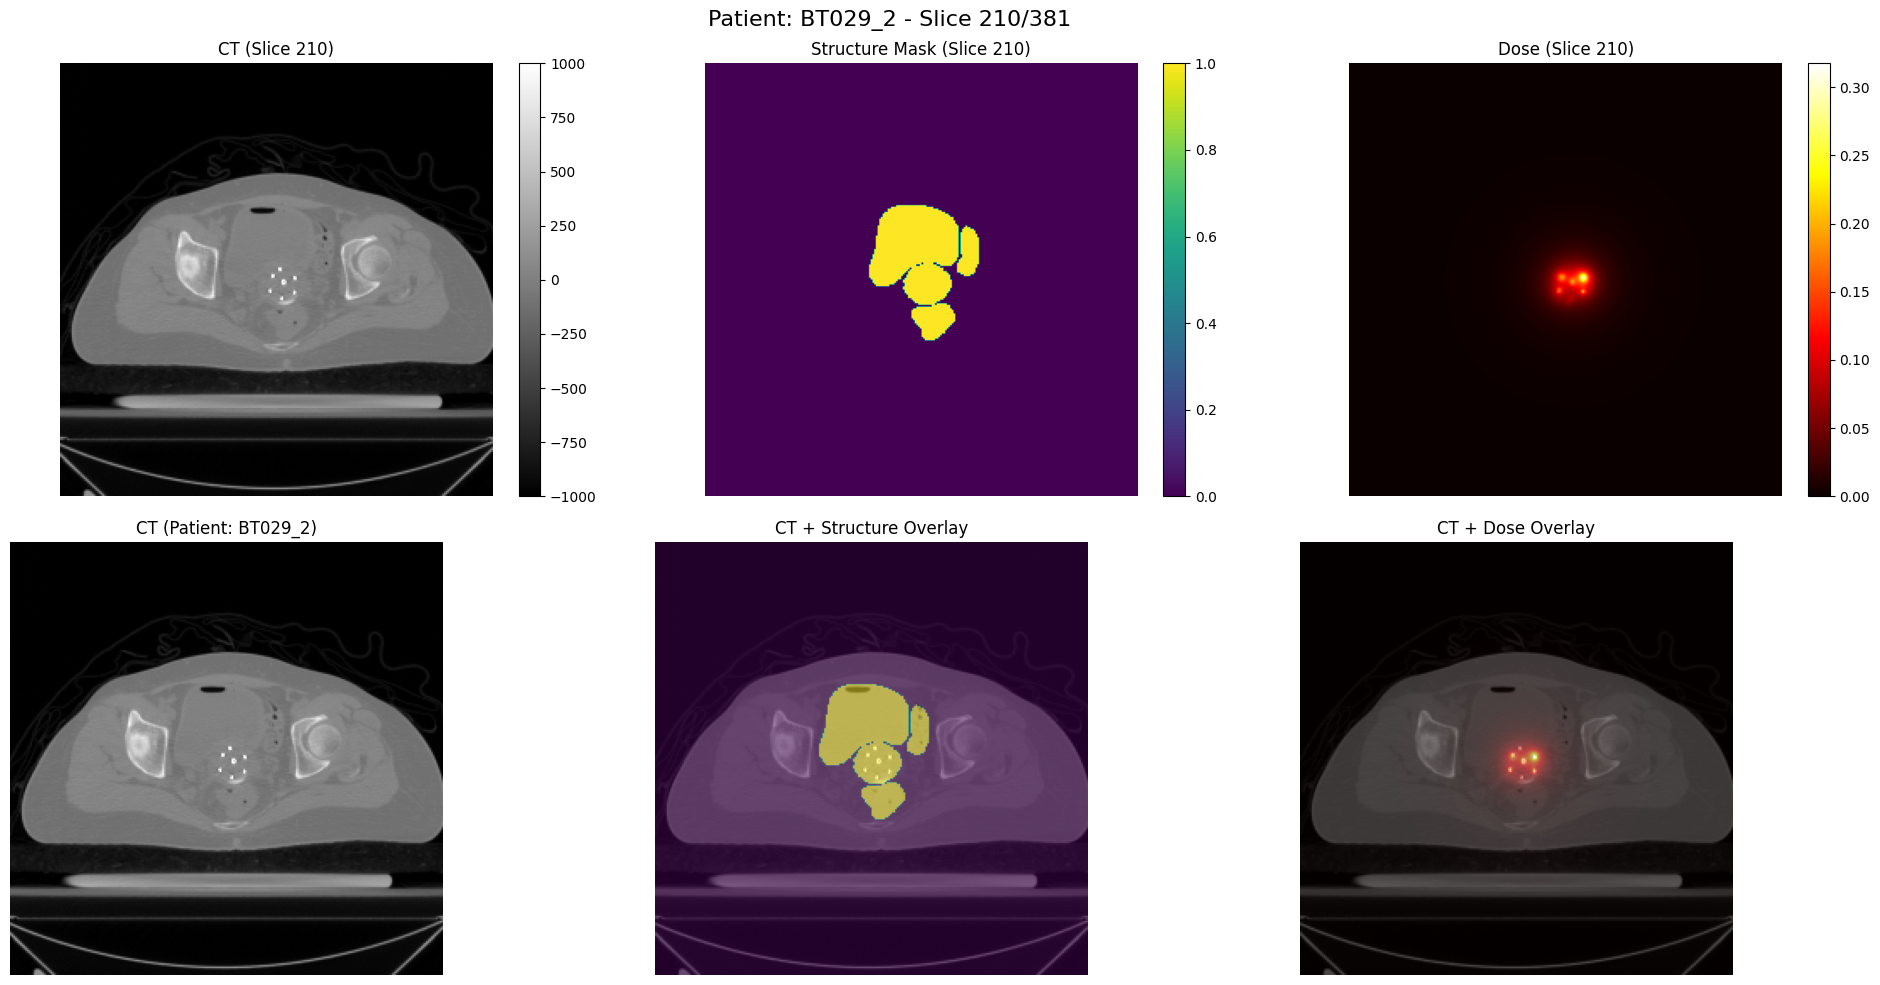

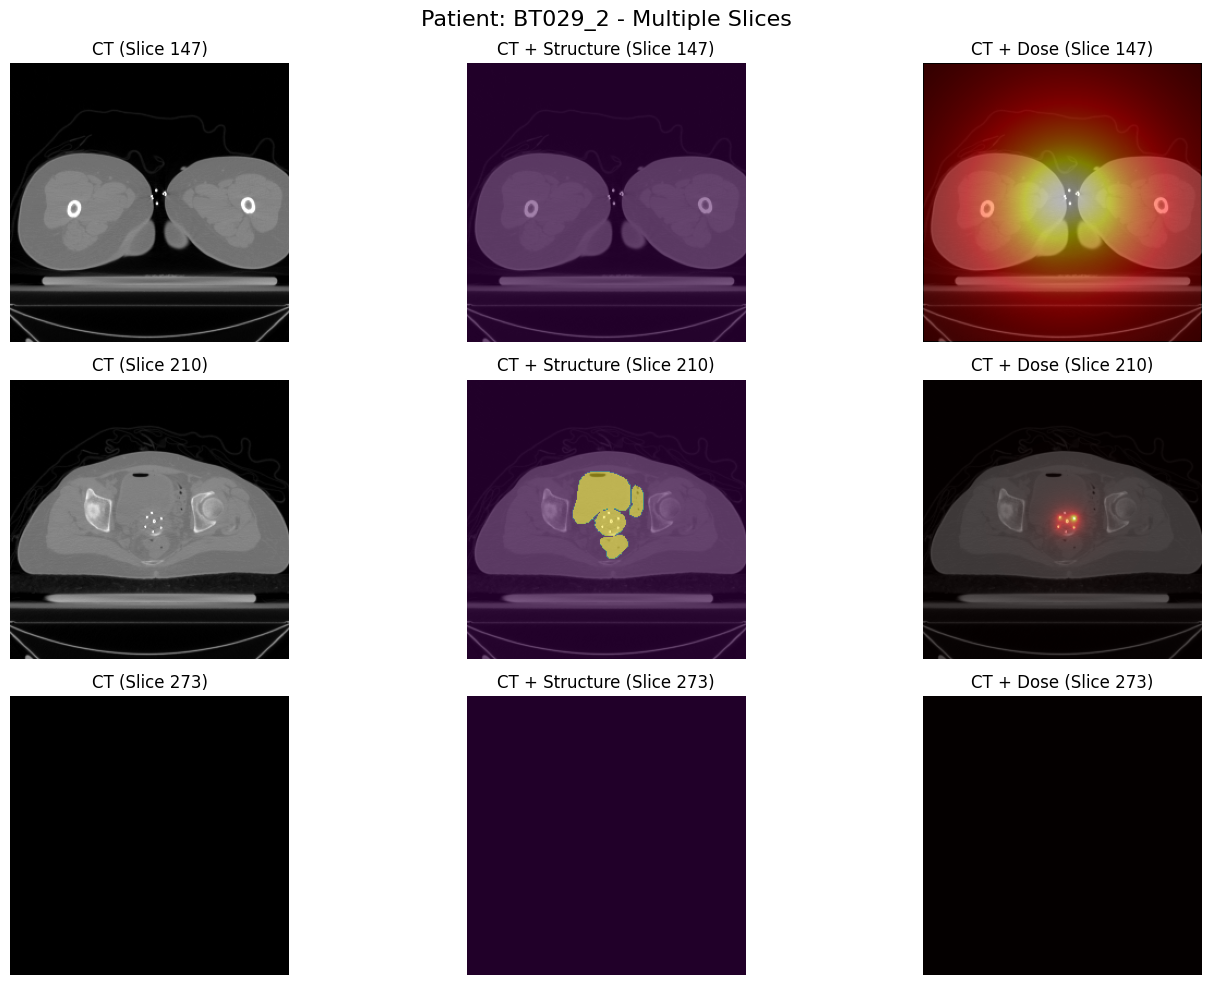

In [6]:
# 2. วิเคราะห์ข้อมูลและสร้างตัวอย่าง
print("\n===== ANALYZING DATA =====")
data_summary, data_stats = analyze_dataset_statistics(data_dict, sample_limit=5)

# ตรวจสอบตัวอย่างข้อมูล
if len(data_dict["train"]["ct"]) > 0:
    sample_idx = 0
    print(f"\nExamining sample {sample_idx} from training set:")
    check_data_sample(
        data_dict["train"]["ct"][sample_idx],
        data_dict["train"]["structure"][sample_idx],
        data_dict["train"]["dose"][sample_idx]
    )
    
    # แสดงภาพตัวอย่าง
    visualize_data_sample(
        data_dict["train"]["ct"][sample_idx],
        data_dict["train"]["structure"][sample_idx],
        data_dict["train"]["dose"][sample_idx],
        save_dir=str(RESULT_DIR / "sample_visualizations")
    )

In [7]:
# 3. สร้าง DataLoader
print("\n===== CREATING DATASETS AND DATALOADERS =====")
data = create_datasets_and_loaders(
    data_dict,
    csv_path=None,
    batch_size=CONFIG['batch_size'],
    normalize=CONFIG['normalize_data'],
    num_workers=CONFIG['num_workers'],
    transforms_enabled=True  # เปิดใช้ data augmentation
)

print(f"Training samples: {len(data['datasets']['train'])}")
print(f"Validation samples: {len(data['datasets']['val'])}")
print(f"Test samples: {len(data['datasets']['test'])}")


===== CREATING DATASETS AND DATALOADERS =====
No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in expected range [0, 1]
✓ Dose values are in normalized range [0, 1]
No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in expected range [0, 1]
✓ Dose values are in normalized range [0, 1]
No metadata file found or specified
Target size: (223, 256, 256)
Checking first sample...
CT: shape=(223, 256, 256), min=0.0000, max=1.0000
Structure: shape=(223, 256, 256), min=0.0000, max=1.0000
Dose: shap

In [8]:
def validate_data_shapes(data_dict):
    for dataset in ['train', 'val', 'test']:
        ct_paths = data_dict[dataset]['ct']
        structure_paths = data_dict[dataset]['structure']
        dose_paths = data_dict[dataset]['dose']
        
        for i, (ct_path, struct_path, dose_path) in enumerate(zip(ct_paths, structure_paths, dose_paths)):
            ct = np.load(ct_path)
            structure = np.load(struct_path)
            dose = np.load(dose_path)
            
            print(f"{dataset} - Sample {i}:")
            print(f"  CT shape: {ct.shape}")
            print(f"  Structure shape: {structure.shape}")
            print(f"  Dose shape: {dose.shape}")
            
            # Verify consistency
            if not (ct.shape == structure.shape == dose.shape):
                print(f"WARNING: Inconsistent shapes for sample {i} in {dataset}")

# Call this before creating datasets
validate_data_shapes(data_dict)

train - Sample 0:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 1:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 2:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 3:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 4:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 5:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 6:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 7:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
train - Sample 8:
  CT shape: (381, 256, 256)
  Structure shape: (381, 256, 256)
  Dose shape: (381, 256, 256)
t

In [9]:
# แก้ไขการตั้งค่า CONFIG 
CONFIG['num_workers'] = 0  
CONFIG['batch_size'] = 1   
CONFIG['use_mixed_precision'] = False  
CONFIG['use_tensorboard'] = False  
CONFIG['model_type'] = "Cascade3DUNet"  
CONFIG['do_cross_validation'] = True 
CONFIG['n_folds'] = 5  

# ตั้งค่า Memory Optimizations
ENABLE_MEMORY_OPTIMIZATIONS = True
MEMORY_CONFIG['enable_memory_cleanup'] = True
MEMORY_CONFIG['memory_cleanup_frequency'] = 1  # ล้างหน่วยความจำทุก epoch
MEMORY_CONFIG['gradient_accumulation_steps'] = 4  # จำลองเสมือนใช้ batch size 4
MEMORY_CONFIG['use_model_checkpoint'] = True 
MEMORY_CONFIG['crop_margin'] = 5
MEMORY_CONFIG['enable_volume_cropping'] = True

print(f"Updated CONFIG: model_type={CONFIG['model_type']}, batch_size={CONFIG['batch_size']}")
print(f"Memory optimization settings: {MEMORY_CONFIG}")
try:
    if CONFIG['do_cross_validation']:
        print("\n===== PERFORMING CROSS-VALIDATION =====")
        cv_results = cross_validation_training(
            data_dict=data_dict,
            n_folds=CONFIG['n_folds'],
            csv_path=None,
            batch_size=CONFIG['batch_size'],
            normalize=CONFIG['normalize_data'],
            num_workers=0,  # ตั้งค่าเป็น 0
            transforms_enabled=True,  # เปิด data augmentation
            model_type="Cascade3DUNet",  # บังคับใช้ Cascade3DUNet
            in_channels=CONFIG['in_channels'],
            out_channels=CONFIG['out_channels'],
            learning_rate=CONFIG['learning_rate'],
            weight_decay=CONFIG['weight_decay'],
            max_epochs=CONFIG['max_epochs'],
            patience=CONFIG['early_stopping_patience'],
            early_stopping_metric=CONFIG['early_stopping_metric'],
            early_stopping_mode=CONFIG['early_stopping_mode'],
            early_stopping_min_delta=CONFIG['early_stopping_min_delta'],
            use_mixed_precision=False, 
            save_best_metrics=CONFIG['save_best_metrics']
        )
        
        # เลือกโมเดลที่ดีที่สุดจากผลการ cross-validation
        best_fold, best_mae, best_model_path = select_best_clinical_model(
                cv_results, RESULT_DIR, OUTPUT_DIR
            )
            
        # โหลดโมเดลที่ดีที่สุดเพื่อใช้ในการทำนาย
        best_model = create_model(
                model_type=CONFIG['model_type'],
                in_channels=CONFIG['in_channels'],
                out_channels=CONFIG['out_channels']
            ).to(device)
            
        checkpoint = torch.load(best_model_path)
        best_model.load_state_dict(checkpoint['model_state_dict'])

        # เพิ่มการกำหนด criterion สำหรับใช้กับ best_model
        best_model_criterion = DosePredictionLoss(high_dose_weight=2.0, gradient_weight=1.0, smoothness_weight=0.5)
        test_results, sample_results = test_model(
            model=best_model,
            test_loader=data["loaders"]["test"],  # ใช้ test_loader จาก data ที่สร้างไว้แล้ว
            criterion=best_model_criterion,
            device=device,
            save_dir=OUTPUT_DIR / "final_test_results",
            save_predictions=True
        )

        # แสดงผลการทดสอบโมเดลที่ดีที่สุด
        print("\n===== Final Test Results (Best Model) =====")
        print(f"MAE: {test_results['mae']:.6f} ± {test_results['mae_std']:.6f}")
        print(f"PSNR: {test_results['psnr']:.2f} ± {test_results['psnr_std']:.2f} dB")
        print(f"Dice@50%: {test_results['dice_50']:.4f}")
        
        if len(data_dict["test"]["ct"]) > 0:
            sample_idx = 0
            sample_ct_path = data_dict["test"]["ct"][sample_idx]
            sample_structure_path = data_dict["test"]["structure"][sample_idx]
            
            # ทำนายปริมาณรังสี
            predicted_dose, output_file = predict_dose(
                model=best_model,
                ct_path=sample_ct_path,
                structure_path=sample_structure_path,
                device=device,
                output_dir=OUTPUT_DIR / "sample_predictions"
            )
            
            print(f"\nSample prediction saved to: {output_file}")
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    
print("Training completed!")

Updated CONFIG: model_type=Cascade3DUNet, batch_size=1
Memory optimization settings: {'batch_size': 1, 'gradient_accumulation_steps': 4, 'input_downsample_factor': 0.75, 'use_model_checkpoint': True, 'mixed_precision_dtype': 'float16', 'monitor_memory_frequency': 5, 'save_checkpoint_frequency': 1, 'enable_volume_cropping': True, 'crop_margin': 5, 'enable_memory_cleanup': True, 'memory_cleanup_frequency': 1, 'reduced_feature_maps': True, 'pin_memory': False, 'use_amp': True, 'cudnn_benchmark': True, 'optimize_cache_size': True, 'limit_cuda_cache_size': 46}

===== PERFORMING CROSS-VALIDATION =====
Total samples for cross-validation: 200

===== Starting Fold 1/5 =====
GPU memory before fold 1:

===== GPU MEMORY USAGE =====
GPU 0: Total: 51.54GB | Reserved: 0.00GB | Allocated: 0.00GB | Free: 51.54GB

No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.

c:\Users\User\miniconda3\envs\mayenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model will be saved to: d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_1\models\best_model.pth
Model structure:
Cascade3DUNet(
  (input_projection): Conv3d(2, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (encoder1): CheckpointedModule(
    (module): SEResidualBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out_features=32, bias=False)
          (3): Sig

Epoch 1/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027

===== DEBUGGING FIRST BATCH =====
Inputs shape: torch.Size([1, 2, 381, 256, 256])
Targets shape: torch.Size([1, 1, 381, 256, 256])
Input CT (channel 0) range: [0.0000, 1.0000]
Input Structure (channel 1) range: [0.0000, 1.0000]
Target Dose range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027
===== END DEBUGGING =====



Epoch 1/200:   6%|▋         | 10/160 [01:22<20:45,  8.30s/it, Loss=0.2929, MAE=0.2655, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 1/200:  12%|█▎        | 20/160 [02:46<19:22,  8.30s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 1/200:  19%|█▉        | 30/160 [04:07<17:33,  8.10s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 1/200:  25%|██▌       | 40/160 [05:23<15:43,  7.86s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 1/200:  31%|███▏      | 50/160 [06:45<14:56,  8.15s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0159


Epoch 1/200:  38%|███▊      | 60/160 [08:08<13:47,  8.27s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 1/200:  44%|████▍     | 70/160 [09:28<12:02,  8.02s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 1/200:  50%|█████     | 80/160 [10:40<09:43,  7.30s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 1/200:  56%|█████▋    | 90/160 [11:51<08:06,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0036


Epoch 1/200:  62%|██████▎   | 100/160 [13:00<06:53,  6.88s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 1/200:  69%|██████▉   | 110/160 [14:09<05:44,  6.89s/it, Loss=0.0002, MAE=0.0001, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 1/200:  75%|███████▌  | 120/160 [15:17<04:34,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 1/200:  81%|████████▏ | 130/160 [16:26<03:26,  6.88s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 1/200:  88%|████████▊ | 140/160 [17:35<02:17,  6.87s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 1/200:  94%|█████████▍| 150/160 [18:44<01:08,  6.88s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 1/200: 100%|██████████| 160/160 [19:53<00:00,  7.46s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 1 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.028128 | Val = 0.000429 | Δ = -0.027700
MAE:  Train = 0.025047 | Val = 0.000389 | Δ = -0.024658
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Model saved at Epoch 1 with best val_loss: 0.0004
Model saved at Epoch 1 with best val_mae: 0.0004
Model saved at Epoch 1 with best val_psnr: 51.3040
Checkpoint saved at epoch 1
Epoch 1/200: Train Loss = 0.0281, Train MAE = 0.0250 ± 0.0923, Val Loss = 0.0004, Val MA

Epoch 2/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 2/200:   6%|▋         | 10/160 [01:08<16:58,  6.79s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 2/200:  12%|█▎        | 20/160 [02:16<15:58,  6.85s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 2/200:  19%|█▉        | 30/160 [03:25<14:48,  6.84s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 2/200:  25%|██▌       | 40/160 [04:33<13:40,  6.84s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 2/200:  31%|███▏      | 50/160 [05:42<12:35,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 2/200:  38%|███▊      | 60/160 [06:51<11:28,  6.88s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 2/200:  44%|████▍     | 70/160 [07:59<10:17,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0096


Epoch 2/200:  50%|█████     | 80/160 [09:08<09:10,  6.88s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 2/200:  56%|█████▋    | 90/160 [10:17<08:01,  6.88s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 2/200:  62%|██████▎   | 100/160 [11:25<06:51,  6.85s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 2/200:  69%|██████▉   | 110/160 [12:34<05:43,  6.88s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0075


Epoch 2/200:  75%|███████▌  | 120/160 [13:49<04:53,  7.33s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 2/200:  81%|████████▏ | 130/160 [14:57<03:26,  6.87s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 2/200:  88%|████████▊ | 140/160 [16:06<02:17,  6.86s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 2/200:  94%|█████████▍| 150/160 [17:15<01:08,  6.87s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 2/200: 100%|██████████| 160/160 [18:24<00:00,  6.90s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 2 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000626 | Val = 0.000429 | Δ = -0.000197
MAE:  Train = 0.000504 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Epoch 2/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.0004 ± 0.0002, PSNR = 51.30 ± 2.93, Dice@50% = 0.0000, Time = 1170.9s, Total = 40.6m
EarlyStopping counter: 1/15 (best val_loss: 0.0004)


Epoch 3/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0056


Epoch 3/200:   6%|▋         | 10/160 [01:08<17:12,  6.89s/it, Loss=0.0267, MAE=0.0140, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 3/200:  12%|█▎        | 20/160 [02:17<16:00,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 3/200:  19%|█▉        | 30/160 [03:26<14:53,  6.88s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 3/200:  25%|██▌       | 40/160 [04:34<13:43,  6.86s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 3/200:  31%|███▏      | 50/160 [05:43<12:35,  6.87s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 3/200:  38%|███▊      | 60/160 [06:52<11:25,  6.85s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 3/200:  44%|████▍     | 70/160 [08:01<10:19,  6.89s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 3/200:  50%|█████     | 80/160 [09:09<09:09,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 3/200:  54%|█████▍    | 87/160 [09:57<08:21,  6.87s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 3/200:  56%|█████▋    | 90/160 [10:18<08:01,  6.89s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 3/200:  62%|██████▎   | 100/160 [11:27<06:51,  6.86s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 3/200:  69%|██████▉   | 110/160 [12:36<05:43,  6.87s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 3/200:  75%|███████▌  | 120/160 [13:45<04:33,  6.85s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 3/200:  81%|████████▏ | 130/160 [14:54<03:27,  6.93s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 3/200:  88%|████████▊ | 140/160 [16:02<02:17,  6.88s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 3/200:  94%|█████████▍| 150/160 [17:11<01:08,  6.89s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 3/200: 100%|██████████| 160/160 [18:20<00:00,  6.88s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 3 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000626 | Val = 0.000429 | Δ = -0.000197
MAE:  Train = 0.000504 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 3/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 4/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 4/200:   6%|▋         | 10/160 [01:08<17:09,  6.87s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 4/200:  12%|█▎        | 20/160 [02:17<16:11,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 4/200:  19%|█▉        | 30/160 [03:27<15:00,  6.93s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 4/200:  25%|██▌       | 40/160 [04:36<13:45,  6.88s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 4/200:  31%|███▏      | 50/160 [05:44<12:35,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 4/200:  38%|███▊      | 60/160 [06:53<11:30,  6.91s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 4/200:  44%|████▍     | 70/160 [08:02<10:21,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 4/200:  50%|█████     | 80/160 [09:11<09:12,  6.91s/it, Loss=0.0267, MAE=0.0140, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 4/200:  56%|█████▋    | 90/160 [10:21<08:06,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 4/200:  62%|██████▎   | 100/160 [11:30<06:51,  6.86s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0120


Epoch 4/200:  69%|██████▉   | 110/160 [12:39<05:46,  6.94s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 4/200:  75%|███████▌  | 120/160 [13:49<04:38,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 4/200:  76%|███████▌  | 121/160 [13:56<04:31,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 4/200:  81%|████████▏ | 130/160 [14:59<03:29,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 4/200:  88%|████████▊ | 140/160 [16:08<02:18,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 4/200:  94%|█████████▍| 150/160 [17:18<01:09,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0118


Epoch 4/200: 100%|██████████| 160/160 [18:27<00:00,  6.92s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 4 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000626 | Val = 0.000429 | Δ = -0.000197
MAE:  Train = 0.000504 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 4/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 5/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 5/200:   6%|▋         | 10/160 [01:08<17:17,  6.91s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 5/200:  12%|█▎        | 20/160 [02:18<16:07,  6.91s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 5/200:  19%|█▉        | 30/160 [03:27<15:03,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 5/200:  25%|██▌       | 40/160 [04:37<13:51,  6.93s/it, Loss=0.0002, MAE=0.0001, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 5/200:  31%|███▏      | 50/160 [05:46<12:41,  6.92s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 5/200:  38%|███▊      | 60/160 [06:55<11:33,  6.93s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 5/200:  44%|████▍     | 70/160 [08:05<10:25,  6.95s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 5/200:  50%|█████     | 80/160 [09:15<09:16,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 5/200:  56%|█████▋    | 90/160 [10:24<08:08,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 5/200:  62%|██████▎   | 100/160 [11:34<06:57,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 5/200:  69%|██████▉   | 110/160 [12:44<05:48,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 5/200:  75%|███████▌  | 120/160 [13:53<04:39,  6.98s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 5/200:  81%|████████▏ | 130/160 [15:03<03:28,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 5/200:  88%|████████▊ | 140/160 [16:13<02:18,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 5/200:  94%|█████████▍| 150/160 [17:22<01:09,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 5/200: 100%|██████████| 160/160 [18:32<00:00,  6.95s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 5 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000626 | Val = 0.000429 | Δ = -0.000197
MAE:  Train = 0.000504 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 5/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 6/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 6/200:   6%|▋         | 10/160 [01:09<17:14,  6.90s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 6/200:  12%|█▎        | 20/160 [02:18<16:17,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 6/200:  19%|█▉        | 30/160 [03:28<15:09,  7.00s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 6/200:  25%|██▌       | 40/160 [04:38<13:58,  6.99s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 6/200:  31%|███▏      | 50/160 [05:48<12:47,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 6/200:  38%|███▊      | 60/160 [06:57<11:34,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 6/200:  44%|████▍     | 70/160 [08:07<10:28,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0159


Epoch 6/200:  50%|█████     | 80/160 [09:17<09:17,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 6/200:  56%|█████▋    | 90/160 [10:27<08:08,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 6/200:  62%|██████▎   | 100/160 [11:36<06:57,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 6/200:  69%|██████▉   | 110/160 [12:46<05:48,  6.97s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 6/200:  75%|███████▌  | 120/160 [13:56<04:39,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 6/200:  81%|████████▏ | 130/160 [15:06<03:28,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 6/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.96s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 6/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 6/200: 100%|██████████| 160/160 [18:35<00:00,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 6 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000626 | Val = 0.000429 | Δ = -0.000197
MAE:  Train = 0.000504 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 6/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.00

Epoch 7/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 7/200:   6%|▋         | 10/160 [01:09<17:22,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 7/200:  12%|█▎        | 20/160 [02:19<16:18,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 7/200:  19%|█▉        | 30/160 [03:29<15:25,  7.12s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 7/200:  25%|██▌       | 40/160 [04:42<14:36,  7.30s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 7/200:  31%|███▏      | 50/160 [05:55<13:19,  7.27s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0006


Epoch 7/200:  38%|███▊      | 60/160 [07:08<12:06,  7.26s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 7/200:  44%|████▍     | 70/160 [08:21<10:55,  7.28s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 7/200:  46%|████▌     | 73/160 [08:42<10:32,  7.27s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 7/200:  50%|█████     | 80/160 [09:33<09:42,  7.28s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 7/200:  56%|█████▋    | 90/160 [10:46<08:25,  7.22s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 7/200:  62%|██████▎   | 100/160 [11:59<07:31,  7.52s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 7/200:  69%|██████▉   | 110/160 [13:10<05:58,  7.16s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0096


Epoch 7/200:  75%|███████▌  | 120/160 [14:24<04:53,  7.33s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 7/200:  81%|████████▏ | 130/160 [15:34<03:29,  6.97s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 7/200:  88%|████████▊ | 140/160 [16:43<02:19,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 7/200:  94%|█████████▍| 150/160 [17:53<01:09,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 7/200: 100%|██████████| 160/160 [19:03<00:00,  7.15s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 7 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000627 | Val = 0.000429 | Δ = -0.000198
MAE:  Train = 0.000505 | Val = 0.000389 | Δ = -0.000116
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 7/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.00

Epoch 8/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 8/200:   6%|▋         | 10/160 [01:08<17:17,  6.92s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 8/200:  12%|█▎        | 20/160 [02:18<16:13,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 8/200:  19%|█▉        | 30/160 [03:28<15:02,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 8/200:  25%|██▌       | 40/160 [04:37<13:51,  6.93s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 8/200:  31%|███▏      | 50/160 [05:46<12:42,  6.93s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 8/200:  33%|███▎      | 53/160 [06:07<12:24,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 8/200:  38%|███▊      | 60/160 [06:56<11:35,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 8/200:  44%|████▍     | 70/160 [08:06<10:28,  6.99s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 8/200:  50%|█████     | 80/160 [09:16<09:16,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 8/200:  56%|█████▋    | 90/160 [10:26<08:09,  6.99s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 8/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 8/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 8/200:  75%|███████▌  | 120/160 [13:55<04:39,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 8/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.99s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 8/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.98s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 8/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0075


Epoch 8/200: 100%|██████████| 160/160 [18:34<00:00,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 8 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000627 | Val = 0.000430 | Δ = -0.000198
MAE:  Train = 0.000505 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000001 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 8/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.00

Epoch 9/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 9/200:   6%|▋         | 10/160 [01:08<17:14,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 9/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 9/200:  19%|█▉        | 30/160 [03:27<15:05,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 9/200:  25%|██▌       | 40/160 [04:37<13:56,  6.97s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 9/200:  31%|███▏      | 50/160 [05:47<12:46,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0071


Epoch 9/200:  38%|███▊      | 60/160 [06:57<11:38,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 9/200:  44%|████▍     | 70/160 [08:07<10:27,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 9/200:  50%|█████     | 80/160 [09:17<09:20,  7.01s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 9/200:  56%|█████▋    | 90/160 [10:27<08:07,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 9/200:  59%|█████▉    | 94/160 [10:55<07:40,  6.98s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 9/200:  62%|██████▎   | 100/160 [11:36<06:58,  6.98s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 9/200:  69%|██████▉   | 110/160 [12:46<05:48,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 9/200:  75%|███████▌  | 120/160 [13:56<04:37,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 9/200:  81%|████████▏ | 130/160 [15:05<03:28,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 9/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.99s/it, Loss=0.0010, MAE=0.0009, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 9/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 9/200: 100%|██████████| 160/160 [18:34<00:00,  6.97s/it, Loss=0.0011, MAE=0.0010, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 9 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000627 | Val = 0.000429 | Δ = -0.000198
MAE:  Train = 0.000505 | Val = 0.000389 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 9/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.00

Epoch 10/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 10/200:   6%|▋         | 10/160 [01:09<17:21,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0096


Epoch 10/200:   7%|▋         | 11/160 [01:16<17:15,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 10/200:  12%|█▎        | 20/160 [02:18<16:13,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 10/200:  19%|█▉        | 30/160 [03:28<15:05,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 10/200:  25%|██▌       | 40/160 [04:38<13:54,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0094


Epoch 10/200:  31%|███▏      | 50/160 [05:47<12:45,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 10/200:  38%|███▊      | 60/160 [06:57<11:36,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 10/200:  44%|████▍     | 70/160 [08:07<10:26,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  50%|█████     | 80/160 [09:16<09:18,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  56%|█████▋    | 90/160 [10:26<08:06,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 10/200:  62%|██████▎   | 100/160 [11:35<06:56,  6.94s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 10/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 10/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 10/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.95s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 10/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 10/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 10/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 10 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000635 | Val = 0.000429 | Δ = -0.000206
MAE:  Train = 0.000507 | Val = 0.000389 | Δ = -0.000118
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000001 ✅
VAL MAE:  -0.000000 ✅
VAL PSNR: 0.00 ✅
Epoch 10/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0

Epoch 11/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 11/200:   6%|▋         | 10/160 [01:08<17:10,  6.87s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0060


Epoch 11/200:  10%|█         | 16/160 [01:50<16:33,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 11/200:  12%|█▎        | 20/160 [02:17<16:06,  6.90s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 11/200:  19%|█▉        | 30/160 [03:27<15:02,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 11/200:  25%|██▌       | 40/160 [04:36<13:50,  6.92s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0120


Epoch 11/200:  31%|███▏      | 50/160 [05:45<12:41,  6.92s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 11/200:  38%|███▊      | 60/160 [06:55<11:31,  6.91s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 11/200:  44%|████▍     | 70/160 [08:04<10:22,  6.92s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 11/200:  50%|█████     | 80/160 [09:13<09:15,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0006


Epoch 11/200:  56%|█████▋    | 90/160 [10:23<08:08,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 11/200:  62%|██████▎   | 100/160 [11:32<06:57,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0213


Epoch 11/200:  69%|██████▉   | 110/160 [12:42<05:47,  6.94s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 11/200:  75%|███████▌  | 120/160 [13:52<04:38,  6.97s/it, Loss=0.0267, MAE=0.0140, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 11/200:  81%|████████▏ | 130/160 [15:01<03:28,  6.96s/it, Loss=0.0013, MAE=0.0012, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 11/200:  88%|████████▊ | 140/160 [16:11<02:19,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 11/200:  94%|█████████▍| 150/160 [17:21<01:09,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 11/200: 100%|██████████| 160/160 [18:30<00:00,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 11 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000626 | Val = 0.000431 | Δ = -0.000195
MAE:  Train = 0.000504 | Val = 0.000390 | Δ = -0.000114
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000002 ❌
VAL MAE:  0.000001 ❌
VAL PSNR: -0.00 ❌
Epoch 11/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 12/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 12/200:   6%|▋         | 10/160 [01:08<17:14,  6.90s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 12/200:  12%|█▎        | 20/160 [02:18<16:09,  6.92s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 12/200:  19%|█▉        | 30/160 [03:27<15:04,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 12/200:  25%|██▌       | 40/160 [04:37<13:52,  6.94s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0094


Epoch 12/200:  31%|███▏      | 50/160 [05:46<12:45,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 12/200:  38%|███▊      | 60/160 [06:56<11:35,  6.95s/it, Loss=0.0002, MAE=0.0001, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 12/200:  44%|████▍     | 70/160 [08:06<10:27,  6.97s/it, Loss=0.0005, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 12/200:  50%|█████     | 80/160 [09:15<09:17,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 12/200:  56%|█████▋    | 90/160 [10:25<08:07,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 12/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 12/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 12/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.97s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 12/200:  81%|████████▏ | 130/160 [15:04<03:29,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0052


Epoch 12/200:  82%|████████▎ | 132/160 [15:18<03:16,  7.01s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 12/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 12/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 12/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 12 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000629 | Val = 0.000429 | Δ = -0.000200
MAE:  Train = 0.000506 | Val = 0.000389 | Δ = -0.000116
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 12/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 13/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 13/200:   6%|▋         | 10/160 [01:09<17:21,  6.94s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 13/200:  12%|█▎        | 20/160 [02:19<16:18,  6.99s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 13/200:  19%|█▉        | 30/160 [03:29<15:10,  7.00s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 13/200:  25%|██▌       | 40/160 [04:39<13:58,  6.99s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 13/200:  31%|███       | 49/160 [05:42<12:56,  6.99s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 13/200:  31%|███▏      | 50/160 [05:49<12:50,  7.00s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 13/200:  38%|███▊      | 60/160 [06:59<11:38,  6.99s/it, Loss=0.0011, MAE=0.0010, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 13/200:  44%|████▍     | 70/160 [08:08<10:26,  6.96s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 13/200:  50%|█████     | 80/160 [09:18<09:16,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 13/200:  56%|█████▋    | 90/160 [10:27<08:07,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 13/200:  62%|██████▎   | 100/160 [11:37<06:57,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 13/200:  69%|██████▉   | 110/160 [12:47<05:47,  6.95s/it, Loss=0.0010, MAE=0.0010, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 13/200:  75%|███████▌  | 120/160 [13:56<04:38,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 13/200:  81%|████████▏ | 130/160 [15:06<03:29,  6.97s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 13/200:  88%|████████▊ | 140/160 [16:16<02:19,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 13/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 13/200: 100%|██████████| 160/160 [18:35<00:00,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 13 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000628 | Val = 0.000430 | Δ = -0.000198
MAE:  Train = 0.000505 | Val = 0.000389 | Δ = -0.000116
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000002 ✅
VAL MAE:  -0.000001 ✅
VAL PSNR: 0.00 ✅
Epoch 13/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0

Epoch 14/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 14/200:   6%|▋         | 10/160 [01:09<17:19,  6.93s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 14/200:  12%|█▎        | 20/160 [02:18<16:12,  6.95s/it, Loss=0.0011, MAE=0.0010, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 14/200:  19%|█▉        | 30/160 [03:28<15:04,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 14/200:  24%|██▍       | 39/160 [04:31<13:59,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 14/200:  25%|██▌       | 40/160 [04:38<13:54,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  31%|███▏      | 50/160 [05:47<12:43,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 14/200:  38%|███▊      | 60/160 [06:56<11:34,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 14/200:  44%|████▍     | 70/160 [08:06<10:24,  6.94s/it, Loss=0.0008, MAE=0.0007, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 14/200:  50%|█████     | 80/160 [09:15<09:16,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 14/200:  56%|█████▋    | 90/160 [10:25<08:07,  6.97s/it, Loss=0.0007, MAE=0.0007, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 14/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 14/200:  69%|██████▉   | 110/160 [12:44<05:48,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 14/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  81%|████████▏ | 130/160 [15:04<03:29,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  88%|████████▊ | 140/160 [16:13<02:19,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 14/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 14/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 14 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000627 | Val = 0.000429 | Δ = -0.000198
MAE:  Train = 0.000505 | Val = 0.000389 | Δ = -0.000116
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000000 ✅
VAL MAE:  -0.000000 ✅
VAL PSNR: 0.00 ✅
Epoch 14/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0

Epoch 15/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0052


Epoch 15/200:   6%|▋         | 10/160 [01:08<17:16,  6.91s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 15/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0011, MAE=0.0010, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 15/200:  19%|█▉        | 30/160 [03:28<15:07,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 15/200:  25%|██▌       | 40/160 [04:37<13:56,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 15/200:  31%|███▏      | 50/160 [05:47<12:46,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 15/200:  38%|███▊      | 60/160 [06:57<11:38,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 15/200:  44%|████▍     | 70/160 [08:07<10:28,  6.99s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 15/200:  50%|█████     | 80/160 [09:16<09:17,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 15/200:  56%|█████▋    | 90/160 [10:26<08:08,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 15/200:  62%|██████▎   | 100/160 [11:36<06:58,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 15/200:  69%|██████▉   | 110/160 [12:46<05:48,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 15/200:  73%|███████▎  | 117/160 [13:35<05:00,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 15/200:  75%|███████▌  | 120/160 [13:56<04:39,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 15/200:  81%|████████▏ | 130/160 [15:05<03:28,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 15/200:  88%|████████▊ | 140/160 [16:15<02:18,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 15/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 15/200: 100%|██████████| 160/160 [18:34<00:00,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 15 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000627 | Val = 0.000431 | Δ = -0.000197
MAE:  Train = 0.000505 | Val = 0.000390 | Δ = -0.000115
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000001 ❌
VAL MAE:  0.000001 ❌
VAL PSNR: -0.00 ❌
Epoch 15/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 16/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0061


Epoch 16/200:   6%|▋         | 10/160 [01:08<17:19,  6.93s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 16/200:  12%|█▎        | 20/160 [02:18<16:13,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 16/200:  19%|█▉        | 30/160 [03:28<15:08,  6.99s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 16/200:  20%|██        | 32/160 [03:42<14:55,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 16/200:  25%|██▌       | 40/160 [04:38<13:55,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0075


Epoch 16/200:  31%|███▏      | 50/160 [05:48<12:49,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 16/200:  38%|███▊      | 60/160 [06:57<11:39,  7.00s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 16/200:  44%|████▍     | 70/160 [08:07<10:26,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 16/200:  50%|█████     | 80/160 [09:17<09:17,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 16/200:  56%|█████▋    | 90/160 [10:26<08:06,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 16/200:  62%|██████▎   | 100/160 [11:36<06:58,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 16/200:  69%|██████▉   | 110/160 [12:46<05:47,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 16/200:  75%|███████▌  | 120/160 [13:55<04:37,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 16/200:  81%|████████▏ | 130/160 [15:05<03:28,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 16/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 16/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 16/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0037
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 16 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000630 | Val = 0.000430 | Δ = -0.000200
MAE:  Train = 0.000506 | Val = 0.000389 | Δ = -0.000117
PSNR: Val = 51.30 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 16/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

[Dataset] Sample 0: CT shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 223, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0058
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Testing: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_12168\2031338781.py:2071: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dice_data, labels=['25%', '50%', '75%'])



Test Results:
Loss: 0.000688
MAE: 0.000622 ± 0.000305
PSNR: 49.37 ± 3.09 dB
Dice@50%: 0.0000
Dice@25%: 0.0000
Dice@75%: 0.0000
Results saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_1\results
Error in fold 1: cannot access local variable 'checkpoint' where it is not associated with a value
Error details saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_1\error_fold_1.log
Clearing GPU memory after error in fold 1

===== Starting Fold 2/5 =====
GPU memory before fold 2:

===== GPU MEMORY USAGE =====
GPU 0: Total: 51.54GB | Reserved: 5.75GB | Allocated: 0.31GB | Free: 51.23GB

No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in e

c:\Users\User\miniconda3\envs\mayenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Applying gradient checkpointing to model...
Model will be saved to: d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_2\models\best_model.pth
Model structure:
Cascade3DUNet(
  (input_projection): Conv3d(2, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (encoder1): CheckpointedModule(
    (module): SEResidualBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out

Epoch 1/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011

===== DEBUGGING FIRST BATCH =====
Inputs shape: torch.Size([1, 2, 381, 256, 256])
Targets shape: torch.Size([1, 1, 381, 256, 256])
Input CT (channel 0) range: [0.0000, 1.0000]
Input Structure (channel 1) range: [0.0000, 1.0000]
Target Dose range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011
===== END DEBUGGING =====



Epoch 1/200:   6%|▋         | 10/160 [01:09<17:15,  6.90s/it, Loss=0.0156, MAE=0.0111, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 1/200:  12%|█▎        | 20/160 [02:18<16:12,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 1/200:  19%|█▉        | 30/160 [03:27<14:51,  6.85s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  25%|██▌       | 40/160 [04:35<13:44,  6.87s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 1/200:  31%|███▏      | 50/160 [05:44<12:36,  6.88s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  38%|███▊      | 60/160 [06:53<11:25,  6.86s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  44%|████▍     | 70/160 [08:01<10:17,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 1/200:  50%|█████     | 80/160 [09:10<09:09,  6.87s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 1/200:  56%|█████▋    | 90/160 [10:19<08:01,  6.88s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 1/200:  62%|██████▎   | 100/160 [11:27<06:52,  6.88s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 1/200:  69%|██████▉   | 110/160 [12:36<05:43,  6.86s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  74%|███████▍  | 119/160 [13:38<04:42,  6.89s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 1/200:  75%|███████▌  | 120/160 [13:45<04:35,  6.90s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 1/200:  81%|████████▏ | 130/160 [14:54<03:26,  6.88s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 1/200:  88%|████████▊ | 140/160 [16:03<02:17,  6.88s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 1/200:  94%|█████████▍| 150/160 [17:12<01:09,  6.91s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 1/200: 100%|██████████| 160/160 [18:21<00:00,  6.88s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 1 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.024903 | Val = 0.000411 | Δ = -0.024491
MAE:  Train = 0.022520 | Val = 0.000372 | Δ = -0.022148
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Model saved at Epoch 1 with best val_loss: 0.0004
Model saved at Epoch 1 with best val_mae: 0.0004
Model saved at Epoch 1 with best val_psnr: 51.5515
Checkpoint saved at epoch 1
Epoch 1/200: Train Loss = 0.0249, Train MAE = 0.0225 ± 0.0940, Val Loss = 0.0004, Val MA

Epoch 2/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 2/200:   6%|▋         | 10/160 [01:07<17:00,  6.81s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 2/200:  12%|█▎        | 20/160 [02:16<16:02,  6.87s/it, Loss=0.0013, MAE=0.0012, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 2/200:  19%|█▉        | 30/160 [03:25<14:51,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 2/200:  25%|██▌       | 40/160 [04:33<13:39,  6.83s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 2/200:  31%|███▏      | 50/160 [05:41<12:32,  6.84s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 2/200:  38%|███▊      | 60/160 [06:50<11:20,  6.81s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 2/200:  44%|████▍     | 70/160 [07:58<10:13,  6.82s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0060


Epoch 2/200:  50%|█████     | 80/160 [09:07<09:06,  6.83s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 2/200:  56%|█████▋    | 90/160 [10:15<07:57,  6.82s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 2/200:  62%|██████▎   | 100/160 [11:23<06:50,  6.84s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 2/200:  69%|██████▉   | 110/160 [12:32<05:42,  6.85s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 2/200:  75%|███████▌  | 120/160 [13:40<04:32,  6.80s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 2/200:  81%|████████▏ | 130/160 [14:48<03:24,  6.83s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 2/200:  88%|████████▊ | 140/160 [15:56<02:16,  6.83s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 2/200:  92%|█████████▎| 148/160 [16:51<01:22,  6.84s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 2/200:  94%|█████████▍| 150/160 [17:05<01:08,  6.86s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 2/200: 100%|██████████| 160/160 [18:13<00:00,  6.83s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 2 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000630 | Val = 0.000411 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Epoch 2/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.0004 ± 0.0002, PSNR = 51.55 ± 2.94, Dice@50% = 0.0000, Time = 1155.9s, Total = 38.8m
EarlyStopping counter: 1/15 (best val_loss: 0.0004)


Epoch 3/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 3/200:   6%|▋         | 10/160 [01:07<17:02,  6.82s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 3/200:  12%|█▎        | 20/160 [02:16<15:58,  6.85s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 3/200:  19%|█▉        | 30/160 [03:25<14:54,  6.88s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 3/200:  25%|██▌       | 40/160 [04:34<13:45,  6.88s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 3/200:  31%|███▏      | 50/160 [05:43<12:35,  6.87s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 3/200:  38%|███▊      | 60/160 [06:51<11:27,  6.87s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 3/200:  44%|████▍     | 70/160 [08:00<10:17,  6.86s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 3/200:  50%|█████     | 80/160 [09:09<09:07,  6.85s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 3/200:  56%|█████▋    | 90/160 [10:17<07:59,  6.85s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0058


Epoch 3/200:  62%|██████▎   | 100/160 [11:26<06:51,  6.86s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0084


Epoch 3/200:  64%|██████▍   | 102/160 [11:40<06:38,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 3/200:  69%|██████▉   | 110/160 [12:35<05:44,  6.89s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 3/200:  75%|███████▌  | 120/160 [13:44<04:34,  6.87s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 3/200:  81%|████████▏ | 130/160 [14:52<03:25,  6.86s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 3/200:  88%|████████▊ | 140/160 [16:01<02:16,  6.85s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 3/200:  94%|█████████▍| 150/160 [17:10<01:08,  6.87s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 3/200: 100%|██████████| 160/160 [18:19<00:00,  6.87s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 3 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000630 | Val = 0.000411 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 3/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 4/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 4/200:   6%|▋         | 10/160 [01:08<17:09,  6.86s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 4/200:  12%|█▎        | 20/160 [02:17<16:06,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 4/200:  19%|█▉        | 30/160 [03:26<15:01,  6.94s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 4/200:  25%|██▌       | 40/160 [04:36<13:54,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 4/200:  31%|███▏      | 50/160 [05:45<12:46,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 4/200:  34%|███▍      | 55/160 [06:20<12:11,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 4/200:  38%|███▊      | 60/160 [06:55<11:38,  6.98s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 4/200:  44%|████▍     | 70/160 [08:05<10:23,  6.93s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 4/200:  50%|█████     | 80/160 [09:14<09:15,  6.94s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 4/200:  56%|█████▋    | 90/160 [10:24<08:05,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 4/200:  62%|██████▎   | 100/160 [11:33<06:59,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 4/200:  69%|██████▉   | 110/160 [12:43<05:47,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 4/200:  75%|███████▌  | 120/160 [13:53<04:37,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 4/200:  81%|████████▏ | 130/160 [15:03<03:29,  6.98s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 4/200:  88%|████████▊ | 140/160 [16:12<02:19,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0102


Epoch 4/200:  94%|█████████▍| 150/160 [17:22<01:09,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 4/200: 100%|██████████| 160/160 [18:31<00:00,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 4 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000630 | Val = 0.000411 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 4/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 5/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 5/200:   6%|▋         | 10/160 [01:09<17:17,  6.92s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 5/200:  12%|█▎        | 20/160 [02:18<16:08,  6.92s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 5/200:  19%|█▉        | 30/160 [03:27<15:01,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 5/200:  25%|██▌       | 40/160 [04:37<13:59,  6.99s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 5/200:  31%|███▏      | 50/160 [05:47<12:45,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 5/200:  38%|███▊      | 60/160 [06:57<11:35,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 5/200:  44%|████▍     | 70/160 [08:06<10:27,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 5/200:  50%|█████     | 80/160 [09:16<09:16,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 5/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 5/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 5/200:  65%|██████▌   | 104/160 [12:03<06:30,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 5/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 5/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0058


Epoch 5/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 5/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.99s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 5/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 5/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 5 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000630 | Val = 0.000411 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 5/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 6/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 6/200:   6%|▋         | 10/160 [01:09<17:17,  6.91s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 6/200:  12%|█▎        | 20/160 [02:18<16:15,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 6/200:  19%|█▉        | 30/160 [03:28<15:09,  7.00s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 6/200:  25%|██▌       | 40/160 [04:38<13:55,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 6/200:  31%|███▏      | 50/160 [05:48<12:45,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 6/200:  38%|███▊      | 60/160 [06:57<11:37,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 6/200:  44%|████▍     | 70/160 [08:07<10:26,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 6/200:  50%|█████     | 80/160 [09:17<09:18,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 6/200:  56%|█████▋    | 90/160 [10:26<08:08,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0058


Epoch 6/200:  62%|██████▎   | 100/160 [11:36<06:57,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 6/200:  66%|██████▋   | 106/160 [12:18<06:16,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 6/200:  69%|██████▉   | 110/160 [12:46<05:50,  7.01s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 6/200:  75%|███████▌  | 120/160 [13:56<04:39,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 6/200:  81%|████████▏ | 130/160 [15:06<03:29,  6.98s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 6/200:  88%|████████▊ | 140/160 [16:16<02:19,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 6/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 6/200: 100%|██████████| 160/160 [18:35<00:00,  6.97s/it, Loss=0.0013, MAE=0.0012, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 6 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000630 | Val = 0.000411 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 6/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 7/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 7/200:   6%|▋         | 10/160 [01:08<17:13,  6.89s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 7/200:  12%|█▎        | 20/160 [02:18<16:10,  6.93s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 7/200:  17%|█▋        | 27/160 [03:06<15:24,  6.95s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 7/200:  19%|█▉        | 30/160 [03:27<15:00,  6.93s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 7/200:  25%|██▌       | 40/160 [04:36<13:51,  6.93s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 7/200:  31%|███▏      | 50/160 [05:45<12:43,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 7/200:  38%|███▊      | 60/160 [06:55<11:36,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 7/200:  44%|████▍     | 70/160 [08:04<10:21,  6.91s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 7/200:  50%|█████     | 80/160 [09:13<09:14,  6.93s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0060


Epoch 7/200:  56%|█████▋    | 90/160 [10:23<08:04,  6.92s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 7/200:  62%|██████▎   | 100/160 [11:32<06:56,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 7/200:  69%|██████▉   | 110/160 [12:41<05:47,  6.94s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 7/200:  75%|███████▌  | 120/160 [13:51<04:38,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 7/200:  81%|████████▏ | 130/160 [15:01<03:29,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 7/200:  88%|████████▊ | 140/160 [16:11<02:20,  7.00s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 7/200:  94%|█████████▍| 150/160 [17:21<01:09,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 7/200: 100%|██████████| 160/160 [18:30<00:00,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 7 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000631 | Val = 0.000411 | Δ = -0.000220
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 7/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 8/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 8/200:   6%|▋         | 10/160 [01:09<17:19,  6.93s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 8/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 8/200:  19%|█▉        | 30/160 [03:28<15:09,  6.99s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 8/200:  25%|██▌       | 40/160 [04:38<13:56,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 8/200:  31%|███▏      | 50/160 [05:47<12:43,  6.94s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 8/200:  38%|███▊      | 60/160 [06:57<11:34,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 8/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0011, MAE=0.0010, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 8/200:  50%|█████     | 80/160 [09:16<09:15,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 8/200:  56%|█████▋    | 90/160 [10:26<08:06,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 8/200:  62%|██████▎   | 100/160 [11:35<06:56,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 8/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0058


Epoch 8/200:  75%|███████▌  | 120/160 [13:54<04:37,  6.93s/it, Loss=0.0002, MAE=0.0001, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 8/200:  78%|███████▊  | 124/160 [14:22<04:09,  6.93s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 8/200:  81%|████████▏ | 130/160 [15:03<03:27,  6.90s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 8/200:  88%|████████▊ | 140/160 [16:13<02:18,  6.93s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 8/200:  94%|█████████▍| 150/160 [17:22<01:09,  6.94s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 8/200: 100%|██████████| 160/160 [18:32<00:00,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 8 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000631 | Val = 0.000411 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 8/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.000

Epoch 9/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 9/200:   6%|▋         | 10/160 [01:08<17:10,  6.87s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 9/200:  12%|█▎        | 20/160 [02:17<16:06,  6.90s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 9/200:  19%|█▉        | 30/160 [03:26<14:56,  6.90s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 9/200:  25%|██▌       | 40/160 [04:36<13:59,  7.00s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 9/200:  31%|███▏      | 50/160 [05:46<12:44,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 9/200:  38%|███▊      | 60/160 [06:55<11:37,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 9/200:  44%|████▍     | 70/160 [08:05<10:25,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0056


Epoch 9/200:  50%|█████     | 80/160 [09:15<09:16,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 9/200:  56%|█████▋    | 90/160 [10:24<08:07,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 9/200:  62%|██████▎   | 100/160 [11:34<06:58,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 9/200:  69%|██████▉   | 110/160 [12:44<05:47,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 9/200:  71%|███████   | 113/160 [13:05<05:27,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 9/200:  75%|███████▌  | 120/160 [13:53<04:38,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 9/200:  81%|████████▏ | 130/160 [15:03<03:29,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 9/200:  88%|████████▊ | 140/160 [16:13<02:19,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 9/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 9/200: 100%|██████████| 160/160 [18:32<00:00,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 9 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000631 | Val = 0.000411 | Δ = -0.000220
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 9/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.00

Epoch 10/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 10/200:   6%|▋         | 10/160 [01:08<17:12,  6.88s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0039


Epoch 10/200:   7%|▋         | 11/160 [01:15<17:09,  6.91s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 10/200:  12%|█▎        | 20/160 [02:18<16:11,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 10/200:  19%|█▉        | 30/160 [03:27<14:56,  6.89s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 10/200:  25%|██▌       | 40/160 [04:36<13:49,  6.91s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 10/200:  31%|███▏      | 50/160 [05:46<12:45,  6.96s/it, Loss=0.0010, MAE=0.0010, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 10/200:  38%|███▊      | 60/160 [06:55<11:29,  6.90s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 10/200:  44%|████▍     | 70/160 [08:04<10:23,  6.92s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 10/200:  50%|█████     | 80/160 [09:13<09:10,  6.89s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 10/200:  56%|█████▋    | 90/160 [10:22<08:02,  6.90s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 10/200:  62%|██████▎   | 100/160 [11:31<06:53,  6.90s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 10/200:  69%|██████▉   | 110/160 [12:40<05:45,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 10/200:  75%|███████▌  | 120/160 [13:49<04:36,  6.91s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 10/200:  81%|████████▏ | 130/160 [14:59<03:28,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 10/200:  88%|████████▊ | 140/160 [16:09<02:19,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 10/200:  94%|█████████▍| 150/160 [17:18<01:09,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 10/200: 100%|██████████| 160/160 [18:28<00:00,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 10 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000632 | Val = 0.000411 | Δ = -0.000221
MAE:  Train = 0.000510 | Val = 0.000372 | Δ = -0.000137
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 10/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 11/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 11/200:   2%|▎         | 4/160 [00:27<17:58,  6.92s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 11/200:   6%|▋         | 10/160 [01:09<17:18,  6.92s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0056


Epoch 11/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 11/200:  19%|█▉        | 30/160 [03:28<15:08,  6.99s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 11/200:  25%|██▌       | 40/160 [04:51<16:41,  8.35s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 11/200:  31%|███▏      | 50/160 [06:14<15:20,  8.37s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 11/200:  38%|███▊      | 60/160 [07:38<13:52,  8.32s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 11/200:  44%|████▍     | 70/160 [09:01<12:35,  8.39s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 11/200:  50%|█████     | 80/160 [10:24<11:06,  8.34s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 11/200:  56%|█████▋    | 90/160 [11:46<09:43,  8.34s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 11/200:  62%|██████▎   | 100/160 [12:59<07:02,  7.04s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 11/200:  69%|██████▉   | 110/160 [14:09<05:48,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 11/200:  75%|███████▌  | 120/160 [15:18<04:38,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 11/200:  81%|████████▏ | 130/160 [16:28<03:28,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 11/200:  88%|████████▊ | 140/160 [17:38<02:19,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 11/200:  94%|█████████▍| 150/160 [18:48<01:09,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 11/200: 100%|██████████| 160/160 [19:57<00:00,  7.49s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 11 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000632 | Val = 0.000411 | Δ = -0.000220
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000137
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 11/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 12/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 12/200:   6%|▋         | 10/160 [01:08<17:20,  6.93s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0213


Epoch 12/200:  12%|█▎        | 20/160 [02:18<16:10,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 12/200:  19%|█▉        | 30/160 [03:27<14:58,  6.91s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 12/200:  25%|██▌       | 40/160 [04:36<13:49,  6.91s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 12/200:  31%|███▏      | 50/160 [05:46<12:43,  6.94s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 12/200:  38%|███▊      | 60/160 [06:55<11:33,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 12/200:  44%|████▍     | 70/160 [08:04<10:21,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 12/200:  50%|█████     | 80/160 [09:13<09:13,  6.92s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 12/200:  56%|█████▋    | 90/160 [10:23<08:05,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 12/200:  62%|██████▎   | 100/160 [11:32<06:52,  6.88s/it, Loss=0.0011, MAE=0.0010, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 12/200:  69%|██████▉   | 110/160 [12:41<05:44,  6.89s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0096


Epoch 12/200:  74%|███████▍  | 118/160 [13:36<04:50,  6.91s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 12/200:  75%|███████▌  | 120/160 [13:50<04:36,  6.92s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 12/200:  81%|████████▏ | 130/160 [15:00<03:27,  6.92s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 12/200:  88%|████████▊ | 140/160 [16:09<02:18,  6.92s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 12/200:  94%|█████████▍| 150/160 [17:18<01:09,  6.93s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 12/200: 100%|██████████| 160/160 [18:28<00:00,  6.93s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 12 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000633 | Val = 0.000411 | Δ = -0.000221
MAE:  Train = 0.000510 | Val = 0.000372 | Δ = -0.000138
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 12/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 13/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 13/200:   6%|▋         | 10/160 [01:09<17:25,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 13/200:   8%|▊         | 13/160 [01:30<17:09,  7.00s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 13/200:  12%|█▎        | 20/160 [02:19<16:16,  6.98s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 13/200:  19%|█▉        | 30/160 [03:28<15:05,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 13/200:  25%|██▌       | 40/160 [04:38<13:56,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 13/200:  31%|███▏      | 50/160 [05:48<12:46,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 13/200:  38%|███▊      | 60/160 [06:58<11:36,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 13/200:  44%|████▍     | 70/160 [08:08<10:26,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 13/200:  50%|█████     | 80/160 [09:17<09:16,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 13/200:  56%|█████▋    | 90/160 [10:27<08:09,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 13/200:  62%|██████▎   | 100/160 [11:37<06:58,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 13/200:  69%|██████▉   | 110/160 [12:47<05:48,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 13/200:  75%|███████▌  | 120/160 [13:57<04:38,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 13/200:  81%|████████▏ | 130/160 [15:06<03:28,  6.96s/it, Loss=0.0267, MAE=0.0140, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 13/200:  88%|████████▊ | 140/160 [16:16<02:19,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0094


Epoch 13/200:  94%|█████████▍| 150/160 [17:26<01:09,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 13/200: 100%|██████████| 160/160 [18:35<00:00,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 13 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000631 | Val = 0.000412 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 13/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 14/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 14/200:   6%|▋         | 10/160 [01:09<17:21,  6.95s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 14/200:  12%|█▎        | 20/160 [02:18<16:13,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 14/200:  16%|█▌        | 25/160 [02:53<15:41,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 14/200:  19%|█▉        | 30/160 [03:28<15:10,  7.00s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 14/200:  25%|██▌       | 40/160 [04:38<13:55,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 14/200:  31%|███▏      | 50/160 [05:48<12:46,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 14/200:  38%|███▊      | 60/160 [06:57<11:31,  6.91s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 14/200:  44%|████▍     | 70/160 [08:07<10:26,  6.97s/it, Loss=0.0007, MAE=0.0007, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  50%|█████     | 80/160 [09:16<09:14,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 14/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 14/200:  62%|██████▎   | 100/160 [11:36<06:58,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 14/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 14/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 14/200:  81%|████████▏ | 130/160 [15:05<03:28,  6.96s/it, Loss=0.0007, MAE=0.0007, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 14/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 14/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 14/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0002, MAE=0.0001, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 14 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000631 | Val = 0.000412 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000136
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 14/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 15/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 15/200:   6%|▋         | 10/160 [01:08<17:16,  6.91s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 15/200:  12%|█▎        | 20/160 [02:18<16:11,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 15/200:  19%|█▉        | 30/160 [03:27<15:03,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 15/200:  25%|██▌       | 40/160 [04:37<13:54,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 15/200:  31%|███▏      | 50/160 [05:47<12:46,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 15/200:  38%|███▊      | 60/160 [06:56<11:37,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 15/200:  44%|████▍     | 70/160 [08:06<10:27,  6.97s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 15/200:  50%|█████     | 80/160 [09:16<09:16,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 15/200:  56%|█████▋    | 90/160 [10:26<08:08,  6.97s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 15/200:  62%|██████▎   | 100/160 [11:35<06:58,  6.97s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 15/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 15/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 15/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 15/200:  82%|████████▎ | 132/160 [15:19<03:15,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 15/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 15/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 15/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 15 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000633 | Val = 0.000412 | Δ = -0.000222
MAE:  Train = 0.000510 | Val = 0.000372 | Δ = -0.000138
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 15/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Epoch 16/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 16/200:   6%|▋         | 10/160 [01:09<17:20,  6.93s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 16/200:  12%|█▎        | 20/160 [02:19<16:16,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 16/200:  19%|█▉        | 30/160 [03:28<15:07,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 16/200:  25%|██▌       | 40/160 [04:38<13:54,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 16/200:  31%|███▏      | 50/160 [05:48<12:46,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 16/200:  38%|███▊      | 60/160 [06:57<11:36,  6.96s/it, Loss=0.0011, MAE=0.0010, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0071


Epoch 16/200:  44%|████▍     | 70/160 [08:07<10:25,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 16/200:  50%|█████     | 80/160 [09:17<09:17,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 16/200:  56%|█████▋    | 90/160 [10:26<08:06,  6.95s/it, Loss=0.0009, MAE=0.0008, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 16/200:  62%|██████▎   | 100/160 [11:36<06:56,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 16/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 16/200:  70%|███████   | 112/160 [12:59<05:34,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 16/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 16/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 16/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 16/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.95s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 16/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0050
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 16 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000631 | Val = 0.000412 | Δ = -0.000219
MAE:  Train = 0.000509 | Val = 0.000372 | Δ = -0.000137
PSNR: Val = 51.55 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 16/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0004, Val MAE = 0.

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

[Dataset] Sample 0: CT shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 223, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0058
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Testing: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_12168\2031338781.py:2071: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dice_data, labels=['25%', '50%', '75%'])



Test Results:
Loss: 0.000686
MAE: 0.000621 ± 0.000305
PSNR: 49.37 ± 3.09 dB
Dice@50%: 0.0000
Dice@25%: 0.0000
Dice@75%: 0.0000
Results saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_2\results
Error in fold 2: cannot access local variable 'checkpoint' where it is not associated with a value
Error details saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_2\error_fold_2.log
Clearing GPU memory after error in fold 2

===== Starting Fold 3/5 =====
GPU memory before fold 3:

===== GPU MEMORY USAGE =====
GPU 0: Total: 51.54GB | Reserved: 4.70GB | Allocated: 0.31GB | Free: 51.23GB

No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in e

c:\Users\User\miniconda3\envs\mayenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Applying gradient checkpointing to model...
Model will be saved to: d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_3\models\best_model.pth
Model structure:
Cascade3DUNet(
  (input_projection): Conv3d(2, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (encoder1): CheckpointedModule(
    (module): SEResidualBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out

Epoch 1/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035

===== DEBUGGING FIRST BATCH =====
Inputs shape: torch.Size([1, 2, 381, 256, 256])
Targets shape: torch.Size([1, 1, 381, 256, 256])
Input CT (channel 0) range: [0.0000, 1.0000]
Input Structure (channel 1) range: [0.0000, 1.0000]
Target Dose range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035
===== END DEBUGGING =====



Epoch 1/200:   6%|▋         | 10/160 [01:08<17:08,  6.86s/it, Loss=0.1221, MAE=0.1137, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 1/200:  12%|█▎        | 20/160 [02:17<15:59,  6.86s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 1/200:  19%|█▉        | 30/160 [03:25<14:48,  6.84s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 1/200:  25%|██▌       | 40/160 [04:34<13:46,  6.89s/it, Loss=0.4703, MAE=0.2863, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0075


Epoch 1/200:  31%|███▏      | 50/160 [05:43<12:37,  6.89s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  38%|███▊      | 60/160 [06:51<11:22,  6.82s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0094


Epoch 1/200:  44%|████▍     | 70/160 [08:00<10:16,  6.85s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 1/200:  50%|█████     | 80/160 [09:09<09:06,  6.83s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 1/200:  56%|█████▋    | 90/160 [10:17<07:58,  6.84s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 1/200:  62%|██████▎   | 100/160 [11:26<06:52,  6.88s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 1/200:  69%|██████▉   | 110/160 [12:35<05:43,  6.86s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 1/200:  72%|███████▏  | 115/160 [13:09<05:08,  6.85s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 1/200:  75%|███████▌  | 120/160 [13:43<04:32,  6.82s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 1/200:  81%|████████▏ | 130/160 [14:52<03:25,  6.86s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 1/200:  88%|████████▊ | 140/160 [16:01<02:17,  6.86s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0039


Epoch 1/200:  94%|█████████▍| 150/160 [17:09<01:08,  6.90s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 1/200: 100%|██████████| 160/160 [18:18<00:00,  6.87s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 1 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.038409 | Val = 0.000472 | Δ = -0.037937
MAE:  Train = 0.028965 | Val = 0.000429 | Δ = -0.028536
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Model saved at Epoch 1 with best val_loss: 0.0005
Model saved at Epoch 1 with best val_mae: 0.0004
Model saved at Epoch 1 with best val_psnr: 51.0205
Checkpoint saved at epoch 1
Epoch 1/200: Train Loss = 0.0384, Train MAE = 0.0290 ± 0.0996, Val Loss = 0.0005, Val MA

Epoch 2/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 2/200:   1%|          | 1/160 [00:06<18:25,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 2/200:   6%|▋         | 10/160 [01:07<16:53,  6.76s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 2/200:  12%|█▎        | 20/160 [02:15<15:54,  6.82s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 2/200:  19%|█▉        | 30/160 [03:24<14:47,  6.83s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 2/200:  25%|██▌       | 40/160 [04:32<13:42,  6.86s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 2/200:  31%|███▏      | 50/160 [05:41<12:36,  6.88s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 2/200:  38%|███▊      | 60/160 [06:50<11:26,  6.86s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 2/200:  44%|████▍     | 70/160 [07:58<10:18,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 2/200:  50%|█████     | 80/160 [09:07<09:08,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 2/200:  56%|█████▋    | 90/160 [10:15<07:59,  6.84s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 2/200:  62%|██████▎   | 100/160 [11:24<06:53,  6.89s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 2/200:  69%|██████▉   | 110/160 [12:33<05:43,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 2/200:  75%|███████▌  | 120/160 [13:42<04:35,  6.90s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 2/200:  81%|████████▏ | 130/160 [14:51<03:27,  6.92s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 2/200:  88%|████████▊ | 140/160 [16:01<02:19,  6.95s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 2/200:  94%|█████████▍| 150/160 [17:10<01:09,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 2/200: 100%|██████████| 160/160 [18:20<00:00,  6.88s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 2 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000615 | Val = 0.000472 | Δ = -0.000143
MAE:  Train = 0.000494 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Epoch 2/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.0004 ± 0.0002, PSNR = 51.02 ± 3.49, Dice@50% = 0.0000, Time = 1166.3s, Total = 38.9m
EarlyStopping counter: 1/15 (best val_loss: 0.0005)


Epoch 3/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 3/200:   6%|▋         | 10/160 [01:09<17:17,  6.91s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 3/200:  12%|█▎        | 20/160 [02:18<16:12,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 3/200:  19%|█▉        | 30/160 [03:28<15:04,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 3/200:  25%|██▌       | 40/160 [04:37<13:52,  6.94s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 3/200:  29%|██▉       | 47/160 [05:26<13:05,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 3/200:  31%|███▏      | 50/160 [05:47<12:44,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 3/200:  38%|███▊      | 60/160 [06:56<11:36,  6.96s/it, Loss=0.0010, MAE=0.0010, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 3/200:  44%|████▍     | 70/160 [08:06<10:25,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 3/200:  50%|█████     | 80/160 [09:15<09:15,  6.94s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 3/200:  56%|█████▋    | 90/160 [10:25<08:04,  6.93s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 3/200:  62%|██████▎   | 100/160 [11:34<06:56,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0065


Epoch 3/200:  69%|██████▉   | 110/160 [12:44<05:47,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 3/200:  75%|███████▌  | 120/160 [13:53<04:37,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 3/200:  81%|████████▏ | 130/160 [15:03<03:28,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 3/200:  88%|████████▊ | 140/160 [16:12<02:18,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 3/200:  94%|█████████▍| 150/160 [17:22<01:09,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 3/200: 100%|██████████| 160/160 [18:31<00:00,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 3 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000615 | Val = 0.000472 | Δ = -0.000143
MAE:  Train = 0.000494 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 3/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 4/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 4/200:   6%|▋         | 10/160 [01:08<17:16,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 4/200:  12%|█▎        | 20/160 [02:18<16:13,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 4/200:  19%|█▉        | 30/160 [03:28<15:07,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 4/200:  25%|██▌       | 40/160 [04:37<13:51,  6.93s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 4/200:  31%|███▏      | 50/160 [05:47<12:46,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 4/200:  38%|███▊      | 60/160 [06:57<11:35,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 4/200:  44%|████▍     | 70/160 [08:06<10:25,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 4/200:  50%|█████     | 80/160 [09:16<09:13,  6.92s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 4/200:  56%|█████▋    | 90/160 [10:25<08:06,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 4/200:  60%|██████    | 96/160 [11:07<07:27,  6.99s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 4/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 4/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 4/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.95s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 4/200:  81%|████████▏ | 130/160 [15:04<03:29,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 4/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 4/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 4/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 4 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000615 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000494 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 4/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 5/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 5/200:   6%|▋         | 10/160 [01:09<17:16,  6.91s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0006


Epoch 5/200:  12%|█▎        | 20/160 [02:18<16:09,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 5/200:  19%|█▉        | 30/160 [03:27<15:04,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 5/200:  25%|██▌       | 40/160 [04:36<13:51,  6.93s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 5/200:  26%|██▌       | 41/160 [04:43<13:44,  6.93s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 5/200:  31%|███▏      | 50/160 [05:46<12:43,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 5/200:  38%|███▊      | 60/160 [06:55<11:34,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 5/200:  44%|████▍     | 70/160 [08:05<10:25,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 5/200:  50%|█████     | 80/160 [09:14<09:16,  6.95s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 5/200:  56%|█████▋    | 90/160 [10:24<08:06,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 5/200:  62%|██████▎   | 100/160 [11:33<06:56,  6.93s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 5/200:  69%|██████▉   | 110/160 [12:43<05:47,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 5/200:  75%|███████▌  | 120/160 [13:53<04:38,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 5/200:  81%|████████▏ | 130/160 [15:02<03:28,  6.95s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 5/200:  88%|████████▊ | 140/160 [16:12<02:19,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0061


Epoch 5/200:  94%|█████████▍| 150/160 [17:21<01:09,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 5/200: 100%|██████████| 160/160 [18:31<00:00,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 5 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000615 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 5/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 6/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 6/200:   6%|▋         | 10/160 [01:08<17:18,  6.92s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 6/200:  12%|█▎        | 20/160 [02:18<16:12,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 6/200:  19%|█▉        | 30/160 [03:28<15:05,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 6/200:  25%|██▌       | 40/160 [04:37<13:54,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 6/200:  31%|███▏      | 50/160 [05:47<12:44,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 6/200:  38%|███▊      | 60/160 [06:57<11:36,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 6/200:  44%|████▍     | 70/160 [08:06<10:27,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 6/200:  50%|█████     | 80/160 [09:16<09:15,  6.95s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 6/200:  56%|█████▋    | 90/160 [10:26<08:08,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 6/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 6/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 6/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.96s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 6/200:  81%|████████  | 129/160 [14:57<03:35,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 6/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.95s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 6/200:  88%|████████▊ | 140/160 [16:14<02:18,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 6/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 6/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 6 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 6/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 7/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 7/200:   6%|▋         | 10/160 [01:09<17:19,  6.93s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 7/200:  10%|█         | 16/160 [01:50<16:37,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 7/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 7/200:  19%|█▉        | 30/160 [03:28<15:03,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 7/200:  25%|██▌       | 40/160 [04:38<13:56,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 7/200:  31%|███▏      | 50/160 [05:47<12:44,  6.95s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 7/200:  38%|███▊      | 60/160 [06:57<11:32,  6.93s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 7/200:  44%|████▍     | 70/160 [08:06<10:27,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 7/200:  50%|█████     | 80/160 [09:16<09:18,  6.98s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 7/200:  56%|█████▋    | 90/160 [10:26<08:06,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 7/200:  62%|██████▎   | 100/160 [11:35<06:56,  6.95s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 7/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.94s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 7/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 7/200:  81%|████████▏ | 130/160 [15:04<03:29,  6.99s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 7/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 7/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 7/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 7 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 7/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.00

Epoch 8/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0065


Epoch 8/200:   6%|▋         | 10/160 [01:08<17:17,  6.92s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 8/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 8/200:  19%|█▉        | 30/160 [03:28<15:04,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0159


Epoch 8/200:  25%|██▌       | 40/160 [04:37<13:55,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 8/200:  28%|██▊       | 44/160 [05:05<13:27,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 8/200:  31%|███▏      | 50/160 [05:47<12:49,  7.00s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 8/200:  38%|███▊      | 60/160 [06:57<11:36,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 8/200:  44%|████▍     | 70/160 [08:07<10:27,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 8/200:  50%|█████     | 80/160 [09:16<09:16,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 8/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 8/200:  62%|██████▎   | 100/160 [11:36<06:57,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 8/200:  69%|██████▉   | 110/160 [12:46<05:49,  6.98s/it, Loss=0.0010, MAE=0.0010, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 8/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.97s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 8/200:  81%|████████▏ | 130/160 [15:05<03:28,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 8/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0056


Epoch 8/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 8/200: 100%|██████████| 160/160 [18:34<00:00,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 8 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 8/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.00

Epoch 9/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 9/200:   6%|▋         | 10/160 [01:08<17:16,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 9/200:  12%|█▎        | 20/160 [02:18<16:09,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 9/200:  19%|█▉        | 30/160 [03:28<15:06,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0120


Epoch 9/200:  25%|██▌       | 40/160 [04:37<13:54,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 9/200:  31%|███▏      | 50/160 [05:47<12:48,  6.99s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 9/200:  38%|███▊      | 60/160 [06:57<11:35,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 9/200:  44%|████▍     | 70/160 [08:07<10:26,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 9/200:  50%|█████     | 80/160 [09:16<09:17,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 9/200:  56%|█████▋    | 90/160 [10:26<08:06,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 9/200:  62%|██████▎   | 100/160 [11:36<06:56,  6.94s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 9/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 9/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 9/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 9/200:  88%|████████▊ | 140/160 [16:14<02:18,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 9/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 9/200:  99%|█████████▉| 159/160 [18:27<00:06,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 9/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 9 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000145
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 9/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.00

Epoch 10/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 10/200:   6%|▋         | 10/160 [01:08<17:15,  6.91s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  12%|█▎        | 20/160 [02:18<16:11,  6.94s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 10/200:  19%|█▉        | 30/160 [03:27<15:02,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 10/200:  25%|██▌       | 40/160 [04:37<13:54,  6.95s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 10/200:  31%|███▏      | 50/160 [05:47<12:44,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 10/200:  38%|███▊      | 60/160 [06:56<11:34,  6.95s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 10/200:  44%|████▍     | 70/160 [08:06<10:25,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 10/200:  50%|█████     | 80/160 [09:16<09:17,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 10/200:  56%|█████▋    | 90/160 [10:25<08:07,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  61%|██████▏   | 98/160 [11:21<07:12,  6.97s/it, Loss=0.0011, MAE=0.0010, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 10/200:  62%|██████▎   | 100/160 [11:35<06:58,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 10/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.95s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 10/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 10/200:  81%|████████▏ | 130/160 [15:04<03:29,  6.97s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 10/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 10/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 10/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 10 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 10/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 11/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 11/200:   6%|▋         | 10/160 [01:09<17:18,  6.92s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 11/200:  12%|█▎        | 20/160 [02:18<16:16,  6.97s/it, Loss=0.0010, MAE=0.0009, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0039


Epoch 11/200:  19%|█▉        | 30/160 [03:28<15:03,  6.95s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 11/200:  25%|██▌       | 40/160 [04:37<13:56,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 11/200:  31%|███▏      | 50/160 [05:47<12:46,  6.96s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 11/200:  38%|███▊      | 60/160 [06:57<11:36,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 11/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 11/200:  50%|█████     | 80/160 [09:16<09:16,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 11/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.97s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 11/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 11/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 11/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 11/200:  76%|███████▌  | 121/160 [14:02<04:31,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 11/200:  81%|████████▏ | 130/160 [15:05<03:28,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 11/200:  88%|████████▊ | 140/160 [16:14<02:18,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 11/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 11/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 11 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000617 | Val = 0.000472 | Δ = -0.000145
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 11/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 12/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 12/200:   6%|▋         | 10/160 [01:08<17:13,  6.89s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 12/200:  12%|█▎        | 20/160 [02:18<16:16,  6.97s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 12/200:  19%|█▉        | 30/160 [03:27<15:01,  6.94s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 12/200:  25%|██▌       | 40/160 [04:37<13:54,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 12/200:  31%|███▏      | 50/160 [05:47<12:47,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 12/200:  38%|███▊      | 60/160 [06:56<11:35,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 12/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0002, MAE=0.0001, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 12/200:  50%|█████     | 80/160 [09:16<09:17,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 12/200:  56%|█████▋    | 90/160 [10:26<08:08,  6.98s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 12/200:  62%|██████▎   | 100/160 [11:35<06:58,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 12/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.97s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 12/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 12/200:  78%|███████▊  | 124/160 [14:23<04:11,  6.99s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 12/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.97s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 12/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 12/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 12/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 12 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000617 | Val = 0.000472 | Δ = -0.000145
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 12/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 13/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 13/200:   6%|▋         | 10/160 [01:09<17:19,  6.93s/it, Loss=0.0002, MAE=0.0001, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 13/200:  12%|█▎        | 20/160 [02:19<16:17,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 13/200:  19%|█▉        | 30/160 [03:28<15:06,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 13/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 13/200:  28%|██▊       | 45/160 [05:13<13:25,  7.00s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 13/200:  31%|███▏      | 50/160 [05:48<12:46,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 13/200:  38%|███▊      | 60/160 [06:58<11:40,  7.01s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 13/200:  44%|████▍     | 70/160 [08:08<10:28,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 13/200:  50%|█████     | 80/160 [09:18<09:16,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0058


Epoch 13/200:  56%|█████▋    | 90/160 [10:27<08:08,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 13/200:  62%|██████▎   | 100/160 [11:37<06:57,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 13/200:  69%|██████▉   | 110/160 [12:47<05:48,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 13/200:  75%|███████▌  | 120/160 [13:56<04:37,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 13/200:  81%|████████▏ | 130/160 [15:06<03:28,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 13/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 13/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 13/200: 100%|██████████| 160/160 [18:35<00:00,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 13 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 13/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 14/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 14/200:   6%|▋         | 10/160 [01:09<17:16,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 14/200:  12%|█▎        | 20/160 [02:18<16:12,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 14/200:  19%|█▉        | 30/160 [03:28<15:07,  6.98s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0011, MAE=0.0010, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 14/200:  31%|███▏      | 50/160 [05:47<12:43,  6.94s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 14/200:  38%|███▊      | 60/160 [06:57<11:36,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 14/200:  44%|████▍     | 70/160 [08:07<10:24,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 14/200:  50%|█████     | 80/160 [09:16<09:16,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 14/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 14/200:  62%|██████▎   | 100/160 [11:43<08:02,  8.04s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 14/200:  69%|██████▉   | 110/160 [13:04<06:47,  8.14s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 14/200:  75%|███████▌  | 120/160 [14:26<05:26,  8.17s/it, Loss=0.0008, MAE=0.0007, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  79%|███████▉  | 127/160 [15:24<04:30,  8.20s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 14/200:  81%|████████▏ | 130/160 [15:48<04:05,  8.18s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 14/200:  88%|████████▊ | 140/160 [17:10<02:44,  8.21s/it, Loss=0.0009, MAE=0.0008, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 14/200:  94%|█████████▍| 150/160 [18:33<01:22,  8.21s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0065


Epoch 14/200: 100%|██████████| 160/160 [19:54<00:00,  7.47s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 14 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 14/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 15/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 15/200:   3%|▎         | 5/160 [00:40<20:47,  8.05s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 15/200:   6%|▋         | 10/160 [01:20<20:10,  8.07s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 15/200:  12%|█▎        | 20/160 [02:41<18:48,  8.06s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 15/200:  19%|█▉        | 30/160 [04:02<17:35,  8.12s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 15/200:  25%|██▌       | 40/160 [05:24<16:20,  8.17s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 15/200:  31%|███▏      | 50/160 [06:38<13:07,  7.16s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 15/200:  38%|███▊      | 60/160 [07:48<11:38,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 15/200:  44%|████▍     | 70/160 [08:58<10:25,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 15/200:  50%|█████     | 80/160 [10:07<09:16,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 15/200:  56%|█████▋    | 90/160 [11:17<08:07,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 15/200:  62%|██████▎   | 100/160 [12:26<06:56,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 15/200:  69%|██████▉   | 110/160 [13:36<05:47,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 15/200:  75%|███████▌  | 120/160 [14:46<04:38,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 15/200:  81%|████████▏ | 130/160 [15:55<03:28,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 15/200:  88%|████████▊ | 140/160 [17:05<02:19,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 15/200:  94%|█████████▍| 150/160 [18:14<01:09,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 15/200: 100%|██████████| 160/160 [19:24<00:00,  7.28s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 15 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000000 ✅
VAL MAE:  -0.000000 ✅
VAL PSNR: 0.00 ✅
Epoch 15/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0

Epoch 16/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 16/200:   6%|▋         | 10/160 [01:09<17:20,  6.94s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 16/200:  12%|█▎        | 20/160 [02:19<16:16,  6.97s/it, Loss=0.0008, MAE=0.0007, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 16/200:  19%|█▉        | 30/160 [03:28<15:08,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 16/200:  25%|██▌       | 40/160 [04:38<14:01,  7.01s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 16/200:  31%|███▏      | 50/160 [05:48<12:47,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 16/200:  38%|███▊      | 60/160 [06:58<11:37,  6.98s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 16/200:  44%|████▍     | 70/160 [08:08<10:26,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 16/200:  50%|█████     | 80/160 [09:18<09:17,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 16/200:  56%|█████▋    | 90/160 [10:27<08:08,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 16/200:  62%|██████▎   | 100/160 [11:37<06:58,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 16/200:  69%|██████▉   | 110/160 [12:47<05:49,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 16/200:  75%|███████▌  | 120/160 [13:57<04:39,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 16/200:  81%|████████▏ | 130/160 [15:07<03:29,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 16/200:  88%|████████▊ | 140/160 [16:16<02:19,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 16/200:  89%|████████▉ | 142/160 [16:30<02:05,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 16/200:  94%|█████████▍| 150/160 [17:26<01:09,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 16/200: 100%|██████████| 160/160 [18:36<00:00,  6.98s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 16 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000616 | Val = 0.000472 | Δ = -0.000144
MAE:  Train = 0.000495 | Val = 0.000429 | Δ = -0.000066
PSNR: Val = 51.02 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 16/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

[Dataset] Sample 0: CT shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 223, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0058
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Testing: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_12168\2031338781.py:2071: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dice_data, labels=['25%', '50%', '75%'])



Test Results:
Loss: 0.000694
MAE: 0.000625 ± 0.000305
PSNR: 49.37 ± 3.09 dB
Dice@50%: 0.0000
Dice@25%: 0.0000
Dice@75%: 0.0000
Results saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_3\results
Error in fold 3: cannot access local variable 'checkpoint' where it is not associated with a value
Error details saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_3\error_fold_3.log
Clearing GPU memory after error in fold 3

===== Starting Fold 4/5 =====
GPU memory before fold 4:

===== GPU MEMORY USAGE =====
GPU 0: Total: 51.54GB | Reserved: 4.69GB | Allocated: 0.31GB | Free: 51.23GB

No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in e

c:\Users\User\miniconda3\envs\mayenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Applying gradient checkpointing to model...
Model will be saved to: d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_4\models\best_model.pth
Model structure:
Cascade3DUNet(
  (input_projection): Conv3d(2, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (encoder1): CheckpointedModule(
    (module): SEResidualBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out

Epoch 1/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032

===== DEBUGGING FIRST BATCH =====
Inputs shape: torch.Size([1, 2, 381, 256, 256])
Targets shape: torch.Size([1, 1, 381, 256, 256])
Input CT (channel 0) range: [0.0000, 1.0000]
Input Structure (channel 1) range: [0.0000, 1.0000]
Target Dose range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032
===== END DEBUGGING =====



Epoch 1/200:   6%|▋         | 10/160 [01:08<17:13,  6.89s/it, Loss=0.3668, MAE=0.3558, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  12%|█▎        | 20/160 [02:18<16:10,  6.93s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 1/200:  19%|█▉        | 30/160 [03:26<14:51,  6.86s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 1/200:  25%|██▌       | 40/160 [04:34<13:37,  6.81s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 1/200:  31%|███▏      | 50/160 [05:43<12:32,  6.84s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 1/200:  38%|███▊      | 60/160 [06:51<11:25,  6.85s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  44%|████▍     | 70/160 [08:00<10:15,  6.84s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 1/200:  50%|█████     | 80/160 [09:08<09:07,  6.84s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 1/200:  56%|█████▋    | 90/160 [10:17<07:59,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 1/200:  60%|██████    | 96/160 [10:58<07:18,  6.86s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 1/200:  62%|██████▎   | 100/160 [11:26<06:51,  6.85s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 1/200:  69%|██████▉   | 110/160 [12:34<05:42,  6.86s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 1/200:  75%|███████▌  | 120/160 [13:43<04:34,  6.85s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 1/200:  81%|████████▏ | 130/160 [14:51<03:25,  6.85s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 1/200:  88%|████████▊ | 140/160 [16:00<02:17,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 1/200:  94%|█████████▍| 150/160 [17:09<01:08,  6.85s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 1/200: 100%|██████████| 160/160 [18:17<00:00,  6.86s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 1 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.034181 | Val = 0.000494 | Δ = -0.033687
MAE:  Train = 0.030760 | Val = 0.000450 | Δ = -0.030310
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Model saved at Epoch 1 with best val_loss: 0.0005
Model saved at Epoch 1 with best val_mae: 0.0005
Model saved at Epoch 1 with best val_psnr: 50.8070
Checkpoint saved at epoch 1
Epoch 1/200: Train Loss = 0.0342, Train MAE = 0.0308 ± 0.1070, Val Loss = 0.0005, Val MA

Epoch 2/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 2/200:   1%|▏         | 2/160 [00:13<17:54,  6.80s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 2/200:   6%|▋         | 10/160 [01:07<16:55,  6.77s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 2/200:  12%|█▎        | 20/160 [02:16<16:01,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0036


Epoch 2/200:  19%|█▉        | 30/160 [03:25<14:53,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 2/200:  25%|██▌       | 40/160 [04:33<13:43,  6.86s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 2/200:  31%|███▏      | 50/160 [05:42<12:33,  6.85s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 2/200:  38%|███▊      | 60/160 [06:51<11:25,  6.86s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 2/200:  44%|████▍     | 70/160 [07:59<10:16,  6.85s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 2/200:  50%|█████     | 80/160 [09:08<09:08,  6.86s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0039


Epoch 2/200:  56%|█████▋    | 90/160 [10:17<08:01,  6.88s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 2/200:  62%|██████▎   | 100/160 [11:26<06:51,  6.86s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 2/200:  69%|██████▉   | 110/160 [12:34<05:43,  6.86s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 2/200:  75%|███████▌  | 120/160 [13:43<04:34,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 2/200:  81%|████████▏ | 130/160 [14:52<03:25,  6.85s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 2/200:  88%|████████▊ | 140/160 [16:00<02:16,  6.84s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 2/200:  94%|█████████▍| 150/160 [17:09<01:08,  6.87s/it, Loss=0.0267, MAE=0.0140, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 2/200: 100%|██████████| 160/160 [18:18<00:00,  6.86s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 2 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000494 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Epoch 2/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.0005 ± 0.0002, PSNR = 50.81 ± 3.04, Dice@50% = 0.0000, Time = 1164.3s, Total = 38.9m
EarlyStopping counter: 1/15 (best val_loss: 0.0005)


Epoch 3/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 3/200:   6%|▋         | 10/160 [01:07<17:01,  6.81s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 3/200:  12%|█▎        | 20/160 [02:16<16:02,  6.88s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 3/200:  19%|█▉        | 30/160 [03:25<14:54,  6.88s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 3/200:  25%|██▌       | 40/160 [04:34<13:45,  6.88s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 3/200:  31%|███▏      | 50/160 [05:43<12:34,  6.86s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 3/200:  38%|███▊      | 60/160 [06:51<11:28,  6.89s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 3/200:  44%|████▍     | 70/160 [08:00<10:18,  6.87s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 3/200:  50%|█████     | 80/160 [09:09<09:09,  6.87s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 3/200:  56%|█████▋    | 90/160 [10:18<08:01,  6.88s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 3/200:  61%|██████▏   | 98/160 [11:13<07:06,  6.87s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 3/200:  62%|██████▎   | 100/160 [11:27<06:52,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 3/200:  69%|██████▉   | 110/160 [12:35<05:43,  6.88s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 3/200:  75%|███████▌  | 120/160 [13:44<04:34,  6.85s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 3/200:  81%|████████▏ | 130/160 [14:53<03:26,  6.88s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 3/200:  88%|████████▊ | 140/160 [16:02<02:17,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 3/200:  94%|█████████▍| 150/160 [17:10<01:08,  6.86s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 3/200: 100%|██████████| 160/160 [18:19<00:00,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 3 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000494 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 3/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 4/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 4/200:   6%|▋         | 10/160 [01:08<17:04,  6.83s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 4/200:  12%|█▎        | 20/160 [02:16<15:59,  6.85s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 4/200:  19%|█▉        | 30/160 [03:25<14:49,  6.85s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 4/200:  21%|██        | 33/160 [03:45<14:33,  6.88s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 4/200:  25%|██▌       | 40/160 [04:33<13:40,  6.84s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 4/200:  31%|███▏      | 50/160 [05:42<12:31,  6.83s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 4/200:  38%|███▊      | 60/160 [06:50<11:21,  6.82s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 4/200:  44%|████▍     | 70/160 [07:59<10:15,  6.84s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 4/200:  50%|█████     | 80/160 [09:07<09:05,  6.82s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 4/200:  56%|█████▋    | 90/160 [10:16<08:00,  6.86s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 4/200:  62%|██████▎   | 100/160 [11:25<06:52,  6.88s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 4/200:  69%|██████▉   | 110/160 [12:34<05:42,  6.84s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 4/200:  75%|███████▌  | 120/160 [13:42<04:33,  6.84s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0036


Epoch 4/200:  81%|████████▏ | 130/160 [14:51<03:27,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 4/200:  88%|████████▊ | 140/160 [16:00<02:17,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 4/200:  94%|█████████▍| 150/160 [17:09<01:09,  6.90s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 4/200: 100%|██████████| 160/160 [18:18<00:00,  6.87s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 4 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000494 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 4/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 5/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 5/200:   6%|▋         | 10/160 [01:08<17:07,  6.85s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 5/200:  12%|█▎        | 20/160 [02:17<16:03,  6.89s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 5/200:  19%|█▉        | 30/160 [03:26<14:56,  6.89s/it, Loss=0.0267, MAE=0.0140, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 5/200:  25%|██▌       | 40/160 [04:35<13:46,  6.89s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 5/200:  31%|███▏      | 50/160 [05:44<12:36,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 5/200:  38%|███▊      | 60/160 [06:53<11:31,  6.92s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 5/200:  44%|████▍     | 70/160 [08:02<10:20,  6.90s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 5/200:  50%|█████     | 80/160 [09:10<09:09,  6.87s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 5/200:  56%|█████▋    | 90/160 [10:19<08:01,  6.87s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 5/200:  62%|██████▎   | 100/160 [11:28<06:53,  6.90s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 5/200:  64%|██████▍   | 103/160 [11:49<06:33,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 5/200:  69%|██████▉   | 110/160 [12:37<05:44,  6.89s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 5/200:  75%|███████▌  | 120/160 [13:46<04:35,  6.88s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0102


Epoch 5/200:  81%|████████▏ | 130/160 [14:55<03:26,  6.87s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 5/200:  88%|████████▊ | 140/160 [16:03<02:17,  6.88s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 5/200:  94%|█████████▍| 150/160 [17:12<01:08,  6.88s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 5/200: 100%|██████████| 160/160 [18:21<00:00,  6.89s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 5 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000494 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 5/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 6/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0009


Epoch 6/200:   6%|▋         | 10/160 [01:09<17:19,  6.93s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 6/200:  11%|█▏        | 18/160 [02:04<16:26,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 6/200:  12%|█▎        | 20/160 [02:18<16:13,  6.95s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 6/200:  19%|█▉        | 30/160 [03:28<15:06,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 6/200:  25%|██▌       | 40/160 [04:38<13:54,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 6/200:  31%|███▏      | 50/160 [05:47<12:45,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 6/200:  38%|███▊      | 60/160 [06:57<11:35,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 6/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 6/200:  50%|█████     | 80/160 [09:16<09:16,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 6/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 6/200:  62%|██████▎   | 100/160 [11:35<06:56,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0061


Epoch 6/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 6/200:  75%|███████▌  | 120/160 [13:54<04:37,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 6/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 6/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 6/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 6/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 6 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000494 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 6/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 7/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 7/200:   6%|▋         | 10/160 [01:09<17:21,  6.94s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0168


Epoch 7/200:  12%|█▎        | 20/160 [02:18<16:13,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 7/200:  19%|█▉        | 30/160 [03:28<15:03,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 7/200:  25%|██▌       | 40/160 [04:37<13:52,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 7/200:  31%|███▏      | 50/160 [05:47<12:46,  6.97s/it, Loss=0.0002, MAE=0.0001, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 7/200:  38%|███▊      | 60/160 [06:57<11:35,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 7/200:  44%|████▍     | 70/160 [08:06<10:22,  6.92s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 7/200:  50%|█████     | 80/160 [09:15<09:15,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 7/200:  56%|█████▋    | 90/160 [10:25<08:07,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 7/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 7/200:  69%|██████▉   | 110/160 [12:44<05:48,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 7/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.97s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 7/200:  81%|████████▏ | 130/160 [15:04<03:29,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 7/200:  88%|████████▊ | 140/160 [16:13<02:19,  6.97s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 7/200:  92%|█████████▎| 148/160 [17:09<01:23,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 7/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 7/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 7 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000494 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 7/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 8/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 8/200:   6%|▋         | 10/160 [01:09<17:15,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 8/200:  12%|█▎        | 20/160 [02:18<16:05,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 8/200:  19%|█▉        | 30/160 [03:27<14:58,  6.91s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 8/200:  25%|██▌       | 40/160 [04:36<13:52,  6.93s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 8/200:  31%|███▏      | 50/160 [05:46<12:44,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 8/200:  32%|███▏      | 51/160 [05:53<12:38,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 8/200:  38%|███▊      | 60/160 [06:55<11:34,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 8/200:  44%|████▍     | 70/160 [08:05<10:25,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 8/200:  50%|█████     | 80/160 [09:14<09:16,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0112


Epoch 8/200:  56%|█████▋    | 90/160 [10:24<08:07,  6.96s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 8/200:  62%|██████▎   | 100/160 [11:33<06:56,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 8/200:  69%|██████▉   | 110/160 [12:43<05:47,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 8/200:  75%|███████▌  | 120/160 [13:53<04:37,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 8/200:  81%|████████▏ | 130/160 [15:02<03:28,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 8/200:  88%|████████▊ | 140/160 [16:12<02:19,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 8/200:  94%|█████████▍| 150/160 [17:22<01:09,  6.96s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 8/200: 100%|██████████| 160/160 [18:31<00:00,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 8 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000495 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 8/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.000

Epoch 9/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 9/200:   6%|▋         | 10/160 [01:08<17:20,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 9/200:   7%|▋         | 11/160 [01:15<17:16,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 9/200:  12%|█▎        | 20/160 [02:18<16:13,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 9/200:  19%|█▉        | 30/160 [03:28<15:07,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 9/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 9/200:  31%|███▏      | 50/160 [05:48<12:48,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 9/200:  38%|███▊      | 60/160 [06:57<11:34,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 9/200:  44%|████▍     | 70/160 [08:07<10:26,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 9/200:  50%|█████     | 80/160 [09:17<09:18,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 9/200:  56%|█████▋    | 90/160 [10:26<08:07,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 9/200:  62%|██████▎   | 100/160 [11:36<06:57,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0061


Epoch 9/200:  69%|██████▉   | 110/160 [12:46<05:48,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 9/200:  75%|███████▌  | 120/160 [13:55<04:37,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 9/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 9/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 9/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.95s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 9/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 9 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000495 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 9/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.00

Epoch 10/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 10/200:   6%|▋         | 10/160 [01:09<17:14,  6.90s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 10/200:  12%|█▎        | 20/160 [02:18<16:11,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 10/200:  19%|█▉        | 30/160 [03:28<15:04,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 10/200:  25%|██▌       | 40/160 [04:37<13:52,  6.94s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0045


Epoch 10/200:  31%|███▏      | 50/160 [05:47<12:43,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 10/200:  38%|███▊      | 60/160 [06:56<11:34,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 10/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 10/200:  50%|█████     | 80/160 [09:15<09:15,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 10/200:  56%|█████▋    | 90/160 [10:25<08:06,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  62%|██████▎   | 100/160 [11:34<06:56,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0041


Epoch 10/200:  69%|██████▉   | 110/160 [12:44<05:47,  6.96s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 10/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 10/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 10/200:  88%|████████▊ | 140/160 [16:13<02:18,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 10/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  96%|█████████▌| 153/160 [17:44<00:48,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 10/200: 100%|██████████| 160/160 [18:32<00:00,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 10 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000495 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 10/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 11/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 11/200:   6%|▋         | 10/160 [01:08<17:18,  6.92s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 11/200:  12%|█▎        | 20/160 [02:18<16:14,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 11/200:  19%|█▉        | 30/160 [03:28<15:00,  6.93s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 11/200:  25%|██▌       | 40/160 [04:37<13:52,  6.94s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 11/200:  31%|███▏      | 50/160 [05:47<12:47,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 11/200:  38%|███▊      | 60/160 [06:56<11:33,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 11/200:  39%|███▉      | 63/160 [07:17<11:14,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 11/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 11/200:  50%|█████     | 80/160 [09:16<09:20,  7.00s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 11/200:  56%|█████▋    | 90/160 [10:25<08:08,  6.97s/it, Loss=0.0002, MAE=0.0001, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0006


Epoch 11/200:  62%|██████▎   | 100/160 [11:35<06:58,  6.97s/it, Loss=0.0267, MAE=0.0140, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 11/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.94s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 11/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 11/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 11/200:  88%|████████▊ | 140/160 [16:14<02:18,  6.95s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 11/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 11/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 11 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000611 | Val = 0.000495 | Δ = -0.000117
MAE:  Train = 0.000490 | Val = 0.000450 | Δ = -0.000040
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 11/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 12/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 12/200:   6%|▋         | 10/160 [01:08<17:12,  6.89s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 12/200:  12%|█▎        | 20/160 [02:17<16:12,  6.95s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 12/200:  19%|█▉        | 30/160 [03:27<15:04,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 12/200:  25%|██▌       | 40/160 [04:37<13:53,  6.94s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 12/200:  31%|███▏      | 50/160 [05:46<12:44,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 12/200:  38%|███▊      | 60/160 [06:56<11:35,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 12/200:  44%|████▍     | 70/160 [08:06<10:27,  6.97s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 12/200:  50%|█████     | 80/160 [09:15<09:16,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 12/200:  56%|█████▋    | 90/160 [10:25<08:07,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 12/200:  62%|██████▎   | 100/160 [11:34<06:56,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0052


Epoch 12/200:  69%|██████▉   | 110/160 [12:44<05:49,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0082


Epoch 12/200:  75%|███████▌  | 120/160 [13:54<04:38,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 12/200:  76%|███████▌  | 121/160 [14:01<04:31,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 12/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 12/200:  88%|████████▊ | 140/160 [16:13<02:19,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 12/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 12/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 12 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000610 | Val = 0.000495 | Δ = -0.000115
MAE:  Train = 0.000489 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 12/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 13/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 13/200:   6%|▋         | 10/160 [01:09<17:19,  6.93s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 13/200:  12%|█▎        | 20/160 [02:18<16:16,  6.97s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0039


Epoch 13/200:  19%|█▉        | 30/160 [03:28<15:06,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 13/200:  24%|██▍       | 39/160 [04:31<14:02,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 13/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 13/200:  31%|███▏      | 50/160 [05:47<12:44,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 13/200:  38%|███▊      | 60/160 [06:57<11:35,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 13/200:  44%|████▍     | 70/160 [08:07<10:26,  6.96s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 13/200:  50%|█████     | 80/160 [09:16<09:15,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 13/200:  56%|█████▋    | 90/160 [10:26<08:05,  6.94s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 13/200:  62%|██████▎   | 100/160 [11:35<06:57,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 13/200:  69%|██████▉   | 110/160 [12:45<05:47,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0047


Epoch 13/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 13/200:  81%|████████▏ | 130/160 [15:04<03:28,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0075


Epoch 13/200:  88%|████████▊ | 140/160 [16:14<02:18,  6.94s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 13/200:  94%|█████████▍| 150/160 [17:23<01:09,  6.95s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 13/200: 100%|██████████| 160/160 [18:33<00:00,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 13 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000612 | Val = 0.000496 | Δ = -0.000116
MAE:  Train = 0.000490 | Val = 0.000450 | Δ = -0.000039
PSNR: Val = 50.81 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000001 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 13/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 14/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 14/200:   6%|▋         | 10/160 [01:08<17:10,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 14/200:  12%|█▎        | 20/160 [02:17<16:03,  6.88s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 14/200:  19%|█▉        | 30/160 [03:26<14:58,  6.91s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 14/200:  25%|██▌       | 40/160 [04:35<13:44,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 14/200:  31%|███▏      | 50/160 [05:44<12:37,  6.89s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 14/200:  38%|███▊      | 60/160 [06:53<11:27,  6.88s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 14/200:  44%|████▍     | 70/160 [08:02<10:20,  6.90s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 14/200:  50%|█████     | 80/160 [09:11<09:14,  6.94s/it, Loss=0.0009, MAE=0.0008, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 14/200:  56%|█████▋    | 90/160 [10:21<08:07,  6.97s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 14/200:  62%|██████▎   | 100/160 [11:30<06:56,  6.94s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 14/200:  63%|██████▎   | 101/160 [11:37<06:50,  6.96s/it, Loss=0.0008, MAE=0.0007, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 14/200:  69%|██████▉   | 110/160 [12:40<05:47,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 14/200:  75%|███████▌  | 120/160 [13:50<04:38,  6.96s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 14/200:  81%|████████▏ | 130/160 [14:59<03:29,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 14/200:  88%|████████▊ | 140/160 [16:09<02:18,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0054


Epoch 14/200:  94%|█████████▍| 150/160 [17:19<01:09,  6.97s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0075


Epoch 14/200: 100%|██████████| 160/160 [18:28<00:00,  6.93s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 14 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000612 | Val = 0.000496 | Δ = -0.000116
MAE:  Train = 0.000490 | Val = 0.000451 | Δ = -0.000039
PSNR: Val = 50.80 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000002 ❌
VAL MAE:  0.000001 ❌
VAL PSNR: -0.00 ❌
Epoch 14/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 15/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 15/200:   6%|▋         | 10/160 [01:08<17:14,  6.90s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 15/200:  12%|█▎        | 20/160 [02:17<16:06,  6.91s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 15/200:  19%|█▉        | 30/160 [03:27<14:59,  6.92s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 15/200:  25%|██▌       | 40/160 [04:36<13:52,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 15/200:  31%|███▏      | 50/160 [05:46<12:43,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 15/200:  38%|███▊      | 60/160 [06:55<11:34,  6.95s/it, Loss=0.0002, MAE=0.0001, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 15/200:  44%|████▍     | 70/160 [08:05<10:26,  6.96s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 15/200:  50%|█████     | 80/160 [09:15<09:16,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 15/200:  56%|█████▋    | 90/160 [10:24<08:06,  6.94s/it, Loss=0.0267, MAE=0.0140, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0102


Epoch 15/200:  62%|██████▎   | 100/160 [11:34<06:58,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 15/200:  69%|██████▉   | 110/160 [12:44<05:47,  6.94s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 15/200:  75%|███████▌  | 120/160 [13:53<04:38,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 15/200:  81%|████████▏ | 130/160 [15:03<03:30,  7.01s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 15/200:  88%|████████▊ | 140/160 [16:15<02:22,  7.11s/it, Loss=0.0008, MAE=0.0007, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 15/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 15/200:  99%|█████████▉| 158/160 [18:20<00:13,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 15/200: 100%|██████████| 160/160 [18:34<00:00,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 15 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000611 | Val = 0.000496 | Δ = -0.000114
MAE:  Train = 0.000490 | Val = 0.000451 | Δ = -0.000039
PSNR: Val = 50.80 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000001 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 15/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Epoch 16/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 16/200:   6%|▋         | 10/160 [01:09<17:17,  6.92s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 16/200:  12%|█▎        | 20/160 [02:18<16:16,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0213


Epoch 16/200:  19%|█▉        | 30/160 [03:28<15:06,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 16/200:  25%|██▌       | 40/160 [04:38<13:55,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 16/200:  30%|███       | 48/160 [05:34<13:00,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 16/200:  31%|███▏      | 50/160 [05:48<12:47,  6.98s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 16/200:  38%|███▊      | 60/160 [06:58<11:36,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 16/200:  44%|████▍     | 70/160 [08:07<10:27,  6.97s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 16/200:  50%|█████     | 80/160 [09:17<09:16,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 16/200:  56%|█████▋    | 90/160 [10:27<08:08,  6.98s/it, Loss=0.0009, MAE=0.0008, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 16/200:  62%|██████▎   | 100/160 [11:36<06:57,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 16/200:  69%|██████▉   | 110/160 [12:46<05:48,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 16/200:  75%|███████▌  | 120/160 [13:56<04:39,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 16/200:  81%|████████▏ | 130/160 [15:06<03:28,  6.96s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0057


Epoch 16/200:  88%|████████▊ | 140/160 [16:15<02:19,  6.95s/it, Loss=0.0008, MAE=0.0007, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 16/200:  94%|█████████▍| 150/160 [17:25<01:09,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 16/200: 100%|██████████| 160/160 [18:35<00:00,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0069
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 16 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000611 | Val = 0.000497 | Δ = -0.000114
MAE:  Train = 0.000489 | Val = 0.000451 | Δ = -0.000039
PSNR: Val = 50.80 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 16/200: Train Loss = 0.0006, Train MAE = 0.0005 ± 0.0011, Val Loss = 0.0005, Val MAE = 0.

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

[Dataset] Sample 0: CT shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 223, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0058
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Testing: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_12168\2031338781.py:2071: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dice_data, labels=['25%', '50%', '75%'])



Test Results:
Loss: 0.000689
MAE: 0.000623 ± 0.000305
PSNR: 49.36 ± 3.08 dB
Dice@50%: 0.0000
Dice@25%: 0.0000
Dice@75%: 0.0000
Results saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_4\results
Error in fold 4: cannot access local variable 'checkpoint' where it is not associated with a value
Error details saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_4\error_fold_4.log
Clearing GPU memory after error in fold 4

===== Starting Fold 5/5 =====
GPU memory before fold 5:

===== GPU MEMORY USAGE =====
GPU 0: Total: 51.54GB | Reserved: 4.70GB | Allocated: 0.31GB | Free: 51.23GB

No metadata file found or specified
Target size: (381, 256, 256)
Checking first sample...
CT: shape=(381, 256, 256), min=0.0000, max=1.0000
Structure: shape=(381, 256, 256), min=0.0000, max=1.0000
Dose: shape=(381, 256, 256), min=0.0000, max=1.0000
✓ All data have the same shape
✓ Structure values are in e

c:\Users\User\miniconda3\envs\mayenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Applying gradient checkpointing to model...
Model will be saved to: d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_5\models\best_model.pth
Model structure:
Cascade3DUNet(
  (input_projection): Conv3d(2, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (encoder1): CheckpointedModule(
    (module): SEResidualBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out

Epoch 1/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072

===== DEBUGGING FIRST BATCH =====
Inputs shape: torch.Size([1, 2, 381, 256, 256])
Targets shape: torch.Size([1, 1, 381, 256, 256])
Input CT (channel 0) range: [0.0000, 1.0000]
Input Structure (channel 1) range: [0.0000, 1.0000]
Target Dose range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072
===== END DEBUGGING =====



Epoch 1/200:   6%|▋         | 10/160 [01:08<17:07,  6.85s/it, Loss=0.0675, MAE=0.0438, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 1/200:  12%|█▎        | 20/160 [02:17<16:02,  6.87s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 1/200:  19%|█▉        | 30/160 [03:25<14:47,  6.83s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 1/200:  25%|██▌       | 40/160 [04:33<13:36,  6.81s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 1/200:  31%|███▏      | 50/160 [05:41<12:29,  6.81s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 1/200:  38%|███▊      | 60/160 [06:49<11:19,  6.79s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 1/200:  44%|████▍     | 70/160 [07:58<10:17,  6.86s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 1/200:  50%|█████     | 80/160 [09:07<09:10,  6.89s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 1/200:  56%|█████▋    | 90/160 [10:16<08:00,  6.87s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 1/200:  62%|██████▎   | 100/160 [11:24<06:52,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 1/200:  69%|██████▉   | 110/160 [12:33<05:44,  6.90s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 1/200:  75%|███████▌  | 120/160 [13:42<04:34,  6.87s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 1/200:  81%|████████▏ | 130/160 [14:51<03:26,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 1/200:  88%|████████▊ | 140/160 [16:00<02:17,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 1/200:  94%|█████████▍| 150/160 [17:08<01:08,  6.89s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 1/200: 100%|██████████| 160/160 [18:17<00:00,  6.86s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 1 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.031979 | Val = 0.001126 | Δ = -0.030853
MAE:  Train = 0.028056 | Val = 0.000766 | Δ = -0.027290
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Model saved at Epoch 1 with best val_loss: 0.0011
Model saved at Epoch 1 with best val_mae: 0.0008
Model saved at Epoch 1 with best val_psnr: 50.3722
Checkpoint saved at epoch 1
Epoch 1/200: Train Loss = 0.0320, Train MAE = 0.0281 ± 0.1069, Val Loss = 0.0011, Val MA

Epoch 2/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 2/200:   6%|▋         | 10/160 [01:08<17:08,  6.85s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 2/200:   8%|▊         | 12/160 [01:21<16:53,  6.85s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 2/200:  12%|█▎        | 20/160 [02:16<15:59,  6.85s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 2/200:  19%|█▉        | 30/160 [03:25<14:49,  6.85s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 2/200:  25%|██▌       | 40/160 [04:33<13:43,  6.87s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 2/200:  31%|███▏      | 50/160 [05:42<12:37,  6.88s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 2/200:  38%|███▊      | 60/160 [06:51<11:23,  6.84s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 2/200:  44%|████▍     | 70/160 [07:59<10:15,  6.83s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 2/200:  50%|█████     | 80/160 [09:07<09:05,  6.82s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0120


Epoch 2/200:  56%|█████▋    | 90/160 [10:16<07:58,  6.84s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 2/200:  62%|██████▎   | 100/160 [11:24<06:49,  6.82s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 2/200:  69%|██████▉   | 110/160 [12:33<05:42,  6.85s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 2/200:  75%|███████▌  | 120/160 [13:42<04:33,  6.85s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0096


Epoch 2/200:  81%|████████▏ | 130/160 [14:50<03:25,  6.86s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0049


Epoch 2/200:  88%|████████▊ | 140/160 [15:59<02:17,  6.89s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 2/200:  94%|█████████▍| 150/160 [17:08<01:08,  6.82s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 2/200: 100%|██████████| 160/160 [18:16<00:00,  6.85s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 2 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
Epoch 2/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 ± 0.0021, PSNR = 50.37 ± 5.69, Dice@50% = 0.0000, Time = 1162.6s, Total = 38.9m
EarlyStopping counter: 1/15 (best val_loss: 0.0011)


Epoch 3/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 3/200:   6%|▋         | 10/160 [01:08<17:07,  6.85s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 3/200:  12%|█▎        | 20/160 [02:17<16:04,  6.89s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 3/200:  19%|█▉        | 30/160 [03:26<14:56,  6.89s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 3/200:  25%|██▌       | 40/160 [04:34<13:44,  6.87s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 3/200:  31%|███▏      | 50/160 [05:44<12:39,  6.90s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 3/200:  38%|███▊      | 60/160 [06:53<11:31,  6.92s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 3/200:  38%|███▊      | 61/160 [07:00<11:25,  6.92s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 3/200:  44%|████▍     | 70/160 [08:02<10:19,  6.88s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 3/200:  50%|█████     | 80/160 [09:11<09:11,  6.89s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 3/200:  56%|█████▋    | 90/160 [10:20<08:02,  6.89s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 3/200:  62%|██████▎   | 100/160 [11:28<06:52,  6.87s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 3/200:  69%|██████▉   | 110/160 [12:37<05:43,  6.87s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 3/200:  75%|███████▌  | 120/160 [13:46<04:34,  6.86s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 3/200:  81%|████████▏ | 130/160 [14:55<03:26,  6.88s/it, Loss=0.0010, MAE=0.0009, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 3/200:  88%|████████▊ | 140/160 [16:04<02:17,  6.90s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 3/200:  94%|█████████▍| 150/160 [17:13<01:08,  6.89s/it, Loss=0.0010, MAE=0.0010, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 3/200: 100%|██████████| 160/160 [18:22<00:00,  6.89s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 3 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 3/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 4/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0070


Epoch 4/200:   6%|▋         | 10/160 [01:08<17:04,  6.83s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 4/200:  12%|█▎        | 20/160 [02:16<16:05,  6.90s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 4/200:  19%|█▉        | 30/160 [03:25<14:52,  6.87s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 4/200:  25%|██▌       | 40/160 [04:34<13:42,  6.86s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 4/200:  31%|███▏      | 50/160 [05:43<12:35,  6.87s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 4/200:  38%|███▊      | 60/160 [06:51<11:32,  6.92s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 4/200:  44%|████▍     | 70/160 [08:01<10:21,  6.91s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 4/200:  50%|█████     | 80/160 [09:10<09:14,  6.93s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 4/200:  54%|█████▍    | 87/160 [09:58<08:25,  6.93s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 4/200:  56%|█████▋    | 90/160 [10:19<08:05,  6.94s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 4/200:  62%|██████▎   | 100/160 [11:29<06:56,  6.94s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 4/200:  69%|██████▉   | 110/160 [12:38<05:46,  6.94s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 4/200:  75%|███████▌  | 120/160 [13:48<04:37,  6.93s/it, Loss=0.0002, MAE=0.0001, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 4/200:  81%|████████▏ | 130/160 [14:57<03:28,  6.95s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 4/200:  88%|████████▊ | 140/160 [16:07<02:19,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 4/200:  94%|█████████▍| 150/160 [17:17<01:09,  6.95s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 4/200: 100%|██████████| 160/160 [18:26<00:00,  6.92s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 4 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 4/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 5/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 5/200:   6%|▋         | 10/160 [01:08<17:19,  6.93s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 5/200:  12%|█▎        | 20/160 [02:18<16:11,  6.94s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 5/200:  19%|█▉        | 30/160 [03:27<15:00,  6.92s/it, Loss=0.0007, MAE=0.0007, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 5/200:  25%|██▌       | 40/160 [04:37<13:53,  6.95s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 5/200:  31%|███▏      | 50/160 [05:46<12:48,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 5/200:  38%|███▊      | 60/160 [06:56<11:36,  6.97s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0056


Epoch 5/200:  44%|████▍     | 70/160 [08:06<10:26,  6.96s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 5/200:  50%|█████     | 80/160 [09:16<09:17,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 5/200:  56%|█████▋    | 90/160 [10:25<08:08,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 5/200:  62%|██████▎   | 100/160 [11:35<06:58,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 5/200:  69%|██████▉   | 110/160 [12:45<05:48,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0118


Epoch 5/200:  75%|███████▌  | 120/160 [13:55<04:38,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 5/200:  78%|███████▊  | 125/160 [14:30<04:04,  6.98s/it, Loss=0.0007, MAE=0.0006, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 5/200:  81%|████████▏ | 130/160 [15:05<03:29,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 5/200:  88%|████████▊ | 140/160 [16:14<02:19,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 5/200:  94%|█████████▍| 150/160 [17:24<01:09,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0094


Epoch 5/200: 100%|██████████| 160/160 [18:34<00:00,  6.96s/it, Loss=0.0003, MAE=0.0002, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 5 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 5/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 6/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 6/200:   6%|▋         | 10/160 [01:09<17:20,  6.94s/it, Loss=0.0010, MAE=0.0009, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0023


Epoch 6/200:  12%|█▎        | 20/160 [02:19<16:19,  7.00s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0140


Epoch 6/200:  16%|█▌        | 25/160 [02:54<15:44,  6.99s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 6/200:  19%|█▉        | 30/160 [03:29<15:09,  6.99s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 6/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 6/200:  31%|███▏      | 50/160 [05:49<12:48,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 6/200:  38%|███▊      | 60/160 [06:58<11:38,  6.99s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 6/200:  44%|████▍     | 70/160 [08:08<10:27,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 6/200:  50%|█████     | 80/160 [09:18<09:19,  6.99s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 6/200:  56%|█████▋    | 90/160 [10:28<08:09,  6.99s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0073


Epoch 6/200:  62%|██████▎   | 100/160 [11:38<06:57,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0072


Epoch 6/200:  69%|██████▉   | 110/160 [12:47<05:48,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 6/200:  75%|███████▌  | 120/160 [13:57<04:38,  6.97s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 6/200:  81%|████████▏ | 130/160 [15:08<03:34,  7.14s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 6/200:  88%|████████▊ | 140/160 [16:19<02:20,  7.03s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 6/200:  94%|█████████▍| 150/160 [17:29<01:10,  7.02s/it, Loss=0.0005, MAE=0.0004, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0080


Epoch 6/200: 100%|██████████| 160/160 [18:40<00:00,  7.00s/it, Loss=0.0003, MAE=0.0003, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 6 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 6/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 7/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 7/200:   6%|▋         | 10/160 [01:09<17:23,  6.96s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 7/200:  12%|█▎        | 20/160 [02:20<16:28,  7.06s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 7/200:  19%|█▉        | 30/160 [03:29<15:06,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.001000]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 7/200:  25%|██▌       | 40/160 [04:40<14:03,  7.03s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 7/200:  31%|███▏      | 50/160 [05:50<12:52,  7.02s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0044


Epoch 7/200:  38%|███▊      | 60/160 [07:00<11:39,  6.99s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 7/200:  39%|███▉      | 63/160 [07:21<11:20,  7.01s/it, Loss=0.0009, MAE=0.0008, LR=0.001000]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 7/200:  44%|████▍     | 70/160 [08:10<10:30,  7.01s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 7/200:  50%|█████     | 80/160 [09:20<09:21,  7.02s/it, Loss=0.0011, MAE=0.0010, LR=0.001000]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 7/200:  56%|█████▋    | 90/160 [10:30<08:10,  7.01s/it, Loss=0.0006, MAE=0.0005, LR=0.001000]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 7/200:  62%|██████▎   | 100/160 [11:42<07:11,  7.19s/it, Loss=0.0002, MAE=0.0002, LR=0.001000]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 7/200:  69%|██████▉   | 110/160 [12:54<05:57,  7.15s/it, Loss=0.0004, MAE=0.0003, LR=0.001000]


Batch 110 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 7/200:  75%|███████▌  | 120/160 [14:05<04:43,  7.08s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


Batch 120 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 7/200:  81%|████████▏ | 130/160 [15:17<03:32,  7.07s/it, Loss=0.0004, MAE=0.0004, LR=0.001000]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 7/200:  88%|████████▊ | 140/160 [16:27<02:20,  7.03s/it, Loss=0.0001, MAE=0.0001, LR=0.001000]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 7/200:  94%|█████████▍| 150/160 [17:39<01:13,  7.31s/it, Loss=0.0006, MAE=0.0006, LR=0.001000]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 7/200: 100%|██████████| 160/160 [18:51<00:00,  7.07s/it, Loss=0.0008, MAE=0.0007, LR=0.001000]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 7 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.001000
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 7/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 8/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 8/200:   6%|▋         | 10/160 [01:10<17:24,  6.96s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 8/200:  12%|█▎        | 20/160 [02:20<16:13,  6.95s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 8/200:  19%|█▉        | 30/160 [03:29<15:06,  6.97s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 8/200:  25%|██▌       | 40/160 [04:40<14:05,  7.05s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 8/200:  31%|███▏      | 50/160 [05:50<12:50,  7.01s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 8/200:  38%|███▊      | 60/160 [07:00<11:38,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 8/200:  42%|████▏     | 67/160 [07:49<10:48,  6.97s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 8/200:  44%|████▍     | 70/160 [08:10<10:27,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 8/200:  50%|█████     | 80/160 [09:20<09:20,  7.01s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 8/200:  56%|█████▋    | 90/160 [10:30<08:11,  7.03s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0120


Epoch 8/200:  62%|██████▎   | 100/160 [11:40<07:00,  7.01s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 8/200:  69%|██████▉   | 110/160 [12:50<05:50,  7.00s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0090


Epoch 8/200:  75%|███████▌  | 120/160 [14:00<04:39,  6.99s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0060


Epoch 8/200:  81%|████████▏ | 130/160 [15:10<03:29,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 8/200:  88%|████████▊ | 140/160 [16:20<02:20,  7.00s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 8/200:  94%|█████████▍| 150/160 [17:30<01:09,  7.00s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 8/200: 100%|██████████| 160/160 [18:40<00:00,  7.00s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 8 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 8/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 9/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0018


Epoch 9/200:   6%|▋         | 10/160 [01:09<17:32,  7.02s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 9/200:  12%|█▎        | 20/160 [02:19<16:28,  7.06s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 9/200:  19%|█▉        | 30/160 [03:31<15:21,  7.09s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 9/200:  25%|██▌       | 40/160 [04:41<14:11,  7.09s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 9/200:  31%|███▏      | 50/160 [05:52<12:58,  7.07s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0084


Epoch 9/200:  38%|███▊      | 60/160 [07:03<11:48,  7.09s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 9/200:  44%|████▍     | 70/160 [08:14<10:36,  7.08s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 9/200:  50%|█████     | 80/160 [09:25<09:24,  7.06s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 9/200:  56%|█████▋    | 90/160 [10:36<08:16,  7.09s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0159


Epoch 9/200:  62%|██████▎   | 100/160 [11:46<07:04,  7.07s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 9/200:  69%|██████▉   | 110/160 [12:57<05:53,  7.07s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 9/200:  75%|███████▌  | 120/160 [14:08<04:42,  7.07s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 9/200:  81%|████████▏ | 130/160 [15:19<03:31,  7.06s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 9/200:  88%|████████▊ | 140/160 [16:29<02:21,  7.10s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 9/200:  94%|█████████▍| 150/160 [17:39<01:09,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 9/200:  97%|█████████▋| 155/160 [18:14<00:34,  6.99s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 9/200: 100%|██████████| 160/160 [18:49<00:00,  7.06s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 9 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 9/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0008 

Epoch 10/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 10/200:   6%|▋         | 10/160 [01:09<17:18,  6.92s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0021


Epoch 10/200:  12%|█▎        | 20/160 [02:18<16:17,  6.98s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0046


Epoch 10/200:  19%|█▉        | 30/160 [03:28<15:08,  6.99s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 10/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 10/200:  31%|███▏      | 50/160 [05:48<12:47,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0014


Epoch 10/200:  38%|███▊      | 60/160 [06:58<11:35,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0031


Epoch 10/200:  44%|████▍     | 70/160 [08:07<10:26,  6.96s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0015


Epoch 10/200:  50%|█████     | 80/160 [09:17<09:14,  6.94s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 10/200:  56%|█████▋    | 90/160 [10:27<08:08,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 10/200:  60%|██████    | 96/160 [11:09<07:26,  6.98s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 10/200:  62%|██████▎   | 100/160 [11:37<06:59,  6.99s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 10/200:  69%|██████▉   | 110/160 [12:47<05:49,  6.98s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 10/200:  75%|███████▌  | 120/160 [13:57<04:40,  7.00s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 10/200:  81%|████████▏ | 130/160 [15:06<03:29,  6.97s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 10/200:  88%|████████▊ | 140/160 [16:16<02:19,  7.00s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0121


Epoch 10/200:  94%|█████████▍| 150/160 [17:26<01:09,  6.99s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 10/200: 100%|██████████| 160/160 [18:36<00:00,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 10 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 10/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.000

Epoch 11/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 11/200:   6%|▋         | 10/160 [01:09<17:17,  6.91s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0017


Epoch 11/200:  12%|█▎        | 20/160 [02:18<16:13,  6.95s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 11/200:  19%|█▉        | 30/160 [03:28<15:01,  6.94s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 11/200:  25%|██▌       | 40/160 [04:38<13:57,  6.98s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 11/200:  31%|███▏      | 50/160 [05:47<12:48,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0011


Epoch 11/200:  38%|███▊      | 60/160 [06:57<11:36,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 11/200:  44%|████▍     | 70/160 [08:07<10:29,  6.99s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0040


Epoch 11/200:  50%|█████     | 80/160 [09:17<09:19,  7.00s/it, Loss=0.0010, MAE=0.0010, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 11/200:  56%|█████▋    | 90/160 [10:27<08:09,  6.99s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 11/200:  62%|██████▎   | 100/160 [11:37<06:59,  6.99s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 11/200:  69%|██████▉   | 110/160 [12:47<05:49,  6.99s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 11/200:  75%|███████▌  | 120/160 [13:57<04:40,  7.01s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 11/200:  81%|████████▏ | 130/160 [15:07<03:29,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 11/200:  88%|████████▊ | 140/160 [16:17<02:19,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 11/200:  94%|█████████▍| 150/160 [17:27<01:09,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 11/200: 100%|██████████| 160/160 [18:37<00:00,  6.98s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 11 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: 0.00 ❌
Epoch 11/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.000

Epoch 12/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 12/200:   6%|▋         | 10/160 [01:10<17:36,  7.04s/it, Loss=0.0008, MAE=0.0007, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0013


Epoch 12/200:  12%|█▎        | 20/160 [02:21<16:31,  7.08s/it, Loss=0.0009, MAE=0.0008, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 12/200:  19%|█▉        | 30/160 [03:32<15:21,  7.09s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 12/200:  25%|██▌       | 40/160 [04:42<13:59,  7.00s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 12/200:  28%|██▊       | 45/160 [05:17<13:26,  7.01s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 12/200:  31%|███▏      | 50/160 [05:53<12:51,  7.01s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0061


Epoch 12/200:  38%|███▊      | 60/160 [07:02<11:36,  6.97s/it, Loss=0.0002, MAE=0.0001, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0213


Epoch 12/200:  44%|████▍     | 70/160 [08:12<10:26,  6.96s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0058


Epoch 12/200:  50%|█████     | 80/160 [09:22<09:17,  6.97s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 12/200:  56%|█████▋    | 90/160 [10:32<08:08,  6.98s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 12/200:  62%|██████▎   | 100/160 [11:42<06:57,  6.96s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 12/200:  69%|██████▉   | 110/160 [12:51<05:48,  6.98s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0137


Epoch 12/200:  75%|███████▌  | 120/160 [14:02<04:43,  7.08s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0068


Epoch 12/200:  81%|████████▏ | 130/160 [15:14<03:33,  7.13s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 12/200:  88%|████████▊ | 140/160 [16:25<02:22,  7.12s/it, Loss=0.0001, MAE=0.0001, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0022


Epoch 12/200:  94%|█████████▍| 150/160 [17:38<01:11,  7.19s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0006


Epoch 12/200: 100%|██████████| 160/160 [18:50<00:00,  7.06s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 12 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 12/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.00

Epoch 13/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 13/200:   6%|▋         | 10/160 [01:11<17:51,  7.14s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 10 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 13/200:  12%|█▎        | 20/160 [02:23<16:39,  7.14s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0213


Epoch 13/200:  19%|█▉        | 30/160 [03:34<15:25,  7.12s/it, Loss=0.0005, MAE=0.0005, LR=0.000500]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 13/200:  25%|██▌       | 40/160 [04:45<14:06,  7.05s/it, Loss=0.0007, MAE=0.0007, LR=0.000500]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 13/200:  31%|███▏      | 50/160 [05:56<12:53,  7.03s/it, Loss=0.0003, MAE=0.0002, LR=0.000500]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0096


Epoch 13/200:  38%|███▊      | 60/160 [07:06<11:43,  7.04s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0024


Epoch 13/200:  44%|████▍     | 70/160 [08:17<10:33,  7.04s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0063


Epoch 13/200:  50%|█████     | 80/160 [09:27<09:18,  6.98s/it, Loss=0.0005, MAE=0.0004, LR=0.000500]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 13/200:  56%|█████▋    | 90/160 [10:38<08:21,  7.16s/it, Loss=0.0003, MAE=0.0003, LR=0.000500]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 13/200:  62%|██████▎   | 100/160 [11:49<07:07,  7.13s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 13/200:  64%|██████▍   | 102/160 [12:03<06:50,  7.08s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 13/200:  69%|██████▉   | 110/160 [13:00<05:52,  7.05s/it, Loss=0.0004, MAE=0.0004, LR=0.000500]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 13/200:  75%|███████▌  | 120/160 [14:10<04:43,  7.09s/it, Loss=0.0006, MAE=0.0006, LR=0.000500]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 13/200:  81%|████████▏ | 130/160 [15:22<03:34,  7.15s/it, Loss=0.0004, MAE=0.0003, LR=0.000500]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0079


Epoch 13/200:  88%|████████▊ | 140/160 [16:33<02:23,  7.17s/it, Loss=0.0002, MAE=0.0002, LR=0.000500]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 13/200:  94%|█████████▍| 150/160 [17:45<01:12,  7.23s/it, Loss=0.0006, MAE=0.0005, LR=0.000500]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0033


Epoch 13/200: 100%|██████████| 160/160 [18:56<00:00,  7.10s/it, Loss=0.0007, MAE=0.0006, LR=0.000500]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 13 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000500
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: 0.000000 ❌
VAL MAE:  0.000000 ❌
VAL PSNR: -0.00 ❌
Epoch 13/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.00

Epoch 14/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0088


Epoch 14/200:   6%|▋         | 10/160 [01:09<17:24,  6.97s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0092


Epoch 14/200:  12%|█▎        | 20/160 [02:20<16:44,  7.17s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0030


Epoch 14/200:  19%|█▉        | 30/160 [03:32<15:41,  7.24s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0027


Epoch 14/200:  20%|██        | 32/160 [03:47<15:37,  7.33s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 14/200:  25%|██▌       | 40/160 [04:46<14:44,  7.37s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0159


Epoch 14/200:  31%|███▏      | 50/160 [05:57<12:55,  7.05s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 14/200:  38%|███▊      | 60/160 [07:07<11:42,  7.02s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0089


Epoch 14/200:  44%|████▍     | 70/160 [08:19<10:41,  7.12s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0043


Epoch 14/200:  50%|█████     | 80/160 [09:30<09:31,  7.15s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 14/200:  56%|█████▋    | 90/160 [10:39<08:04,  6.92s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 14/200:  62%|██████▎   | 100/160 [11:49<06:56,  6.94s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0037


Epoch 14/200:  69%|██████▉   | 110/160 [12:58<05:55,  7.12s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0025


Epoch 14/200:  75%|███████▌  | 120/160 [14:09<04:36,  6.92s/it, Loss=0.0001, MAE=0.0001, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 14/200:  81%|████████▏ | 130/160 [15:18<03:27,  6.92s/it, Loss=0.0009, MAE=0.0008, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 14/200:  88%|████████▊ | 140/160 [16:27<02:19,  6.99s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0026


Epoch 14/200:  94%|█████████▍| 150/160 [17:39<01:11,  7.14s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 14/200: 100%|██████████| 160/160 [18:50<00:00,  7.06s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 14 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000000 ✅
VAL MAE:  -0.000000 ✅
VAL PSNR: 0.00 ✅
Epoch 14/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0

Epoch 15/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0059


Epoch 15/200:   6%|▋         | 10/160 [01:10<17:41,  7.08s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0039


Epoch 15/200:  12%|█▎        | 20/160 [02:22<16:33,  7.10s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0020


Epoch 15/200:  17%|█▋        | 27/160 [03:12<15:48,  7.13s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 15/200:  19%|█▉        | 30/160 [03:34<15:48,  7.30s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0042


Epoch 15/200:  25%|██▌       | 40/160 [04:46<14:16,  7.14s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0035


Epoch 15/200:  31%|███▏      | 50/160 [05:57<13:01,  7.11s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0069


Epoch 15/200:  38%|███▊      | 60/160 [07:09<11:56,  7.16s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0102


Epoch 15/200:  44%|████▍     | 70/160 [08:21<10:43,  7.16s/it, Loss=0.0007, MAE=0.0007, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 15/200:  50%|█████     | 80/160 [09:32<09:29,  7.12s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0019


Epoch 15/200:  56%|█████▋    | 90/160 [10:44<08:20,  7.15s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0064


Epoch 15/200:  62%|██████▎   | 100/160 [11:55<07:05,  7.10s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0034


Epoch 15/200:  69%|██████▉   | 110/160 [13:06<05:56,  7.14s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0074


Epoch 15/200:  75%|███████▌  | 120/160 [14:18<04:44,  7.12s/it, Loss=0.0005, MAE=0.0005, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 15/200:  81%|████████▏ | 130/160 [15:29<03:33,  7.11s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0120


Epoch 15/200:  88%|████████▊ | 140/160 [16:40<02:22,  7.10s/it, Loss=0.0007, MAE=0.0007, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0016


Epoch 15/200:  94%|█████████▍| 150/160 [17:52<01:11,  7.18s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 15/200: 100%|██████████| 160/160 [19:03<00:00,  7.15s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 15 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000000 ✅
VAL MAE:  -0.000000 ✅
VAL PSNR: 0.00 ✅
Epoch 15/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0

Epoch 16/200:   0%|          | 0/160 [00:00<?, ?it/s]


Batch 0 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0050


Epoch 16/200:   6%|▋         | 10/160 [01:11<17:53,  7.16s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


Batch 10 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 16/200:  12%|█▎        | 20/160 [02:22<16:33,  7.10s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 20 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0076


Epoch 16/200:  19%|█▉        | 30/160 [03:33<15:23,  7.11s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 30 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0012


Epoch 16/200:  25%|██▌       | 40/160 [04:45<14:15,  7.13s/it, Loss=0.0003, MAE=0.0003, LR=0.000250]


Batch 40 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0083


Epoch 16/200:  31%|███▏      | 50/160 [05:57<13:12,  7.21s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 50 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0060


Epoch 16/200:  38%|███▊      | 60/160 [07:09<12:08,  7.28s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]


Batch 60 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0038


Epoch 16/200:  44%|████▍     | 70/160 [08:22<10:58,  7.32s/it, Loss=0.0005, MAE=0.0004, LR=0.000250]


Batch 70 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0213


Epoch 16/200:  50%|█████     | 80/160 [09:33<09:27,  7.10s/it, Loss=0.0007, MAE=0.0006, LR=0.000250]


Batch 80 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0048


Epoch 16/200:  56%|█████▋    | 90/160 [10:45<08:26,  7.24s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 90 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0055


Epoch 16/200:  62%|██████▎   | 100/160 [11:57<07:06,  7.11s/it, Loss=0.0003, MAE=0.0002, LR=0.000250]


Batch 100 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0029


Epoch 16/200:  69%|██████▉   | 110/160 [13:08<05:55,  7.12s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 110 shapes: inputs=torch.Size([1, 2, 256, 381, 256]), targets=torch.Size([1, 1, 256, 381, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0032


Epoch 16/200:  75%|███████▌  | 120/160 [14:19<04:45,  7.15s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 120 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0071


Epoch 16/200:  81%|████████▏ | 130/160 [15:32<03:37,  7.24s/it, Loss=0.0006, MAE=0.0006, LR=0.000250]


Batch 130 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0028


Epoch 16/200:  87%|████████▋ | 139/160 [16:37<02:32,  7.25s/it, Loss=0.0004, MAE=0.0003, LR=0.000250]

[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0034
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Epoch 16/200:  88%|████████▊ | 140/160 [16:44<02:24,  7.21s/it, Loss=0.0004, MAE=0.0004, LR=0.000250]


Batch 140 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0091


Epoch 16/200:  94%|█████████▍| 150/160 [17:56<01:10,  7.10s/it, Loss=0.0002, MAE=0.0002, LR=0.000250]


Batch 150 shapes: inputs=torch.Size([1, 2, 381, 256, 256]), targets=torch.Size([1, 1, 381, 256, 256])
Input range: [0.0000, 1.0000]
Target range: [0.0000, 1.0000]
Structure-Dose similarity: 0.0127


Epoch 16/200: 100%|██████████| 160/160 [19:08<00:00,  7.18s/it, Loss=0.0006, MAE=0.0005, LR=0.000250]


[Dataset] Sample 0: CT shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 381, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([381, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0018
[WARNING] Structure and dose appear very similar! This may cause confusion during training.

EPOCH 16 SUMMARY:
--------------------------------------------------------------------------------
LOSS: Train = 0.000452 | Val = 0.001126 | Δ = 0.000674
MAE:  Train = 0.000410 | Val = 0.000766 | Δ = 0.000356
PSNR: Val = 50.37 dB
DICE: Val = 0.0000
Learning Rate: 0.000250
--------------------------------------------------------------------------------
CHANGES FROM PREVIOUS EPOCH:
VAL LOSS: -0.000000 ✅
VAL MAE:  -0.000000 ✅
VAL PSNR: 0.00 ❌
Epoch 16/200: Train Loss = 0.0005, Train MAE = 0.0004 ± 0.0002, Val Loss = 0.0011, Val MAE = 0.0

Testing:   0%|          | 0/50 [00:00<?, ?it/s]

[Dataset] Sample 0: CT shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Sample 0: Structure shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Input tensor shape after cat: torch.Size([2, 223, 256, 256])
[Dataset] Sample 0: Dose shape=torch.Size([223, 256, 256]), range=[0.0000, 1.0000]
[Dataset] Structure-Dose similarity: 0.0058
[WARNING] Structure and dose appear very similar! This may cause confusion during training.


Testing: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_12168\2031338781.py:2071: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dice_data, labels=['25%', '50%', '75%'])



Test Results:
Loss: 0.000686
MAE: 0.000621 ± 0.000305
PSNR: 49.37 ± 3.09 dB
Dice@50%: 0.0000
Dice@25%: 0.0000
Dice@75%: 0.0000
Results saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_5\results
Error in fold 5: cannot access local variable 'checkpoint' where it is not associated with a value
Error details saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\fold_5\error_fold_5.log
Clearing GPU memory after error in fold 5

=== Cross-Validation Summary ===
PSNR: 0.00 ± 0.00 dB
MAE: 0.0000 ± 0.0000
Dice@50%: 0.0000 ± 0.0000

Full report saved to d:\ThesisMayn\Data_numpy\results\dose_prediction_20250331_134457\results\cross_validation\cross_validation_report.txt

===== Selecting Best Clinical Model =====
Error: 'mae'
Training completed!


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12168\512077879.py", line 47, in <module>
    best_fold, best_mae, best_model_path = select_best_clinical_model(
                                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12168\2031338781.py", line 2937, in select_best_clinical_model
    mae = fold_result['test_results']['mae']
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: 'mae'


In [ ]:
# 6. ประเมินผลโมเดลกับข้อมูล test
print("\n===== TESTING BEST MODEL =====")
criterion = nn.L1Loss()  # ใช้ L1Loss เพื่อคำนวณ MAE
test_results, sample_results = test_model(
    model=best_model,
    test_loader=data["loaders"]["test"],
    criterion= DosePredictionLoss(high_dose_weight=2.0, gradient_weight=1.0, smoothness_weight=0.5),
    device=device,
    save_dir=str(RESULT_DIR),
    save_predictions=True  # บันทึกผลการทำนายทั้งหมด
)

# 7. สร้างภาพสำหรับการตีพิมพ์
print("\n===== GENERATING PUBLICATION FIGURES =====")
generate_publication_figures(
    model=best_model,
    test_loader=data["loaders"]["test"],
    save_dir=str(PUBLICATION_DIR),
    device=device,
    num_samples=5
)

In [ ]:
# 9. สรุปผลการฝึกและประเมิน
print("\n===== TRAINING AND EVALUATION SUMMARY =====")
print(f"Best model saved to: {best_model_path}")
print(f"Test results:")
print(f"MAE: {test_results['mae']:.4f} ± {test_results['mae_std']:.4f}")
print(f"PSNR: {test_results['psnr']:.4f} ± {test_results['psnr_std']:.4f} dB")
if 'dice_50' in test_results:
    print(f"Dice@50%: {test_results['dice_50']:.4f}")

print("\nAll done!")